# Start

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from tqdm.notebook import tqdm
from Bio.Seq import Seq, MutableSeq
from Bio import SeqIO
from Bio.Data.CodonTable import unambiguous_dna_by_id
from Bio.SeqUtils import seq3
from Bio.SeqFeature import CompoundLocation
from scipy.spatial.distance import cosine

In [2]:
# selecting rows in the df with only 12 basic substitutions in 'ref' and 'alt' columns
substitutions = []
for i in ['A', 'C', 'G', 'T']:
    for q in ['A', 'C', 'G', 'T']:
        if q == i:
            continue
        substitutions.append(f'{i}>{q}')
print(substitutions)

['A>C', 'A>G', 'A>T', 'C>A', 'C>G', 'C>T', 'G>A', 'G>C', 'G>T', 'T>A', 'T>C', 'T>G']


In [3]:
def subs_length_checker(subs_number):
    if len(subs_number) < 12:
        for sub in substitutions:
            if (sub[0], sub[2]) not in subs_number:  # the tuple is needed due to a structure of subs_number.index
                subs_number[sub[0], sub[2]] = 0
        subs_number.sort_index(inplace=True)

In [4]:
# extraction of only synonymous variants
def syn_subs_extracter(only_subs_df, cds_list, refseq):
    syn_subs_ids = []
    for cds in cds_list:
        start = cds.location.start
        end = cds.location.end
        gene_df = only_subs_df.loc[(only_subs_df.position > start) & (only_subs_df.position < end)]
        sequence = refseq.seq[start-1:end-1]
        protein = sequence.translate(table=2, to_stop=True)
        for idx in range(len(gene_df)):
            sub = gene_df.iloc[idx]
            position = int(sub.position)
            mut_sequence = MutableSeq(refseq.seq)
            mut_sequence[position-1] = sub.alt
            mut_sequence = mut_sequence[start-1:end-1]
            mut_protein = mut_sequence.translate(table=2, to_stop=True)
            if protein == mut_protein:
                syn_subs_ids.append(sub.name)  # pd.Series.name here is an index in main DF
    return only_subs_df.loc[syn_subs_ids]

In [5]:
plasmy=['AC_hom', 'AC_het']
threshold_lower = 10e-6
threshold_upper = 10e-5
af_plasmy = [i.replace('C','F') for i in plasmy]
only_syn_gnomad_df.loc[:,af_plasmy].sum(axis=1)
threshold_df = only_syn_gnomad_df[(subs_freq_df >= threshold_lower) & (subs_freq_df < threshold_upper)]
threshold_df.loc[:,plasmy].sum(axis=1).max()

NameError: name 'only_syn_gnomad_df' is not defined

In [5]:
def threshold_search(only_syn_df, db_base_freq, db_samples_number, 
                     db_name, plasmy=['AC_hom', 'AC_het'], 
                     threshold_array = np.logspace(-6, 0, 13)):
    '''Parameters:
    db_samples_number:  if == 0 it is subs_number_sum; if == 1, there is no dividing'''
    af_plasmy = [i.replace('C','F') for i in plasmy]  # adapting summarizing of subs_count for different plasmy
    subs_freq_df = only_syn_df.loc[:,af_plasmy].sum(axis=1)
    for idx in range(len(threshold_array)-1):
        threshold_lower = threshold_array[idx] 
        threshold_upper = threshold_array[idx+1]
        threshold_df = only_syn_df[(subs_freq_df >= threshold_lower) & (subs_freq_df < threshold_upper)]
        rarity = f'{threshold_df.loc[:,plasmy].sum(axis=1).min()}-{threshold_df.loc[:,plasmy].sum(axis=1).max()}'
        subs_number = threshold_df.groupby(['ref', 'alt']).sum(numeric_only=True).loc[:,plasmy].sum(axis=1)
        subs_number_sum = subs_number.sum()
        if db_samples_number == 0:
            db_samples_number = subs_number_sum

        for sub_idx in subs_number.index:
            subs_number[sub_idx] /= db_base_freq[sub_idx[0]]
            subs_number[sub_idx] /= db_samples_number
        subs_length_checker(subs_number)
        plt.figure(figsize=(10,3))
        plt.bar(x=substitutions, height=subs_number)
        plt.title(f'Allele frequency:{threshold_lower:.2%}-{threshold_upper:.2%} / count:{rarity} with {[i[-3:] for i in plasmy]}-plasmy in {db_name}. N={subs_number_sum}')
        # plt.ylim(top=top)
        plt.show()

# Cancer data

In [5]:
cancer_samples_number = 2658
cancer_df = pd.read_excel(r'D:\Downloads\Telegram Desktop\TT.xlsx').copy()
cancer_df

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Downloads\\Telegram Desktop\\TT.xlsx'

In [9]:
subs_number_cancer = {}
for ref in ['A', 'C', 'G', 'T']:
    for var in ['A', 'C', 'G', 'T']:
        if ref == var:
            continue
        variant_df = cancer_df.loc[(cancer_df['ref']==ref) & (cancer_df['var']==var)]
        subs_number_cancer[f'{ref}_{var}'] = len(variant_df) / cancer_samples_number / helix_base_freq[ref]
print(subs_number_cancer)

NameError: name 'cancer_df' is not defined

In [10]:
def cancer_subs_counter(mode='all', cancer_df=cancer_df):
    subs_number_cancer = {}
    if mode == 'synSNP':
        cancer_df = cancer_df[cancer_df.var_type=='synSNP']
    elif mode == 'nsSNP':
        cancer_df = cancer_df[cancer_df.var_type=='nsSNP']
    for ref in ['A', 'C', 'G', 'T']:
        for var in ['A', 'C', 'G', 'T']:
            if ref == var:
                continue
            variant_df = cancer_df.loc[(cancer_df['ref']==ref) & (cancer_df['var']==var)]
            subs_number_cancer[f'{ref}>{var}'] = len(variant_df) / cancer_samples_number / helix_base_freq[ref]
    return subs_number_cancer
print(cancer_subs_counter())

NameError: name 'helix_base_freq' is not defined

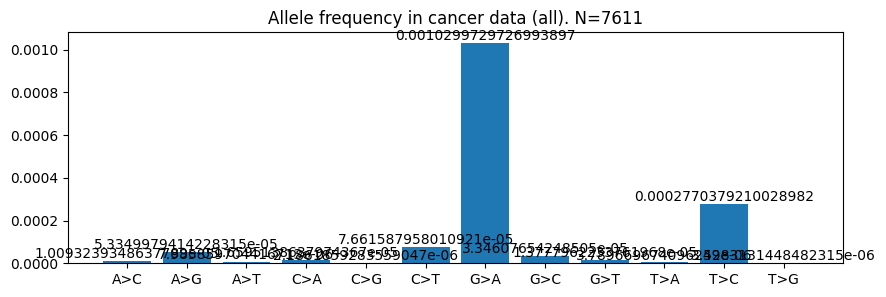

In [28]:
mode = 'all'
subs_number_cancer = cancer_subs_counter(mode=mode)
plt.figure(figsize=(10,3))
plt.bar_label(plt.bar(x=subs_number_cancer.keys(), 
                      height=subs_number_cancer.values()), 
                      labels=subs_number_cancer.values())

plt.title(f'Allele frequency in cancer data ({mode}). N={len(cancer_df)}')
plt.show()

In [11]:
mode = 'synSNP'
subs_number_cancer = cancer_subs_counter(mode=mode)
plt.figure(figsize=(10,3))
plt.bar(x=subs_number_cancer.keys(), height=subs_number_cancer.values())
plt.title(f'Allele frequency in cancer data ({mode}). N={len(cancer_df[cancer_df.var_type==mode])}')
plt.show()

NameError: name 'helix_base_freq' is not defined

In [12]:
mode = 'nsSNP'
subs_number_cancer = cancer_subs_counter(mode=mode)
plt.figure(figsize=(10,3))
plt.bar(x=subs_number_cancer.keys(), height=subs_number_cancer.values())
plt.title(f'Allele frequency in cancer data ({mode}). N={len(cancer_df[cancer_df.var_type==mode])}')
plt.show()

NameError: name 'helix_base_freq' is not defined

# HelixMT

In [ ]:
helix_samples_number =  196554
helix_df = pd.read_csv(r'..\\raw\HelixMTdb_20200327.tsv', sep='\t').copy()
helix_df

locus    alleles     feature    gene  counts_hom    AF_hom  \
0          chrM:5  ["A","C"]  non_coding  MT-CRb           1  0.000005   
1         chrM:10  ["T","C"]  non_coding  MT-CRb           7  0.000036   
2         chrM:11  ["C","T"]  non_coding  MT-CRb           0  0.000000   
3         chrM:12  ["T","C"]  non_coding  MT-CRb           1  0.000005   
4         chrM:16  ["A","T"]  non_coding  MT-CRb         273  0.001393   
...           ...        ...         ...     ...         ...       ...   
14319  chrM:16558  ["G","A"]  non_coding   MT-CR           3  0.000015   
14320  chrM:16559  ["A","G"]  non_coding   MT-CR           9  0.000046   
14321  chrM:16562  ["T","C"]  non_coding   MT-CR           0  0.000000   
14322  chrM:16564  ["A","G"]  non_coding   MT-CR           0  0.000000   
14323  chrM:16566  ["G","A"]  non_coding   MT-CR          32  0.000163   

       counts_het    AF_het  mean_ARF  max_ARF  \
0               0  0.000000       NaN      NaN   
1               1  0.000005   0.91892  0.91892   
2               1  0.000005   0.60714  0.60714   
3               0  0.000000       NaN      NaN   
4               4  0.000020   0.68971  0.92188   
...           ...       ...       ...      ...   
14319           0  0.000000       NaN      NaN   
14320           0  0.000000       NaN      NaN   
14321           1  0.000005   0.85714  0.85714   
14322           1  0.000005   0.70000  0.70000   
14323           4  0.000020   0.89204  0.91262   

                    haplogroups_for_homoplasmic_variants  \
0                                              [["H",1]]   
1                                              [["H",7]]   
2                                                     []   
3                                              [["D",1]]   
4      [["K",246],["U",12],["H",7],["V",2],["B",1],["...   
...                                                  ...   
14319                                          [["J",3]]   
14320                  [["A",3],["K",3],["H",2],["B",1]]   
14321                                                 []   
14322                                                 []   
14323  [["A",6],["H",6],["B",5],["T",3],["J",2],["U",...   

      haplogroups_for_heteroplasmic_variants  
0                                         []  
1                                  [["H",1]]  
2                                  [["H",1]]  
3                                         []  
4                 [["K",2],["L3",1],["U",1]]  
...                                      ...  
14319                                     []  
14320                                     []  
14321                              [["U",1]]  
14322                              [["H",1]]  
14323              [["M",2],["B",1],["J",1]]  

[14324 rows x 12 columns]

In [7]:
# unify helix_df to gnomad_df
helix_df['position'] = helix_df.locus.str[5:].astype(int)
helix_df[['ref', 'alt']] = helix_df.alleles.str.split(',', n=1, expand=True).astype(str)
helix_df.ref = helix_df.ref.str.strip('["]')
helix_df.alt = helix_df.alt.str.strip('["]')
helix_df = helix_df.reindex(columns=helix_df.columns[-3:].tolist() + helix_df.columns[2:-3].to_list())
helix_df.rename(columns={'counts_hom':'AC_hom', 'counts_het':'AC_het'}, inplace=True)
helix_df

position ref alt     feature    gene  AC_hom    AF_hom  AC_het  \
0             5   A   C  non_coding  MT-CRb       1  0.000005       0   
1            10   T   C  non_coding  MT-CRb       7  0.000036       1   
2            11   C   T  non_coding  MT-CRb       0  0.000000       1   
3            12   T   C  non_coding  MT-CRb       1  0.000005       0   
4            16   A   T  non_coding  MT-CRb     273  0.001393       4   
...         ...  ..  ..         ...     ...     ...       ...     ...   
14319     16558   G   A  non_coding   MT-CR       3  0.000015       0   
14320     16559   A   G  non_coding   MT-CR       9  0.000046       0   
14321     16562   T   C  non_coding   MT-CR       0  0.000000       1   
14322     16564   A   G  non_coding   MT-CR       0  0.000000       1   
14323     16566   G   A  non_coding   MT-CR      32  0.000163       4   

         AF_het  mean_ARF  max_ARF  \
0      0.000000       NaN      NaN   
1      0.000005   0.91892  0.91892   
2      0.000005   0.60714  0.60714   
3      0.000000       NaN      NaN   
4      0.000020   0.68971  0.92188   
...         ...       ...      ...   
14319  0.000000       NaN      NaN   
14320  0.000000       NaN      NaN   
14321  0.000005   0.85714  0.85714   
14322  0.000005   0.70000  0.70000   
14323  0.000020   0.89204  0.91262   

                    haplogroups_for_homoplasmic_variants  \
0                                              [["H",1]]   
1                                              [["H",7]]   
2                                                     []   
3                                              [["D",1]]   
4      [["K",246],["U",12],["H",7],["V",2],["B",1],["...   
...                                                  ...   
14319                                          [["J",3]]   
14320                  [["A",3],["K",3],["H",2],["B",1]]   
14321                                                 []   
14322                                                 []   
14323  [["A",6],["H",6],["B",5],["T",3],["J",2],["U",...   

      haplogroups_for_heteroplasmic_variants  
0                                         []  
1                                  [["H",1]]  
2                                  [["H",1]]  
3                                         []  
4                 [["K",2],["L3",1],["U",1]]  
...                                      ...  
14319                                     []  
14320                                     []  
14321                              [["U",1]]  
14322                              [["H",1]]  
14323              [["M",2],["B",1],["J",1]]  

[14324 rows x 13 columns]

In [11]:
helix_df_singleton = helix_df[helix_df[['AC_het', 'AC_hom']].sum(axis=1) == 1]
helix_df_2_001 = helix_df[(helix_df[['AC_het', 'AC_hom']].sum(axis=1) > 1) & (helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.0001)]
helix_df_001_01 = helix_df[(helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.0001) & (helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.001)]
helix_df_01_1 = helix_df[(helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.001) & (helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.01)]
helix_df_1_10 = helix_df[(helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.01) & (helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.1)]
helix_df_10_ = helix_df[helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.1]
helix_dfs = {'singleton':helix_df_singleton, '2-0.1%':helix_df_2_001, '0.01-0.1%':helix_df_001_01, '0.1-1%':helix_df_01_1, '1-10%':helix_df_1_10, '>10%':helix_df_10_}

# values_list = []
# for df in helix_dfs.values():
#     values_list.append(len(df))
list(map(len, helix_dfs.values()))

[3385, 6015, 3502, 1122, 265, 35]

In [13]:
only_subs_helix_df = helix_df[((helix_df.ref.apply(len)) == 1) & ((helix_df.alt.apply(len) == 1))] #  | (helix_df.gene.isin(['MT-CRb', 'MT-CR']))
only_subs_helix_df

position ref alt     feature    gene  AC_hom    AF_hom  AC_het  \
0             5   A   C  non_coding  MT-CRb       1  0.000005       0   
1            10   T   C  non_coding  MT-CRb       7  0.000036       1   
2            11   C   T  non_coding  MT-CRb       0  0.000000       1   
3            12   T   C  non_coding  MT-CRb       1  0.000005       0   
4            16   A   T  non_coding  MT-CRb     273  0.001393       4   
...         ...  ..  ..         ...     ...     ...       ...     ...   
14319     16558   G   A  non_coding   MT-CR       3  0.000015       0   
14320     16559   A   G  non_coding   MT-CR       9  0.000046       0   
14321     16562   T   C  non_coding   MT-CR       0  0.000000       1   
14322     16564   A   G  non_coding   MT-CR       0  0.000000       1   
14323     16566   G   A  non_coding   MT-CR      32  0.000163       4   

         AF_het  mean_ARF  max_ARF  \
0      0.000000       NaN      NaN   
1      0.000005   0.91892  0.91892   
2      0.000005   0.60714  0.60714   
3      0.000000       NaN      NaN   
4      0.000020   0.68971  0.92188   
...         ...       ...      ...   
14319  0.000000       NaN      NaN   
14320  0.000000       NaN      NaN   
14321  0.000005   0.85714  0.85714   
14322  0.000005   0.70000  0.70000   
14323  0.000020   0.89204  0.91262   

                    haplogroups_for_homoplasmic_variants  \
0                                              [["H",1]]   
1                                              [["H",7]]   
2                                                     []   
3                                              [["D",1]]   
4      [["K",246],["U",12],["H",7],["V",2],["B",1],["...   
...                                                  ...   
14319                                          [["J",3]]   
14320                  [["A",3],["K",3],["H",2],["B",1]]   
14321                                                 []   
14322                                                 []   
14323  [["A",6],["H",6],["B",5],["T",3],["J",2],["U",...   

      haplogroups_for_heteroplasmic_variants  
0                                         []  
1                                  [["H",1]]  
2                                  [["H",1]]  
3                                         []  
4                 [["K",2],["L3",1],["U",1]]  
...                                      ...  
14319                                     []  
14320                                     []  
14321                              [["U",1]]  
14322                              [["H",1]]  
14323              [["M",2],["B",1],["J",1]]  

[13407 rows x 13 columns]

In [7]:
only_subs_helix_df_singleton = only_subs_helix_df[only_subs_helix_df[['AC_het', 'AC_hom']].sum(axis=1) == 1]
only_subs_helix_df_2_001 = only_subs_helix_df[(only_subs_helix_df[['AC_het', 'AC_hom']].sum(axis=1) > 1) & (only_subs_helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.0001)]
only_subs_helix_df_001_01 = only_subs_helix_df[(only_subs_helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.0001) & (only_subs_helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.001)]
only_subs_helix_df_01_1 = only_subs_helix_df[(only_subs_helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.001) & (only_subs_helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.01)]
only_subs_helix_df_1_10 = only_subs_helix_df[(only_subs_helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.01) & (only_subs_helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.1)]
only_subs_helix_df_10_ = only_subs_helix_df[only_subs_helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.1]
only_subs_helix_dfs = {'singleton':only_subs_helix_df_singleton, '2-0.1%':only_subs_helix_df_2_001, '0.01-0.1%':only_subs_helix_df_001_01, '0.1-1%':only_subs_helix_df_01_1, '1-10%':only_subs_helix_df_1_10, '>10%':only_subs_helix_df_10_}
list(map(len, only_subs_helix_dfs.values()))

[2749, 5131, 3039, 909, 177, 22]

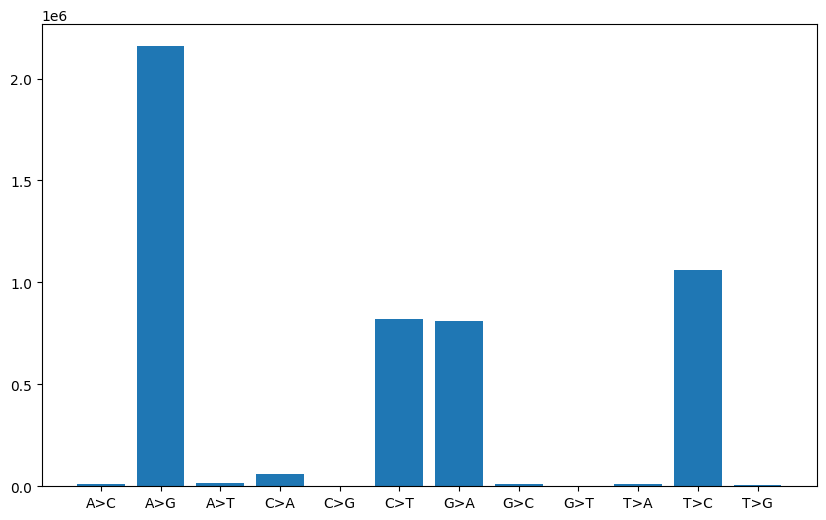

In [16]:
subs_number = only_subs_helix_df.groupby(['ref', 'alt']).sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.show()

## RefSeq

In [ ]:
refseq_helix = SeqIO.read(r"..\raw\J01415.2.gb", "genbank")
helix_cds = []
for refseq_helix_feature in refseq_helix.features:
    if refseq_helix_feature.type == 'CDS': #  ['source', 'D-loop', 'gene', 'misc_feature']
        helix_cds.append(refseq_helix_feature)
helix_cds

[SeqFeature(SimpleLocation(ExactPosition(3306), ExactPosition(4262), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(4469), ExactPosition(5511), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(5903), ExactPosition(7445), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(7585), ExactPosition(8269), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(8365), ExactPosition(8572), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(8526), ExactPosition(9207), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(9206), ExactPosition(9990), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(10058), ExactPosition(10404), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(10469), ExactPosition(10766), strand=1), type='CDS', qualifiers=...),
 SeqFeature(Sim

In [ ]:
# locations_dict = {}
# for refseq_helix_feature in rCRS_cds:
#     start = refseq_helix_feature.location.nofuzzy_start
#     end = refseq_helix_feature.location.nofuzzy_end
#     location_name = refseq_helix_feature.qualifiers['gene'][0]
#     locations_dict[f'{start}-{end}'] = location_name
# locations_dict

In [14]:
# checking of substitutioning and reference bases match
for idx in range(len(only_subs_helix_df)):
    sub = only_subs_helix_df.iloc[idx]
    position = sub.position
    initial_base = sub.ref
    reference_base = refseq_helix.seq[position-1]
    if initial_base != reference_base:
        print(position, initial_base, reference_base)

In [9]:
for cds_loc in helix_cds:
    sequence = cds_loc.location.extract(refseq_helix.seq)
    protein = sequence.translate(table=2, to_stop=True)
    print(cds_loc.qualifiers['gene'], len(protein), protein)
# ND2 INP

['ND1'] 318 MPMANLLLLIVPILIAMAFLMLTERKILGYMQLRKGPNVVGPYGLLQPFADAMKLFTKEPLKPATSTITLYITAPTLALTIALLLWTPLPMPNPLVNLNLGLLFILATSSLAVYSILWSGWASNSNYALIGALRAVAQTISYEVTLAIILLSTLLMSGSFNLSTLITTQEHLWLLLPSWPLAMMWFISTLAETNRTPFDLAEGESELVSGFNIEYAAGPFALFFMAEYTNIIMMNTLTTTIFLGTTYDALSPELYTTYFVTKTLLLTSLFLWIRTAYPRFRYDQLMHLLWKNFLPLTLALLMWYVSMPITISSIPPQT
['ND2'] 347 INPLAQPVIYSTIFAGTLITALSSHWFFTWVGLEMNMLAFIPVLTKKMNPRSTEAAIKYFLTQATASMILLMAILFNNMLSGQWTMTNTTNQYSSLMIMMAMAMKLGMAPFHFWVPEVTQGTPLTSGLLLLTWQKLAPISIMYQISPSLNVSLLLTLSILSIMAGSWGGLNQTQLRKILAYSSITHMGWMMAVLPYNPNMTILNLTIYIILTTTAFLLLNLNSSTTTLLLSRTWNKLTWLTPLIPSTLLSLGGLPPLTGFLPKWAIIEEFTKNNSLIIPTIMATITLLNLYFYLRLIYSTSITLLPMSNNVKMKWQFEHTKPTPFLPTLIALTTLLLPISPFMLMIL
['COX1'] 513 MFADRWLFSTNHKDIGTLYLLFGAWAGVLGTALSLLIRAELGQPGNLLGNDHIYNVIVTAHAFVMIFFMVMPIMIGGFGNWLVPLMIGAPDMAFPRMNNMSFWLLPPSLLLLLASAMVEAGAGTGWTVYPPLAGNYSHPGASVDLTIFSLHLAGVSSILGAINFITTIINMKPPAMTQYQTPLFVWSVLITAVLLLLSLPVLAAGITMLLTDRNLNTTFFDPAGGGDPILYQHLFWFFGHPEVYILILPGFGMISHIVTYYSGKKEPFGYMGMVWAMMSIGFLGFIVWAHHMFTVG

c:\Soft\Python\Lib\site-packages\Bio\Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [10]:
cds_subs_helix_df = only_subs_helix_df.loc[only_subs_helix_df.feature=='protein_coding_gene']
cds_subs_helix_df

position ref alt              feature    gene  AC_hom    AF_hom  \
2799       3307   A   C  protein_coding_gene  MT-ND1       1  0.000005   
2800       3307   A   G  protein_coding_gene  MT-ND1       1  0.000005   
2801       3308   T   C  protein_coding_gene  MT-ND1    1126  0.005745   
2802       3308   T   G  protein_coding_gene  MT-ND1      89  0.000454   
2803       3309   A   G  protein_coding_gene  MT-ND1       1  0.000005   
...         ...  ..  ..                  ...     ...     ...       ...   
13443     15885   C   A  protein_coding_gene  MT-CYB       1  0.000005   
13444     15885   C   T  protein_coding_gene  MT-CYB     126  0.000643   
13445     15886   C   A  protein_coding_gene  MT-CYB       1  0.000005   
13446     15886   C   T  protein_coding_gene  MT-CYB      37  0.000189   
13447     15887   T   C  protein_coding_gene  MT-CYB       0  0.000000   

       AC_het    AF_het  mean_ARF  max_ARF  \
2799        0  0.000000       NaN      NaN   
2800        2  0.000010   0.27253  0.31429   
2801       26  0.000133   0.50148  0.94643   
2802        0  0.000000       NaN      NaN   
2803        0  0.000000       NaN      NaN   
...       ...       ...       ...      ...   
13443       0  0.000000       NaN      NaN   
13444       2  0.000010   0.29366  0.40550   
13445       0  0.000000       NaN      NaN   
13446       3  0.000015   0.52856  0.61940   
13447       2  0.000010   0.13591  0.15789   

                    haplogroups_for_homoplasmic_variants  \
2799                                           [["C",1]]   
2800                                           [["H",1]]   
2801   [["L1",850],["A",92],["K",51],["L2",38],["H",2...   
2802                                          [["T",89]]   
2803                                           [["K",1]]   
...                                                  ...   
13443                                          [["V",1]]   
13444  [["H",102],["B",13],["R",7],["U",2],["X",1],["...   
13445                                          [["H",1]]   
13446  [["H",11],["M",6],["L1",5],["R",4],["C",3],["K...   
13447                                                 []   

                  haplogroups_for_heteroplasmic_variants  
2799                                                  []  
2800                                           [["U",2]]  
2801   [["H",8],["A",4],["T",3],["J",2],["L1",2],["U"...  
2802                                                  []  
2803                                                  []  
...                                                  ...  
13443                                                 []  
13444                                  [["K",1],["N",1]]  
13445                                                 []  
13446                          [["H",1],["U",1],["V",1]]  
13447                                  [["K",1],["U",1]]  

[9510 rows x 13 columns]

In [16]:
only_syn_helix_df = syn_subs_extracter(cds_subs_helix_df, helix_cds, refseq_helix)
only_syn_helix_df

c:\Soft\Python\Lib\site-packages\Bio\Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


position ref alt              feature    gene  AC_hom    AF_hom  \
2801       3308   T   C  protein_coding_gene  MT-ND1    1126  0.005745   
2807       3311   C   T  protein_coding_gene  MT-ND1      21  0.000107   
2811       3317   C   G  protein_coding_gene  MT-ND1       2  0.000010   
2812       3317   C   T  protein_coding_gene  MT-ND1       6  0.000031   
2816       3320   A   G  protein_coding_gene  MT-ND1      14  0.000071   
...         ...  ..  ..                  ...     ...     ...       ...   
13442     15884   G   T  protein_coding_gene  MT-CYB       3  0.000015   
13443     15885   C   A  protein_coding_gene  MT-CYB       1  0.000005   
13444     15885   C   T  protein_coding_gene  MT-CYB     126  0.000643   
13445     15886   C   A  protein_coding_gene  MT-CYB       1  0.000005   
13446     15886   C   T  protein_coding_gene  MT-CYB      37  0.000189   

       AC_het    AF_het  mean_ARF  max_ARF  \
2801       26  0.000133   0.50148  0.94643   
2807        2  0.000010   0.49912  0.76699   
2811        0  0.000000       NaN      NaN   
2812        4  0.000020   0.16558  0.25714   
2816        1  0.000005   0.10811  0.10811   
...       ...       ...       ...      ...   
13442       1  0.000005   0.16154  0.16154   
13443       0  0.000000       NaN      NaN   
13444       2  0.000010   0.29366  0.40550   
13445       0  0.000000       NaN      NaN   
13446       3  0.000015   0.52856  0.61940   

                    haplogroups_for_homoplasmic_variants  \
2801   [["L1",850],["A",92],["K",51],["L2",38],["H",2...   
2807                        [["HV",12],["A",8],["L3",1]]   
2811                                           [["H",2]]   
2812          [["M",2],["B",1],["J",1],["L1",1],["T",1]]   
2816                   [["C",9],["B",2],["R",2],["F",1]]   
...                                                  ...   
13442                                          [["M",3]]   
13443                                          [["V",1]]   
13444  [["H",102],["B",13],["R",7],["U",2],["X",1],["...   
13445                                          [["H",1]]   
13446  [["H",11],["M",6],["L1",5],["R",4],["C",3],["K...   

                  haplogroups_for_heteroplasmic_variants  
2801   [["H",8],["A",4],["T",3],["J",2],["L1",2],["U"...  
2807                                  [["H",1],["L2",1]]  
2811                                                  []  
2812                   [["H",1],["I",1],["T",1],["U",1]]  
2816                                           [["U",1]]  
...                                                  ...  
13442                                          [["A",1]]  
13443                                                 []  
13444                                  [["K",1],["N",1]]  
13445                                                 []  
13446                          [["H",1],["U",1],["V",1]]  

[8964 rows x 13 columns]

In [12]:
only_syn_helix_df_singleton = only_syn_helix_df[only_syn_helix_df[['AC_het', 'AC_hom']].sum(axis=1) == 1]
only_syn_helix_df_2_001 = only_syn_helix_df[(only_syn_helix_df[['AC_het', 'AC_hom']].sum(axis=1) > 1) & (only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.0001)]
only_syn_helix_df_001_01 = only_syn_helix_df[(only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.0001) & (only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.001)]
only_syn_helix_df_01_1 = only_syn_helix_df[(only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.001) & (only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.01)]
only_syn_helix_df_1_10 = only_syn_helix_df[(only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.01) & (only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= 0.1)]
only_syn_helix_df_10_ = only_syn_helix_df[only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.1]
only_syn_helix_dfs = {'singleton':only_syn_helix_df_singleton, '2-0.1%':only_syn_helix_df_2_001, '0.01-0.1%':only_syn_helix_df_001_01, '0.1-1%':only_syn_helix_df_01_1, '1-10%':only_syn_helix_df_1_10, '>10%':only_syn_helix_df_10_}
list(map(len, only_syn_helix_dfs.values())) 

NameError: name 'only_syn_helix_df' is not defined

In [16]:
# base_usage
base_freq = {base:refseq_helix.seq.count(base) for base in ['A', 'T', 'G', 'C']}
base_freq

{'A': 5124, 'T': 4094, 'G': 2169, 'C': 5181}

In [17]:
# synonymous base usage
helix_base_freq = {base:0 for base in ['A', 'T', 'G', 'C']}
for cds in helix_cds:
    start = cds.location.start
    end = cds.location.end
    # gene_df = cds_subs_helix_df.loc[(cds_subs_helix_df.position > start) & (cds_subs_helix_df.position < end)]
    sequence = refseq_helix.seq[start-1:end-1]
    for base in ['A', 'T', 'G', 'C']:
        helix_base_freq[base] += sequence.count(base)
helix_base_freq

{'A': 3392, 'T': 2879, 'G': 1338, 'C': 3786}

In [14]:
# base usage of 1st and 2nd positions vs 3rd position
helix_base_freq = {base:0 for base in ['A', 'T', 'G', 'C']}
helix_base_freq_1_2 = {base:0 for base in ['A', 'T', 'G', 'C']}
helix_base_freq_3 = {base:0 for base in ['A', 'T', 'G', 'C']}
for cds in helix_cds:
    start = cds.location.start
    end = cds.location.end
    # gene_df = cds_subs_helix_df.loc[(cds_subs_helix_df.position > start) & (cds_subs_helix_df.position < end)]
    sequence = refseq_helix.seq[start-1:end-1]
    sequence_3 = sequence[2::3]
    for base in ['A', 'T', 'G', 'C']:
        helix_base_freq[base] += sequence.count(base)
        helix_base_freq_3[base] += sequence_3.count(base)
print(helix_base_freq)
print({i : round(helix_base_freq[i]/sum(helix_base_freq.values()), 3) for i in helix_base_freq})
print(helix_base_freq_3)
print({i : round(helix_base_freq_3[i]/sum(helix_base_freq_3.values()), 3) for i in helix_base_freq_3})

{'A': 3392, 'T': 2879, 'G': 1338, 'C': 3786}
{'A': 0.298, 'T': 0.253, 'G': 0.117, 'C': 0.332}
{'A': 790, 'T': 1504, 'G': 433, 'C': 1069}
{'A': 0.208, 'T': 0.396, 'G': 0.114, 'C': 0.282}


## Synonymous subs

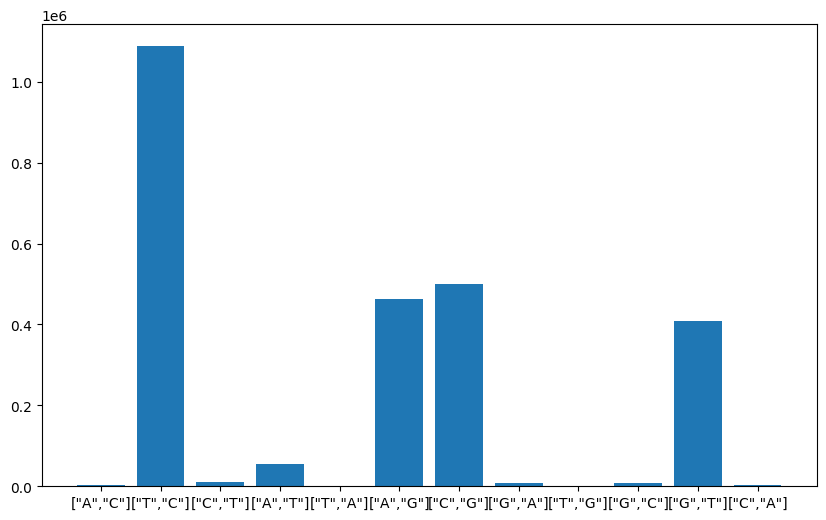

In [20]:
subs_number = only_syn_helix_df.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\3790884731.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.05100235849056604' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


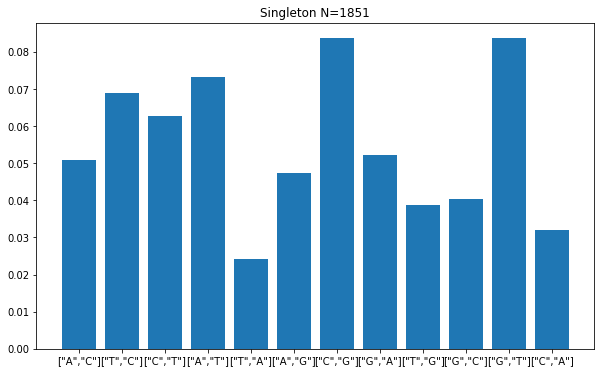

In [62]:
# only_syn_helix_df_singleton
subs_number = only_syn_helix_df_singleton.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'Singleton N={sample_size}')
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\1880290059.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.22169811320754718' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


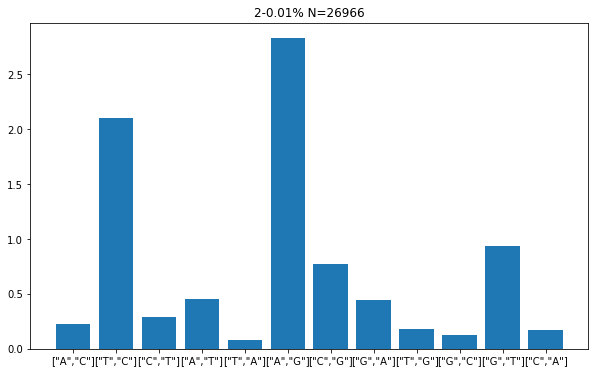

In [63]:
subs_number = only_syn_helix_df_2_001.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'2-0.01% N={sample_size}')
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\777798948.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.27682783018867924' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


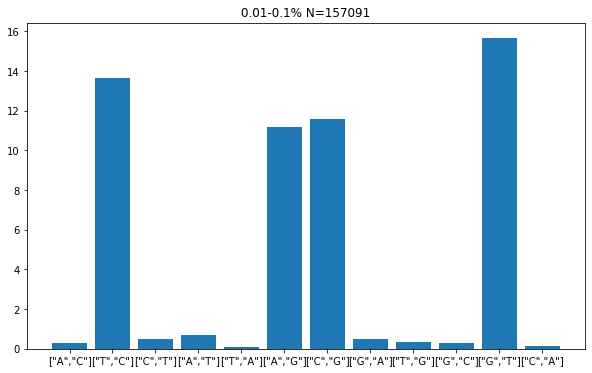

In [64]:
# only_syn_helix_df_singleton
subs_number = only_syn_helix_df_001_01.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'0.01-0.1% N={sample_size}')
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\2884042047.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5188679245283019' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


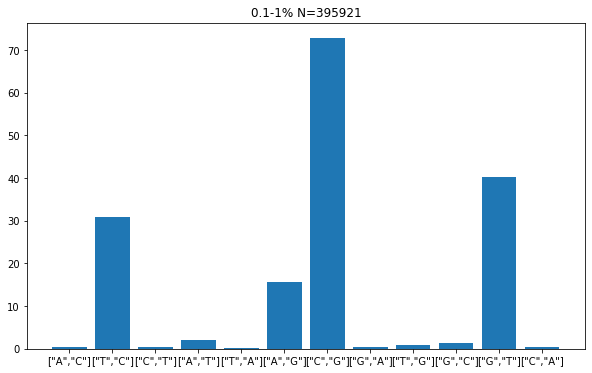

In [65]:
subs_number = only_syn_helix_df_01_1.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'0.1-1% N={sample_size}')
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\1299339104.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '67.2252358490566' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


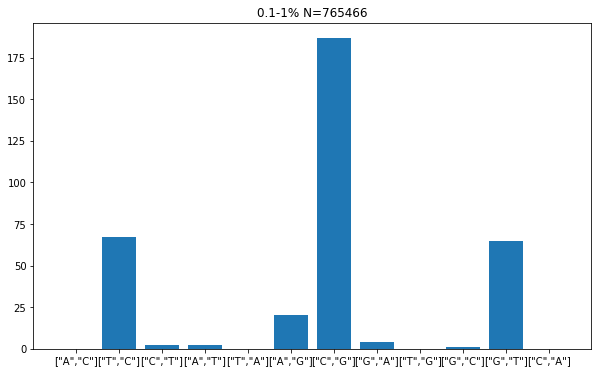

In [67]:
subs_number = only_syn_helix_df_1_10.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
subs_length_checker(subs_number)
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'0.1-1% N={sample_size}')
plt.show()

### Only empty haplogroups_for_heteroplasmic_variants

In [69]:
empty_het_haplogroups = only_syn_helix_df.loc[only_syn_helix_df.haplogroups_for_heteroplasmic_variants=='[]']
# empty_het_haplogroups

In [70]:
only_syn_het_df_singleton = empty_het_haplogroups[empty_het_haplogroups[['AC_het', 'AC_hom']].sum(axis=1) == 1]
only_syn_het_df_2_001 = empty_het_haplogroups[(empty_het_haplogroups[['AC_het', 'AC_hom']].sum(axis=1) > 1) & (empty_het_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) <= 0.0001)]
only_syn_het_df_001_01 = empty_het_haplogroups[(empty_het_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) > 0.0001) & (empty_het_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) <= 0.001)]
only_syn_het_df_01_1 = empty_het_haplogroups[(empty_het_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) > 0.001) & (empty_het_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) <= 0.01)]
only_syn_het_df_1_10 = empty_het_haplogroups[(empty_het_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) > 0.01) & (empty_het_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) <= 0.1)]
only_syn_het_df_10_ = empty_het_haplogroups[empty_het_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) > 0.1]
only_syn_het_dfs = {'singleton':only_syn_het_df_singleton, '2-0.1%':only_syn_het_df_2_001, '0.01-0.1%':only_syn_het_df_001_01, '0.1-1%':only_syn_het_df_01_1, '1-10%':only_syn_het_df_1_10, '>10%':only_syn_het_df_10_}
list(map(len, only_syn_het_dfs.values())) 

[809, 1407, 366, 21, 0, 0]

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_20472\1307832590.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.019711163153786106' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= base_freq[sub[2]]


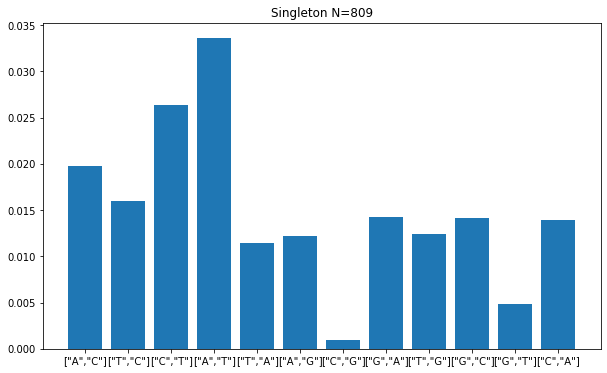

In [101]:
# only_syn_helix_df_singleton
subs_number = only_syn_het_df_singleton.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'Singleton N={sample_size}')
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\1701311826.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.1474056603773585' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


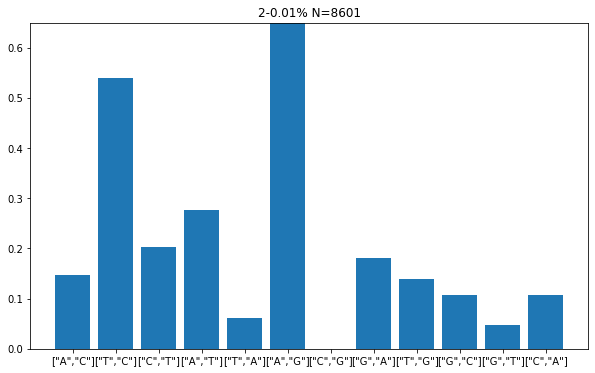

In [72]:
subs_number = only_syn_het_df_2_001.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
subs_length_checker(subs_number)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'2-0.01% N={sample_size}')
plt.ylim(top=0.65)
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\2718111574.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.052181603773584904' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


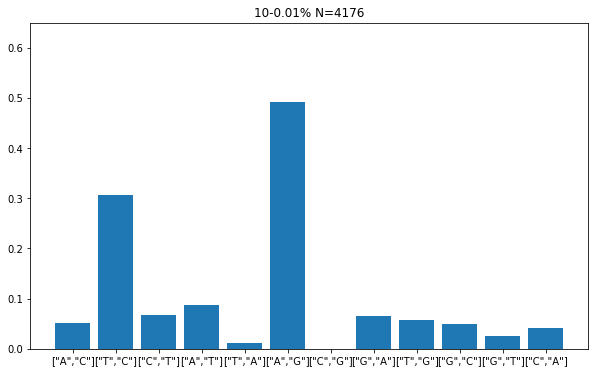

In [73]:
only_syn_het_df_10_001 = empty_het_haplogroups[(empty_het_haplogroups[['AC_het', 'AC_hom']].sum(axis=1) > 9) & (empty_het_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) <= 0.0001)]
subs_number = only_syn_het_df_10_001.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
if len(subs_number) < 12:
    for sub in substitutions:
        if sub not in subs_number:
            subs_number[sub] = 0
    subs_number.sort_index(inplace=True)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'10-0.01% N={sample_size}')
plt.ylim(top=0.65)
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\1062597119.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.09522405660377359' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


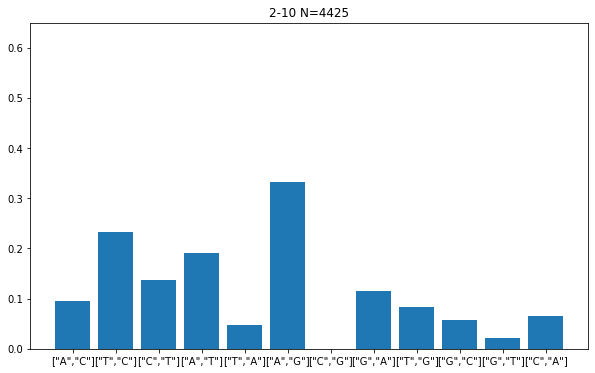

In [75]:
only_syn_het_df_2_10 = empty_het_haplogroups[(empty_het_haplogroups[['AC_het', 'AC_hom']].sum(axis=1) <= 9) & (empty_het_haplogroups[['AC_het', 'AC_hom']].sum(axis=1) > 1)]
subs_number = only_syn_het_df_2_10.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
subs_length_checker(subs_number)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'2-10 N={sample_size}')
plt.ylim(top=0.65)
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\1174192494.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.2514740566037736' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


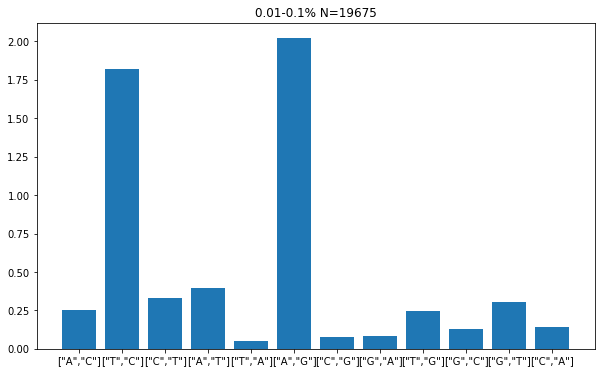

In [76]:
subs_number = only_syn_het_df_001_01.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
subs_length_checker(subs_number)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'0.01-0.1% N={sample_size}')
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\2029386905.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.07222877358490566' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


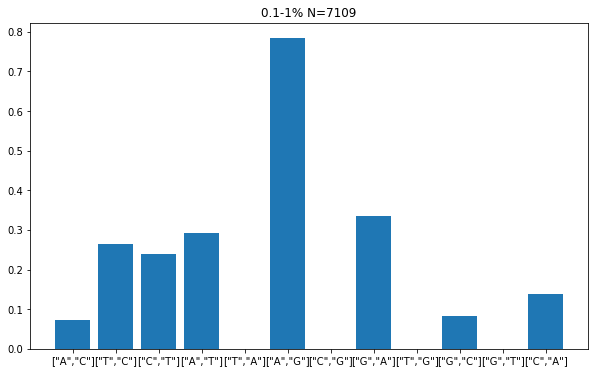

In [77]:
subs_number = only_syn_het_df_01_1.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
subs_length_checker(subs_number)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'0.1-1% N={sample_size}')
plt.show()

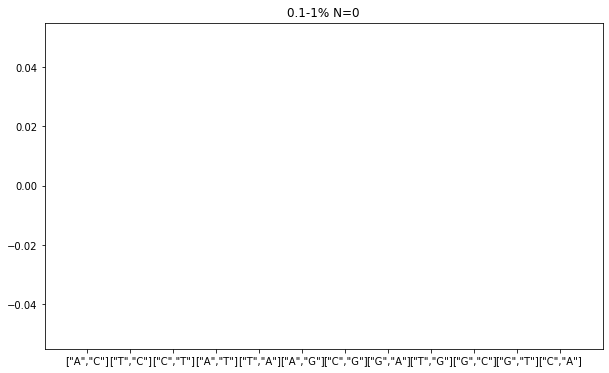

In [78]:
subs_number = only_syn_het_df_1_10.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
subs_length_checker(subs_number)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'0.1-1% N={sample_size}')
plt.show()

### Only empty haplogroups_for_homoplasmic_variants

In [128]:
empty_hom_haplogroups = only_syn_helix_df.loc[only_syn_helix_df.haplogroups_for_homoplasmic_variants=='[]']
# empty_hom_haplogroups

In [83]:
only_syn_hom_df_singleton = empty_hom_haplogroups[empty_hom_haplogroups[['AC_het', 'AC_hom']].sum(axis=1) == 1]
only_syn_hom_df_2_001 = empty_hom_haplogroups[(empty_hom_haplogroups[['AC_het', 'AC_hom']].sum(axis=1) > 1) & (empty_hom_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) <= 0.0001)]
only_syn_hom_df_001_01 = empty_hom_haplogroups[(empty_hom_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) > 0.0001) & (empty_hom_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) <= 0.001)]
only_syn_hom_df_01_1 = empty_hom_haplogroups[(empty_hom_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) > 0.001) & (empty_hom_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) <= 0.01)]
only_syn_hom_df_1_10 = empty_hom_haplogroups[(empty_hom_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) > 0.01) & (empty_hom_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) <= 0.1)]
only_syn_hom_df_10_ = empty_hom_haplogroups[empty_hom_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) > 0.1]
only_syn_hom_dfs = {'singleton':only_syn_hom_df_singleton, '2-0.1%':only_syn_hom_df_2_001, '0.01-0.1%':only_syn_hom_df_001_01, '0.1-1%':only_syn_hom_df_01_1, '1-10%':only_syn_hom_df_1_10, '>10%':only_syn_hom_df_10_}
list(map(len, only_syn_hom_dfs.values())) 

[1042, 357, 3, 0, 0, 0]

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\616861362.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.02122641509433962' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


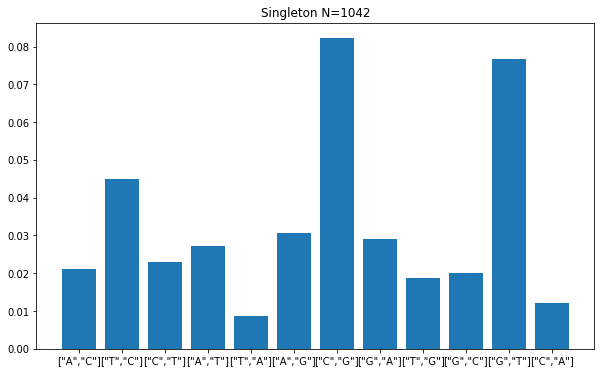

In [84]:
# only_syn_helix_df_singleton
subs_number = only_syn_hom_df_singleton.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'Singleton N={sample_size}')
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\1200568817.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.008549528301886792' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


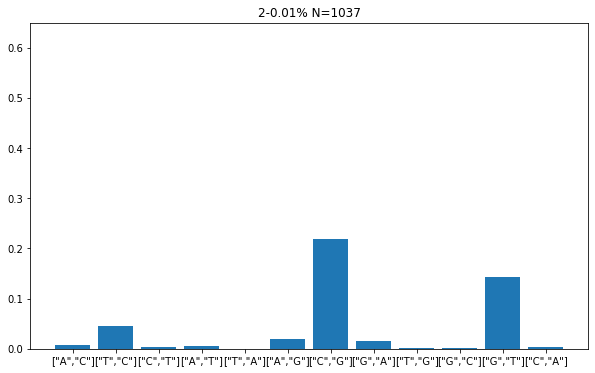

In [85]:
subs_number = only_syn_hom_df_2_001.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
subs_length_checker(subs_number)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'2-0.01% N={sample_size}')
plt.ylim(top=0.65)
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\1131766124.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.00294811320754717' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


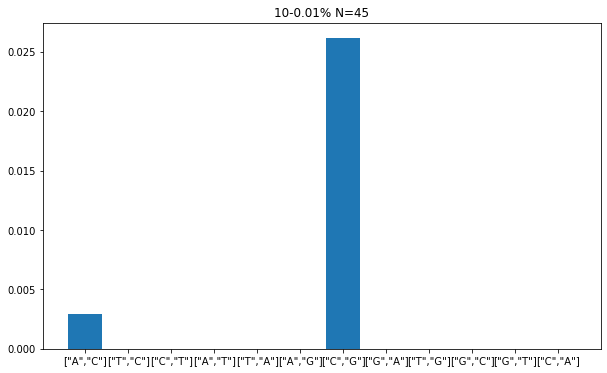

In [87]:
only_syn_hom_df_10_001 = empty_hom_haplogroups[(empty_hom_haplogroups[['AC_het', 'AC_hom']].sum(axis=1) > 9) & (empty_hom_haplogroups[['AF_hom', 'AF_het']].sum(axis=1) <= 0.0001)]
subs_number = only_syn_hom_df_10_001.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
subs_length_checker(subs_number)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'10-0.01% N={sample_size}')
# plt.ylim(top=0.65)
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\3633893234.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.005601415094339622' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


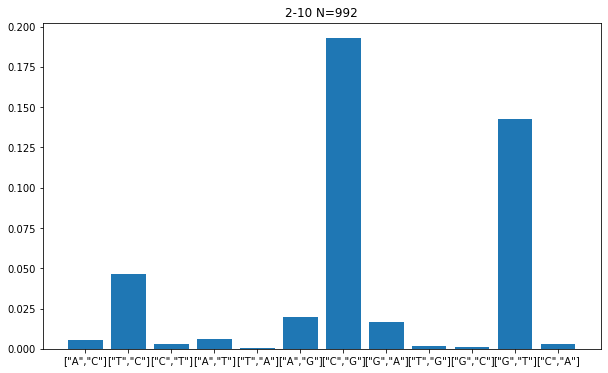

In [89]:
only_syn_hom_df_2_10 = empty_hom_haplogroups[(empty_hom_haplogroups[['AC_het', 'AC_hom']].sum(axis=1) <= 9) & (empty_hom_haplogroups[['AC_het', 'AC_hom']].sum(axis=1) > 1)]
subs_number = only_syn_hom_df_2_10.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
    subs_number[sub] /= 
subs_length_checker(subs_number)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'2-10 N={sample_size}')
# plt.ylim(top=0.65)
plt.show()

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_28284\4235216056.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.009433962264150943' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub] /= cds_base_freq[sub[2]]


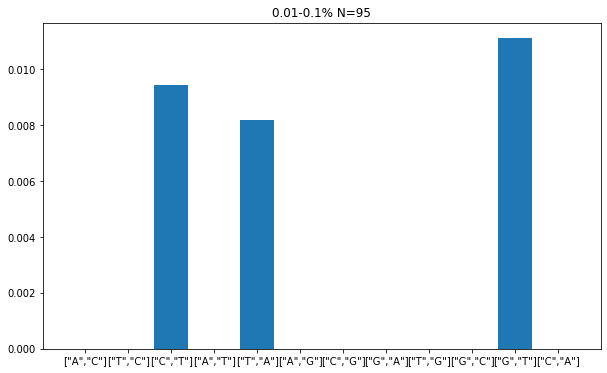

In [90]:
subs_number = only_syn_hom_df_001_01.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
subs_length_checker(subs_number)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'0.01-0.1% N={sample_size}')
plt.show()

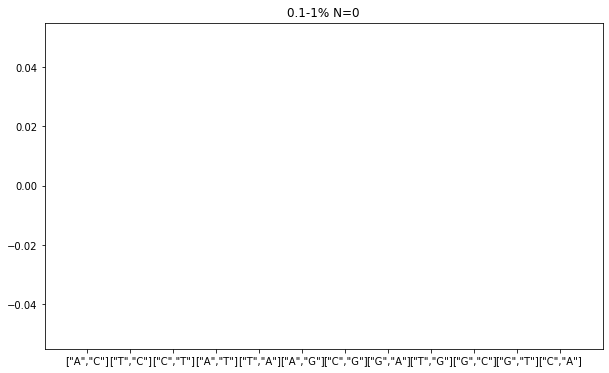

In [91]:
subs_number = only_syn_hom_df_01_1.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
sample_size = subs_number.sum()
for sub in subs_number.index:
    subs_number[sub] /= helix_base_freq[sub[2]]
subs_length_checker(subs_number)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'0.1-1% N={sample_size}')
plt.show()

## Total Low and High VAF

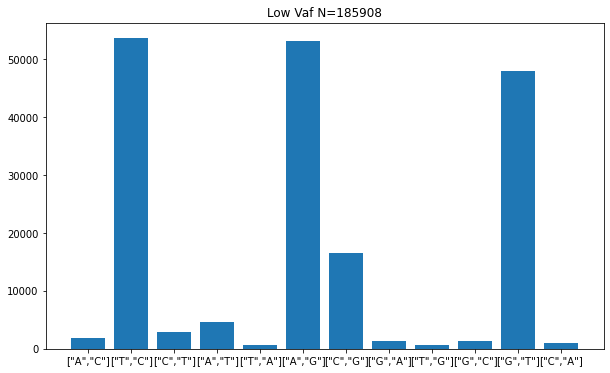

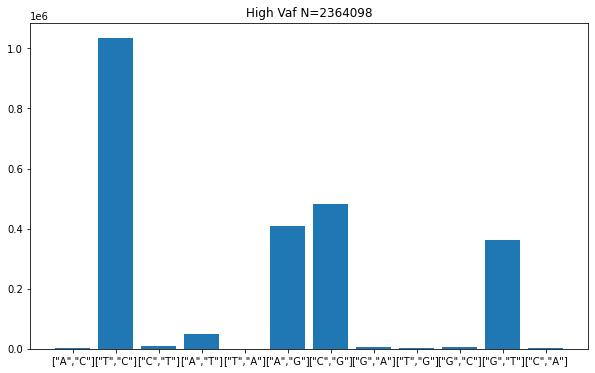

In [124]:
threshold = 0.001
top = 8 * 10**5
only_syn_helix_df_low_vaf = only_syn_helix_df[(only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) <= threshold) & (only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.000005)]
subs_number = only_syn_helix_df_low_vaf.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'Low Vaf N={subs_number.sum()}')
# plt.ylim(top=top)
plt.show()
only_syn_helix_df_high_vaf = only_syn_helix_df[(only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) > threshold) & (only_syn_helix_df[['AF_hom', 'AF_het']].sum(axis=1) > 0.000005)]
subs_number = only_syn_helix_df_high_vaf.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
if len(subs_number) < 12:
    for sub in substitutions:
        if sub not in subs_number:
            subs_number[sub] = 0
    subs_number.sort_index(inplace=True)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'High Vaf N={subs_number.sum()}')
# plt.ylim(top=top)
plt.show()

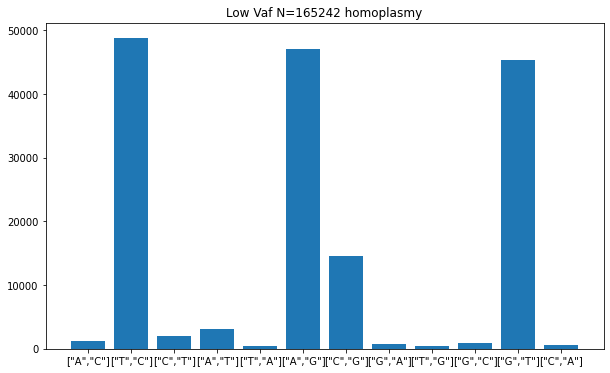

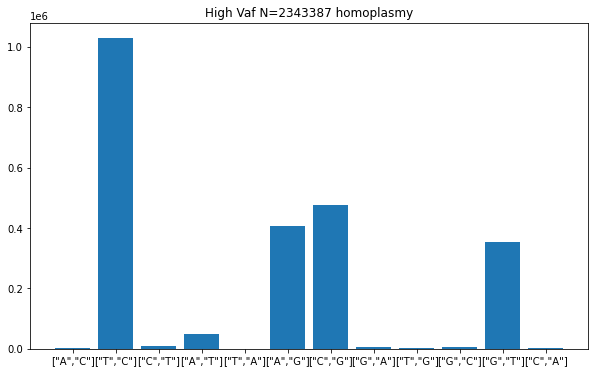

In [98]:
# homoplasmy
threshold = 0.001
top = 8 * 10**5
only_syn_helix_df_low_vaf = only_syn_helix_df[(only_syn_helix_df[['AF_hom']].sum(axis=1) <= threshold) & (only_syn_helix_df[['AF_hom']].sum(axis=1) > 0.00005)]
subs_number = only_syn_helix_df_low_vaf.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom']].sum(axis=1)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'Low Vaf N={subs_number.sum()} homoplasmy')
# plt.ylim(top=top)
plt.show()

only_syn_helix_df_high_vaf = only_syn_helix_df[(only_syn_helix_df[['AF_hom']].sum(axis=1) > threshold) & (only_syn_helix_df[['AF_hom']].sum(axis=1) > 0.00005)]
subs_number = only_syn_helix_df_high_vaf.groupby('alleles').sum(numeric_only=True).loc[:,['AC_hom']].sum(axis=1)
if len(subs_number) < 12:
    for sub in substitutions:
        if sub not in subs_number:
            subs_number[sub] = 0
    subs_number.sort_index(inplace=True)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'High Vaf N={subs_number.sum()} homoplasmy')
# plt.ylim(top=top)
plt.show()

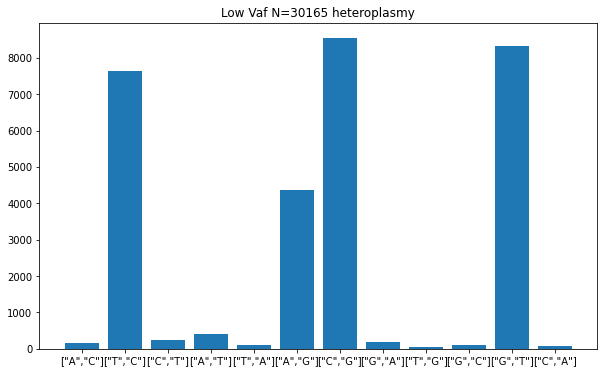

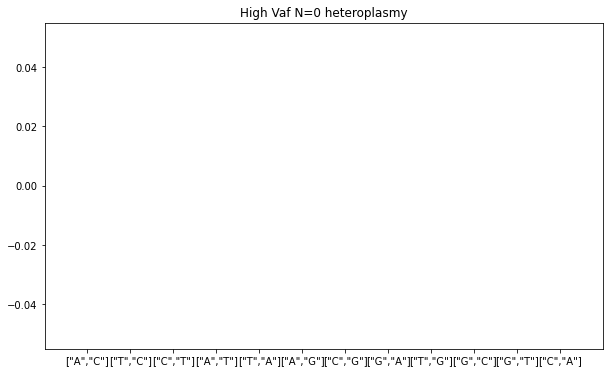

In [95]:
# heteroplamy
threshold = 0.1
top = 8 * 10**5
only_syn_helix_df_low_vaf = only_syn_helix_df[(only_syn_helix_df[['AF_het']].sum(axis=1) <= threshold) & (only_syn_helix_df[['AF_het']].sum(axis=1) > 0.000005)]
subs_number = only_syn_helix_df_low_vaf.groupby('alleles').sum(numeric_only=True).loc[:,['AC_het']].sum(axis=1)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'Low Vaf N={subs_number.sum()} heteroplasmy')
# plt.ylim(top=top)
plt.show()
only_syn_helix_df_high_vaf = only_syn_helix_df[(only_syn_helix_df[['AF_het']].sum(axis=1) > threshold) & (only_syn_helix_df[['AF_het']].sum(axis=1) > 0.000005)]
subs_number = only_syn_helix_df_high_vaf.groupby('alleles').sum(numeric_only=True).loc[:,['AC_het']].sum(axis=1)
subs_length_checker(subs_number)
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.title(f'High Vaf N={subs_number.sum()} heteroplasmy')
# plt.ylim(top=top)
plt.show()

In [78]:
only_syn_helix_df_no_singletons = only_syn_helix_df[only_syn_helix_df.loc[:,['AC_hom', 'AC_het']].sum(axis=1) >= 1]
only_syn_helix_df_no_less_10 = only_syn_helix_df[only_syn_helix_df.loc[:,['AC_hom', 'AC_het']].sum(axis=1) >= 9]

## Threshold search

In [26]:
def threshold_search_helix(helix_df, plasmy=['AC_hom', 'AC_het']):
    freq_array = sorted(helix_df.loc[:,['AF_hom', 'AF_het']].sum(axis=1).unique()[::150])
    # freq_array = np.logspace(-5, -1, 5)

    subs_freq_df = helix_df.loc[:,['AF_hom', 'AF_het']].sum(axis=1)
    for idx in range(len(freq_array)-1):
        threshold_lower = freq_array[idx] 
        threshold_upper = freq_array[idx+1]
        threshold_df = helix_df[(subs_freq_df >= threshold_lower) & (subs_freq_df < threshold_upper)]
        subs_number = threshold_df.groupby('alleles').sum(numeric_only=True).loc[:,plasmy].sum(axis=1)
        subs_number_sum = subs_number.sum()
        for sub in subs_number.index:
            subs_number[sub] /= helix_base_freq[sub[2]]
        subs_length_checker(subs_number, substitutions)
        plt.figure(figsize=(10,3))
        plt.bar(x=subs_number.index, height=subs_number)
        plt.title(f'Allele frequency {threshold_lower*100:.2}-{threshold_upper*100:.2}% plasmy: {[i[-3:] for i in plasmy]} N={subs_number_sum}')
        # plt.ylim(top=top)
        plt.show()

### No singletons

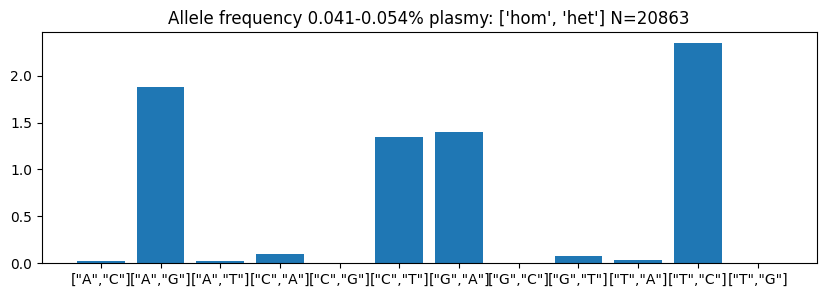

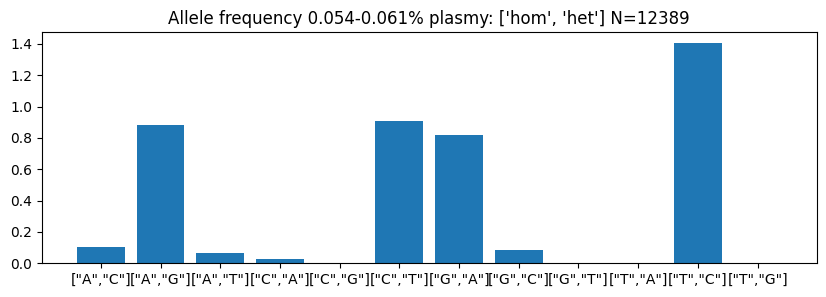

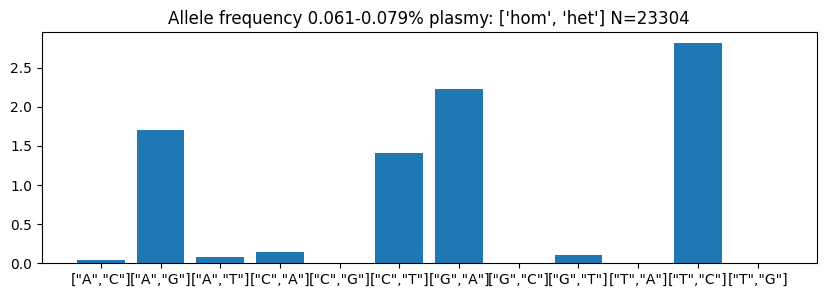

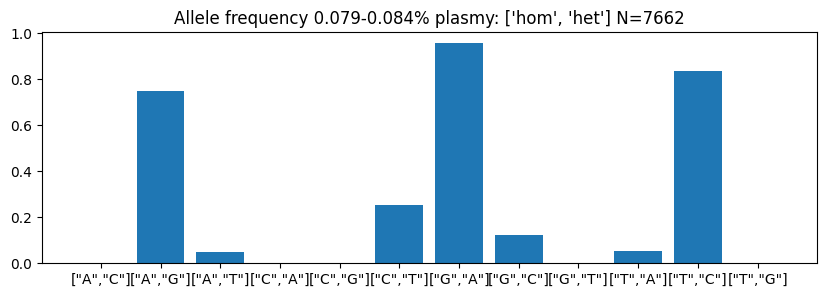

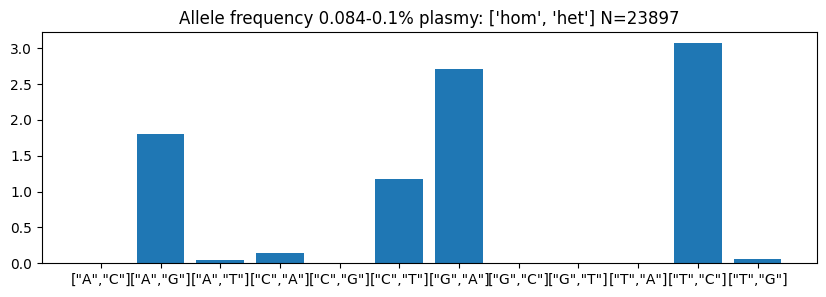

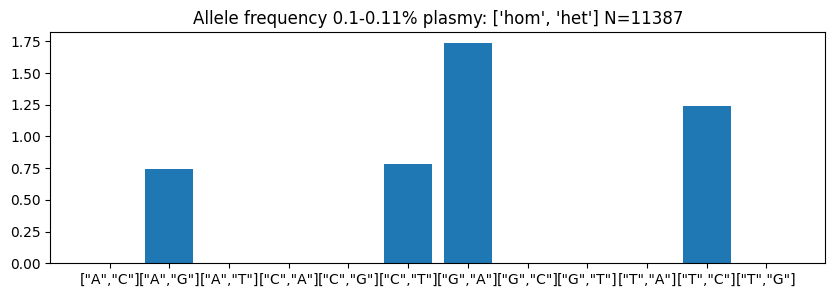

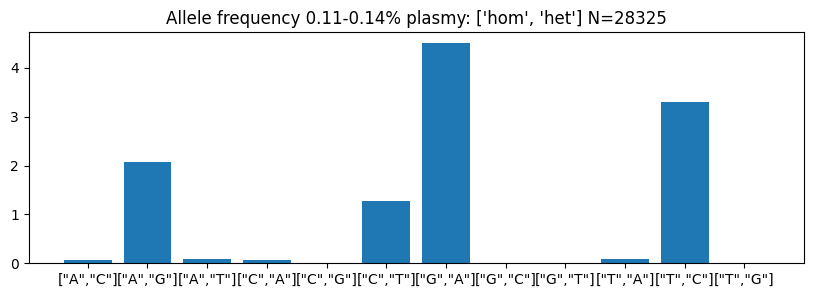

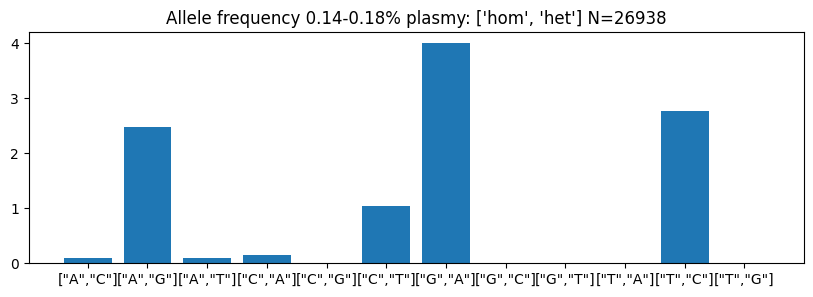

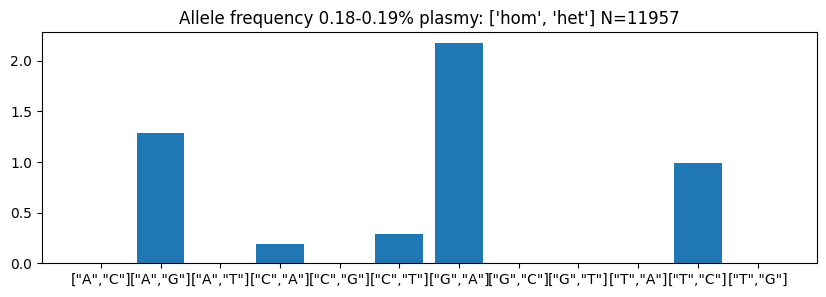

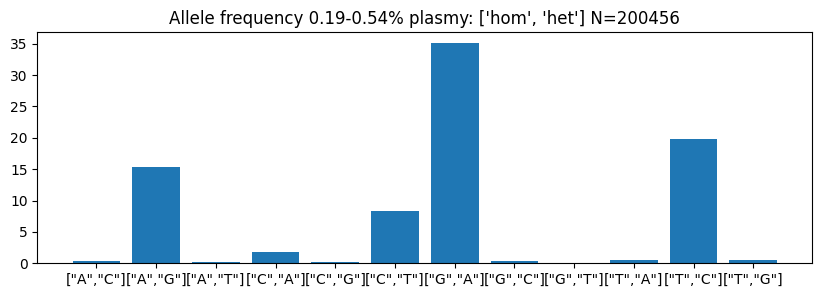

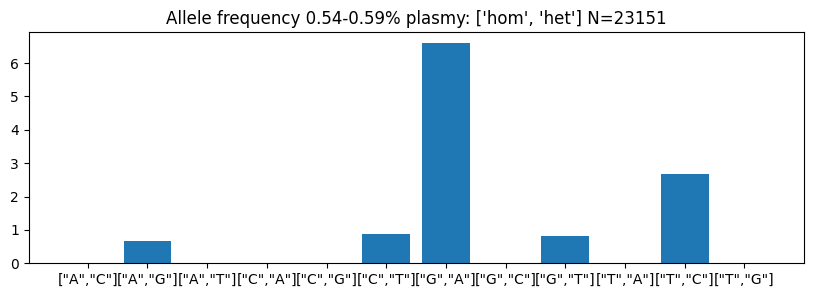

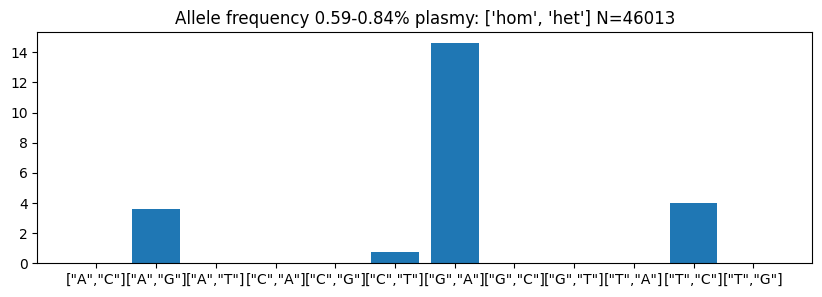

In [159]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search_helix(only_syn_helix_df_no_singletons)

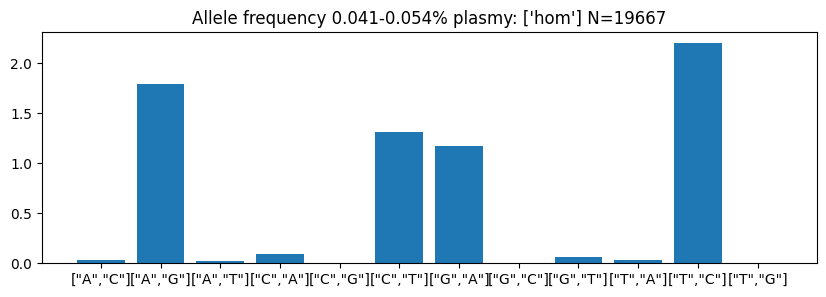

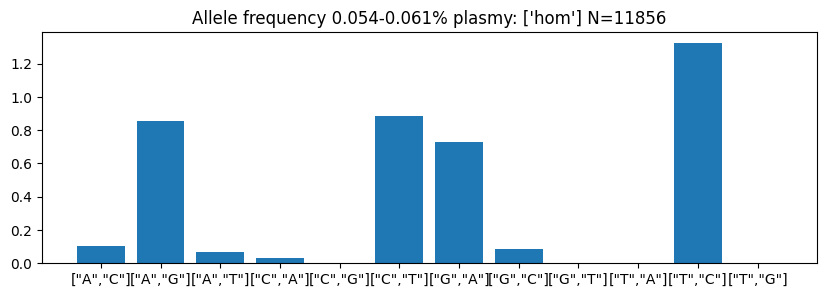

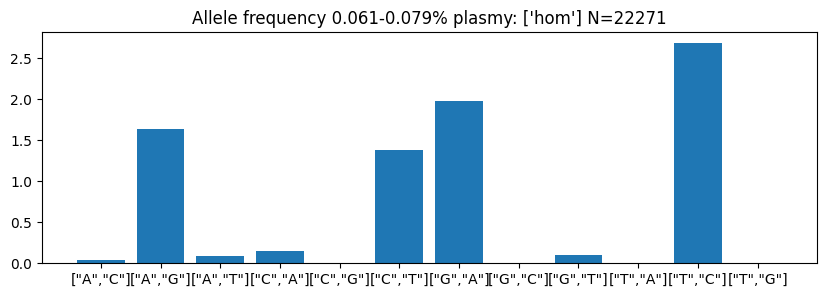

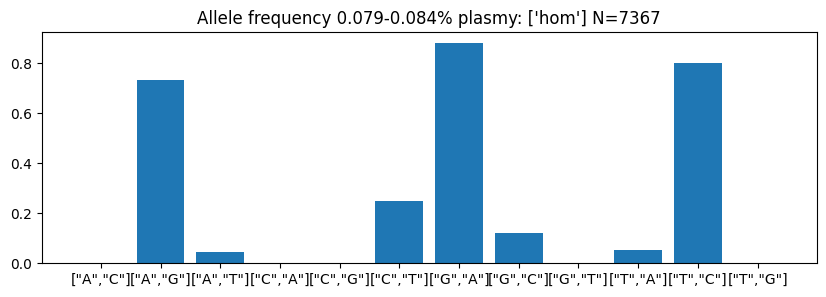

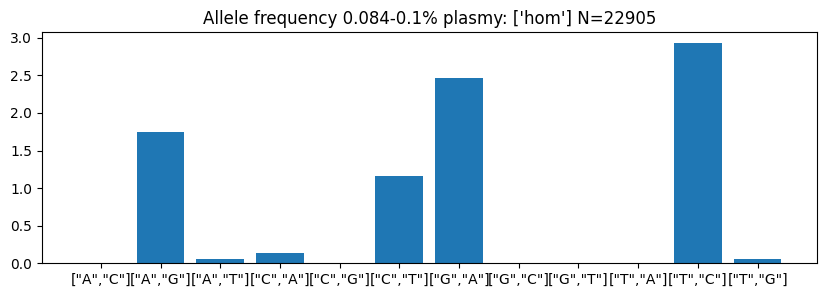

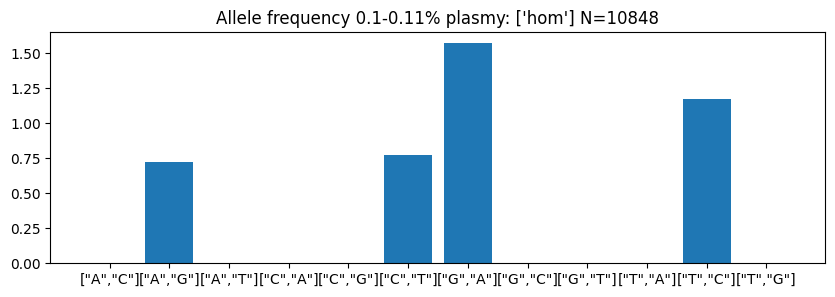

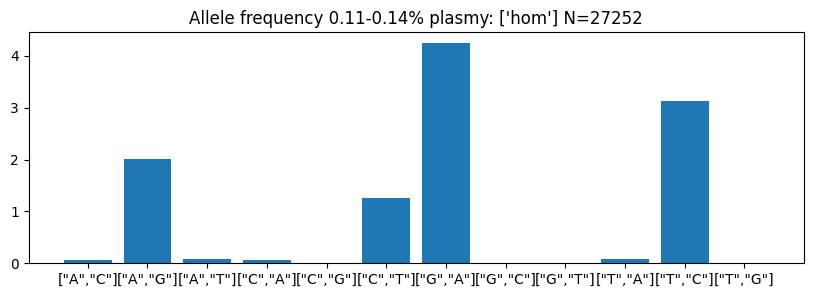

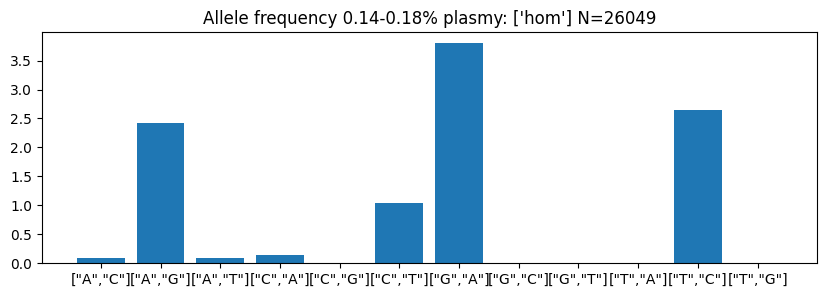

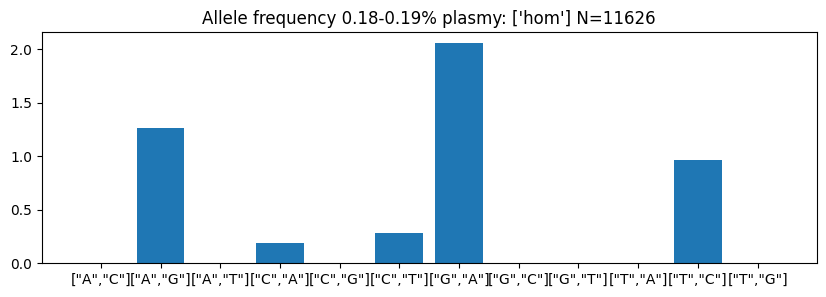

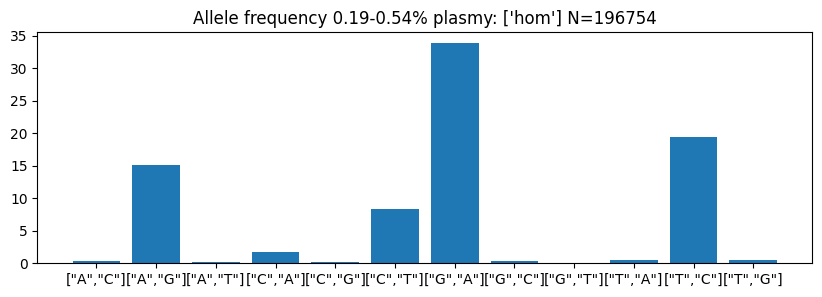

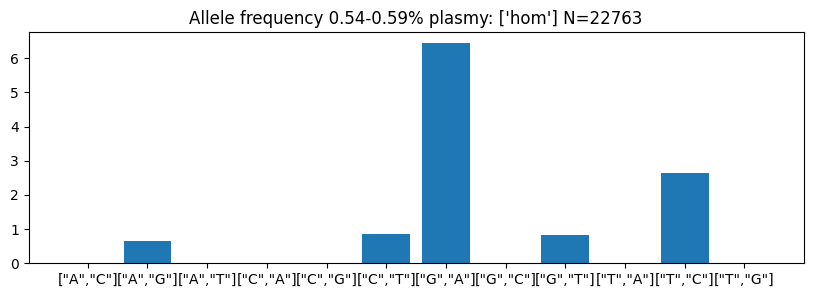

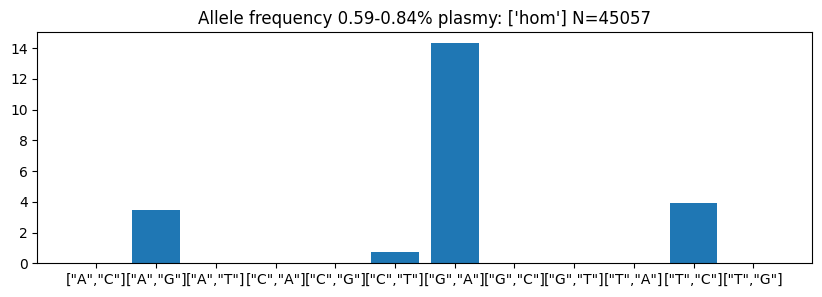

In [131]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search_helix(only_syn_helix_df_no_singletons, plasmy=['AC_hom'])

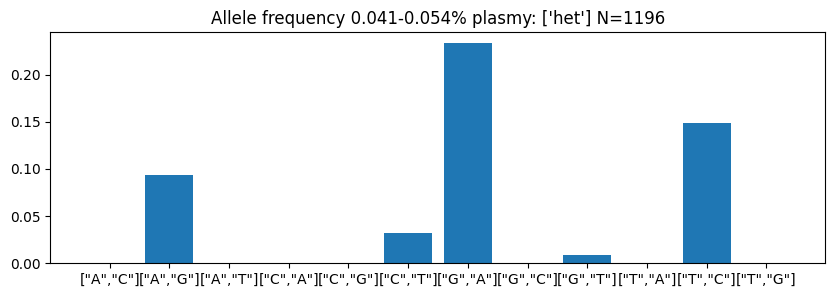

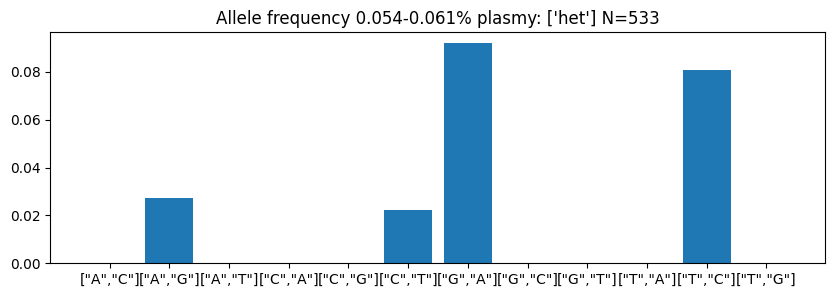

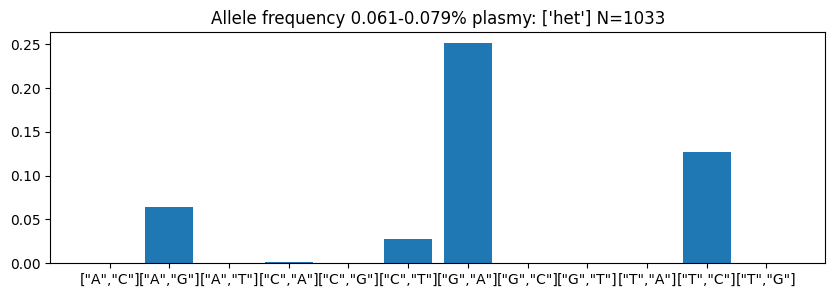

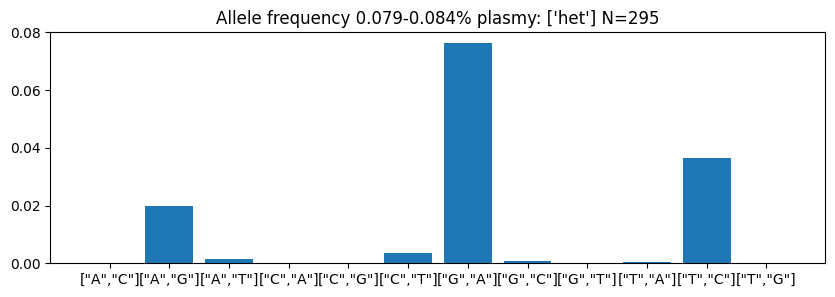

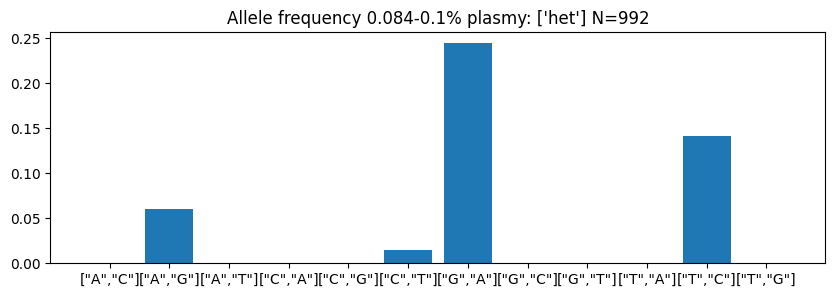

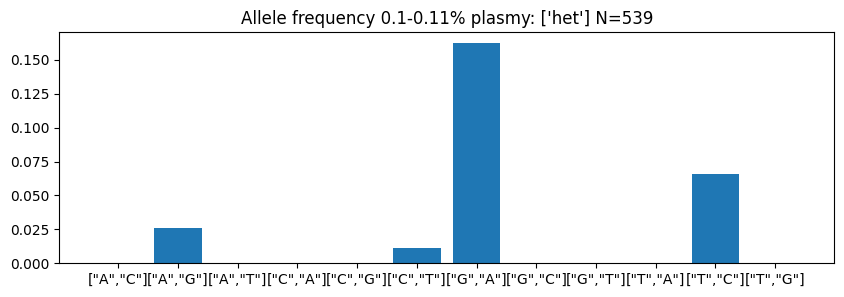

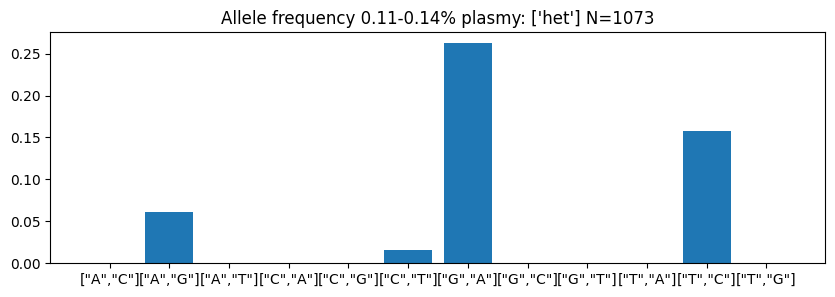

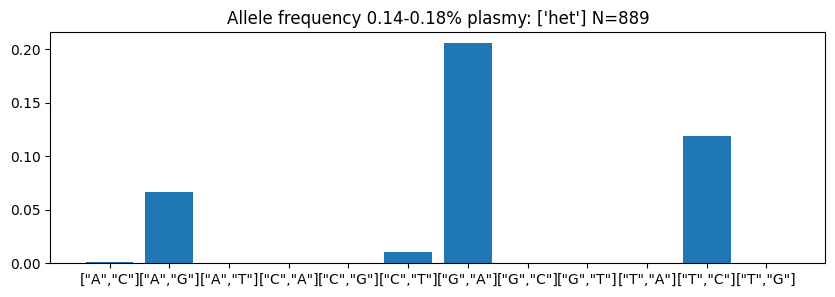

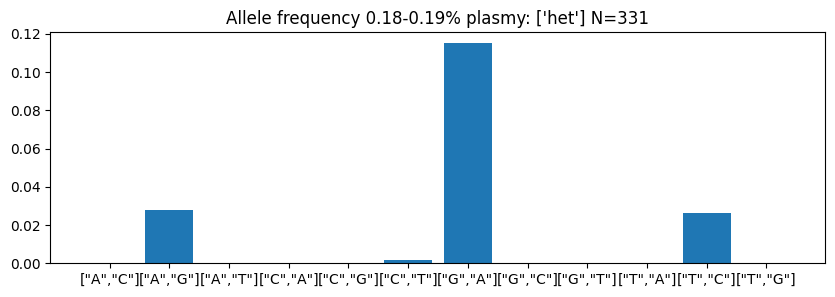

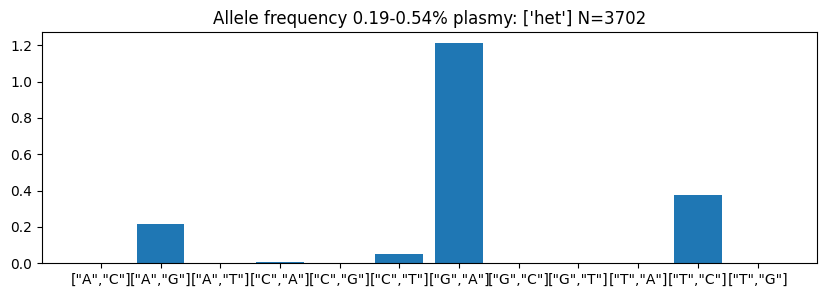

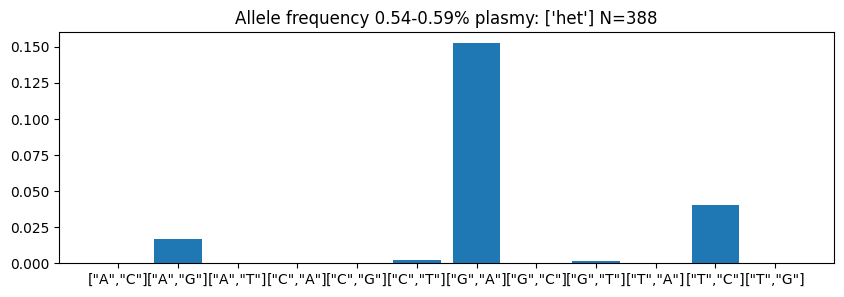

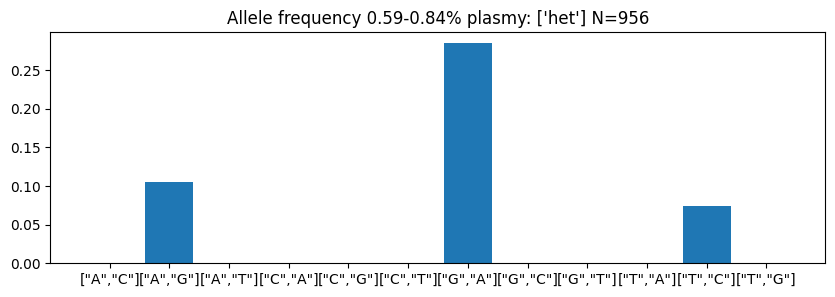

In [132]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search(only_syn_helix_df_no_singletons, plasmy=['AC_het'])

### No less than 10

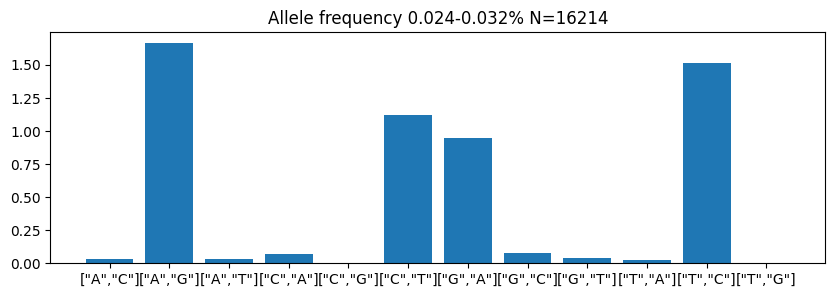

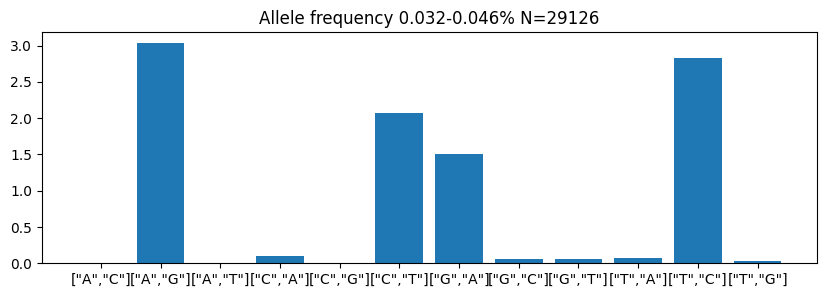

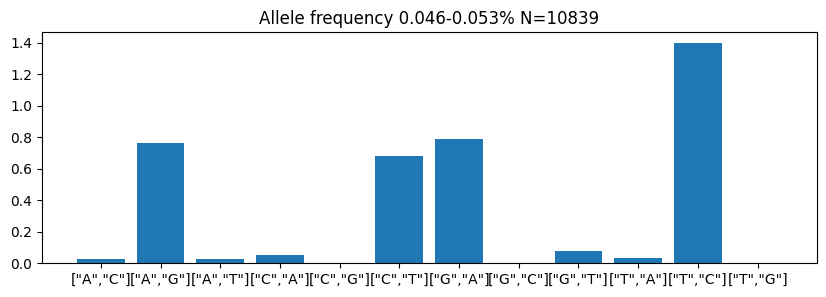

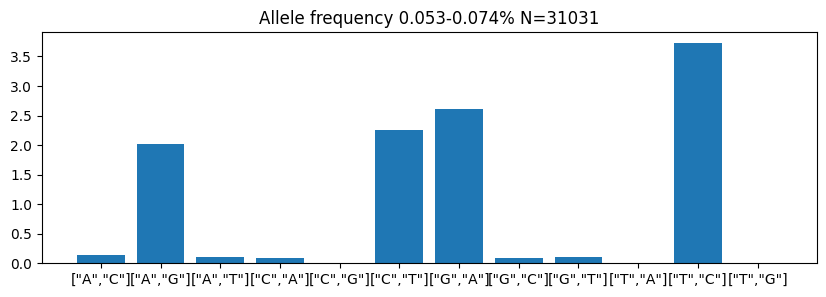

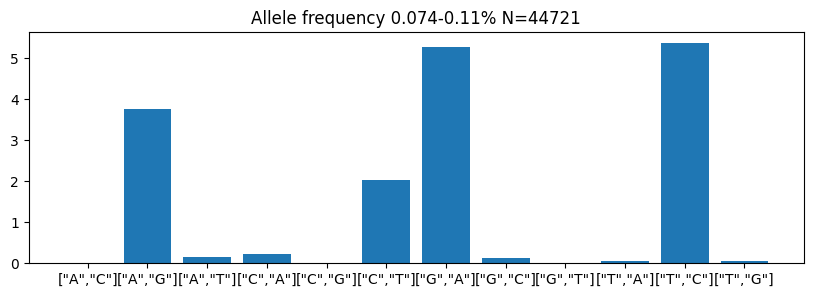

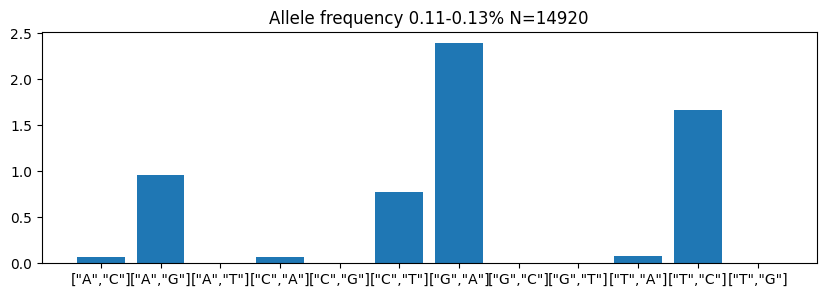

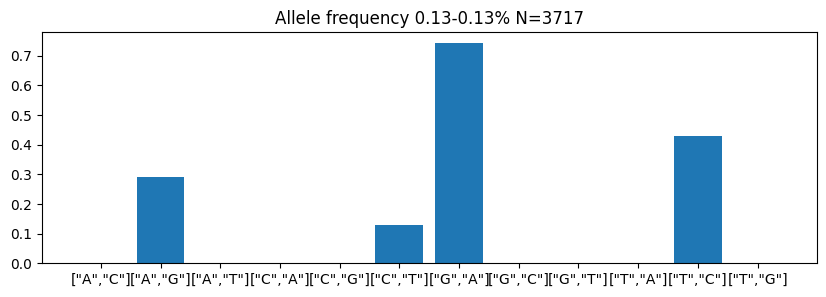

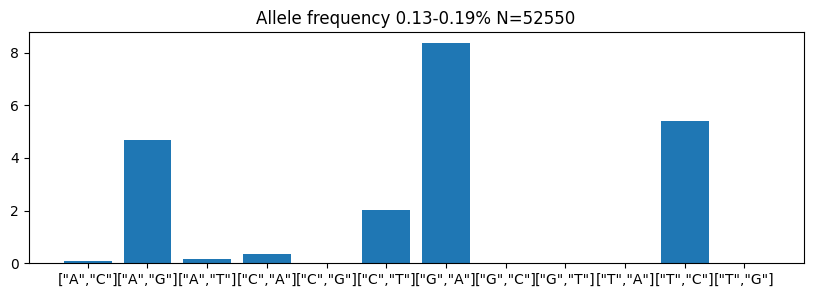

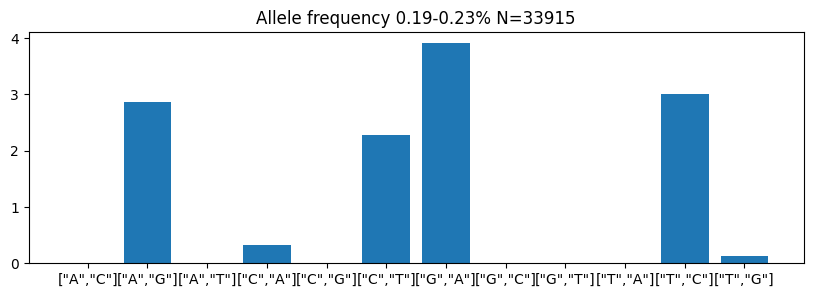

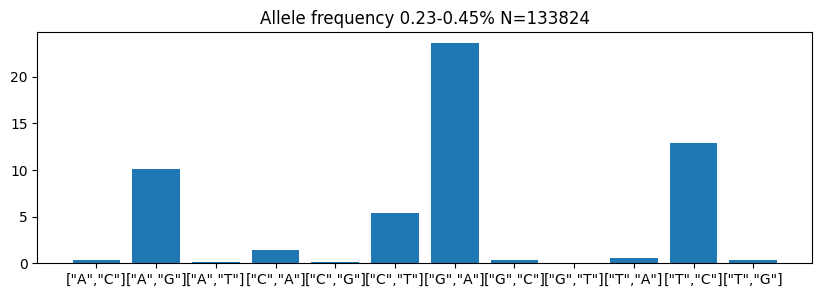

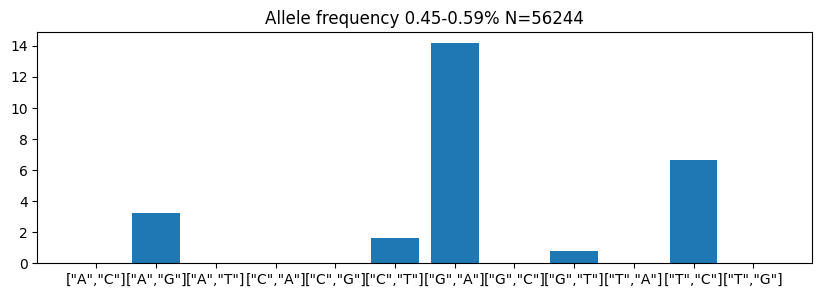

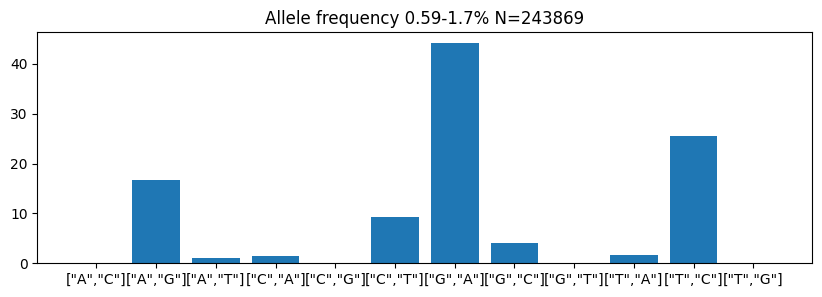

In [126]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search(only_syn_helix_df_no_less_10)

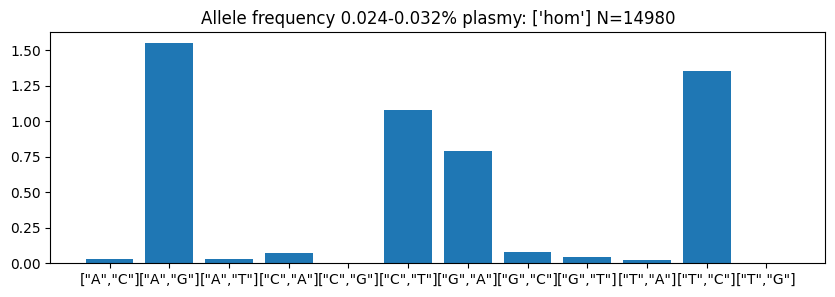

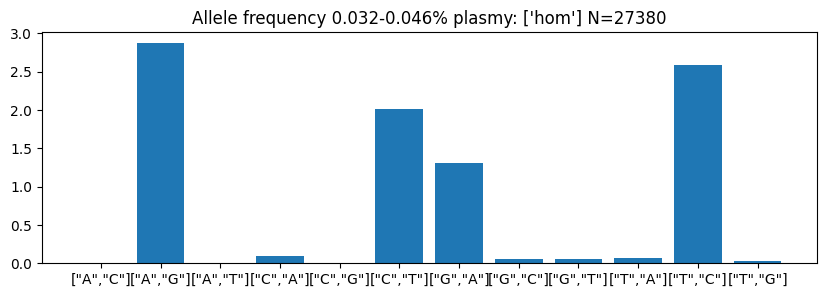

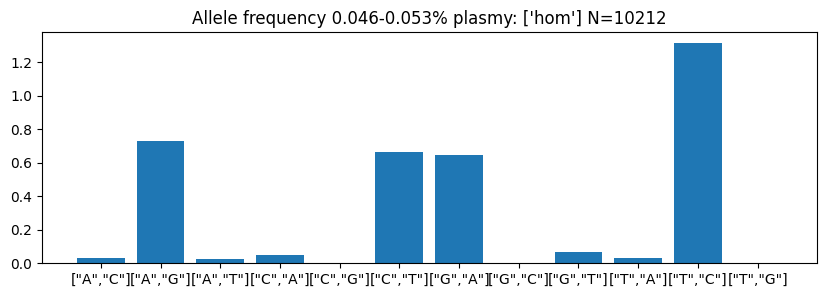

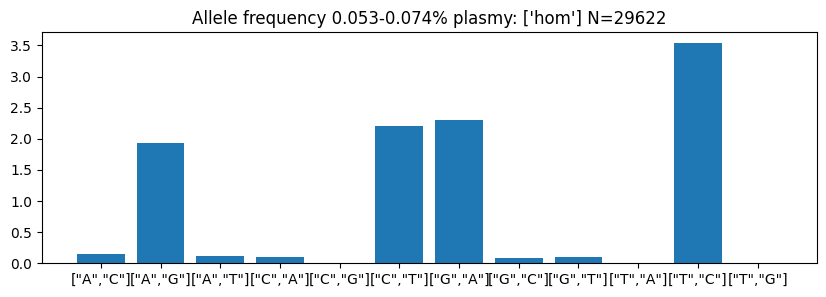

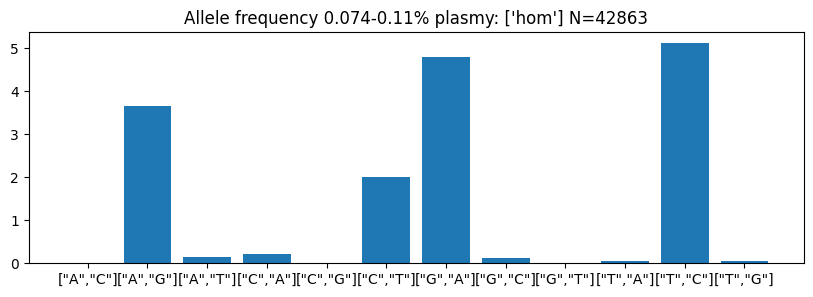

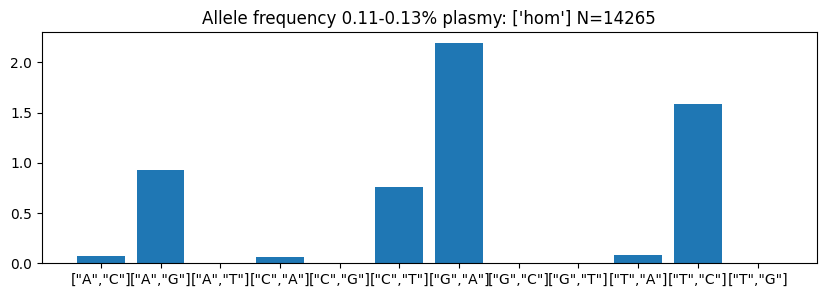

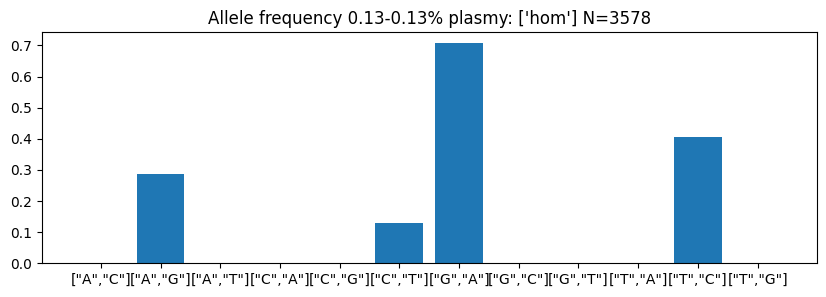

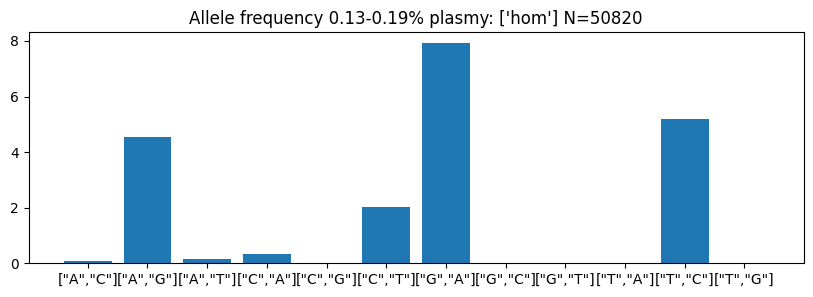

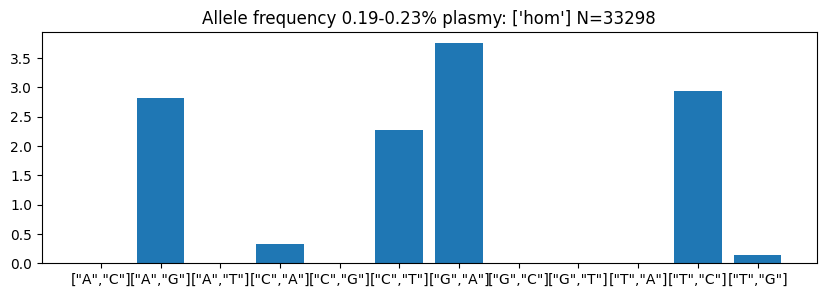

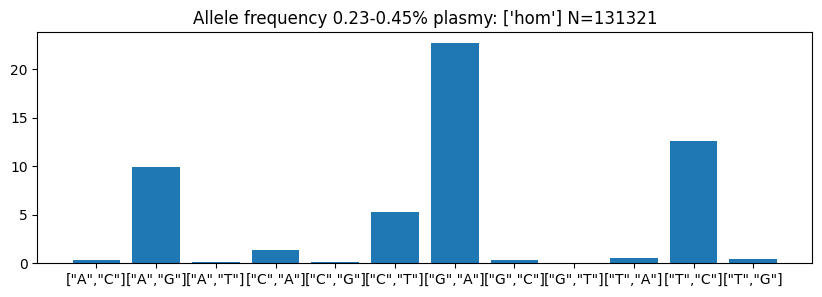

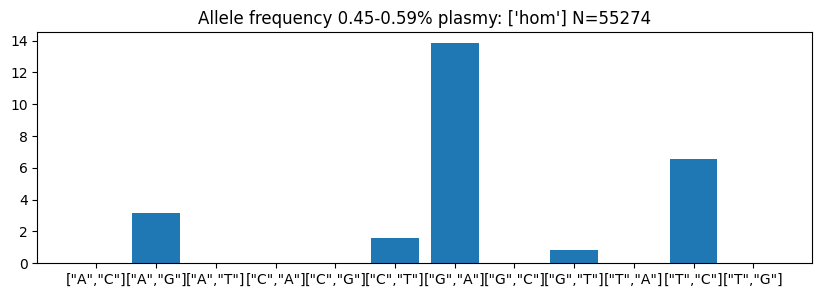

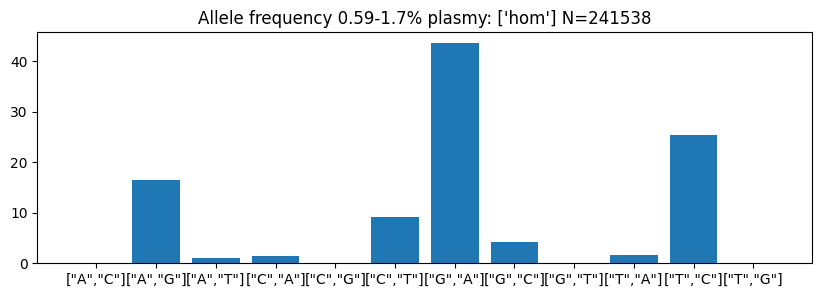

In [135]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search(only_syn_helix_df_no_less_10, plasmy=['AC_hom'])

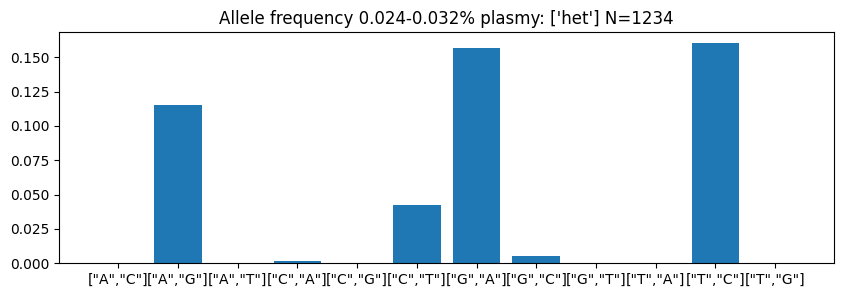

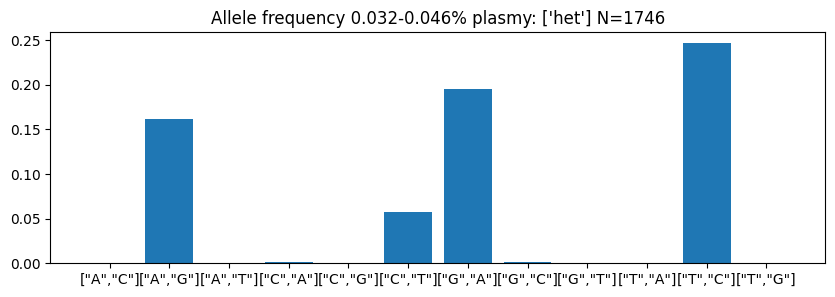

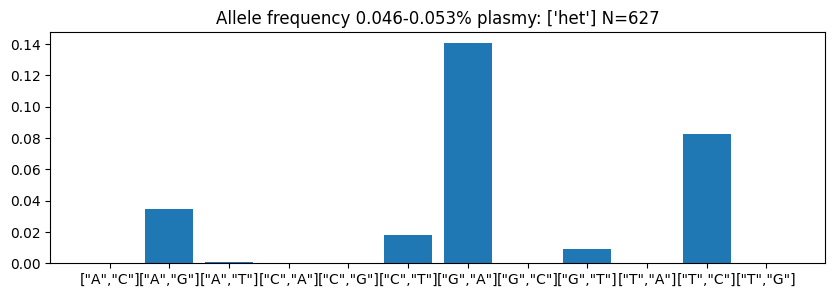

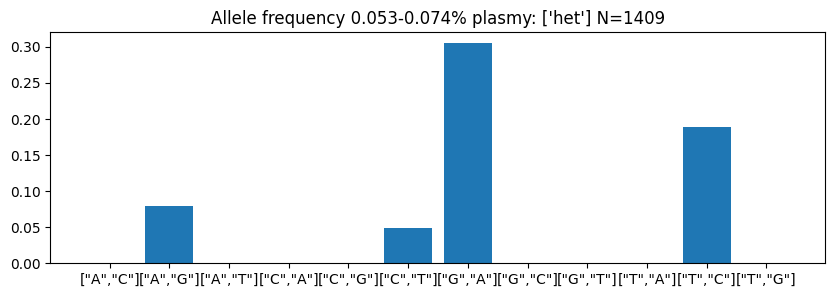

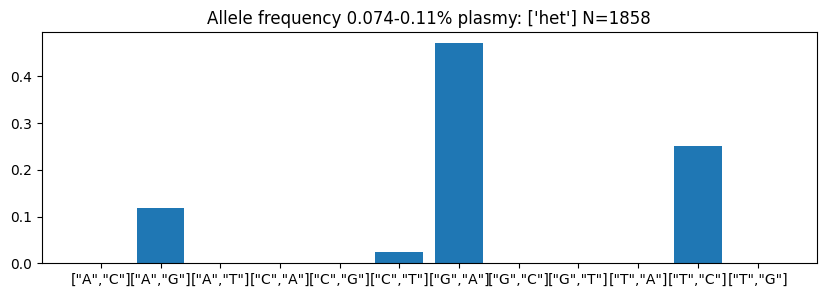

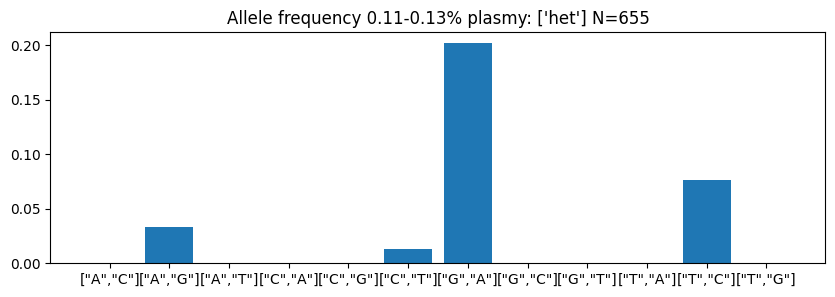

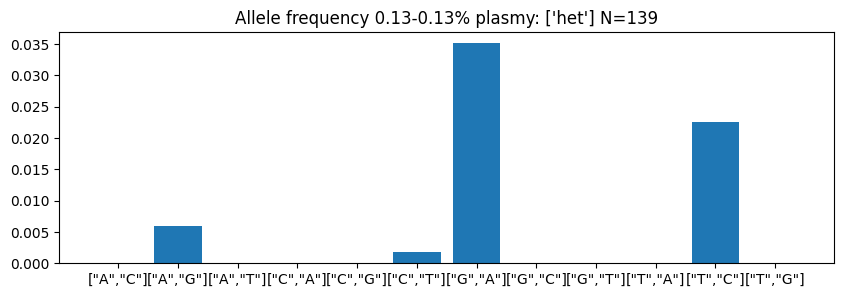

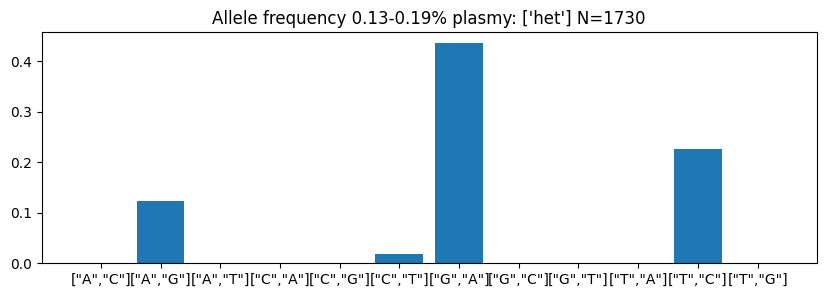

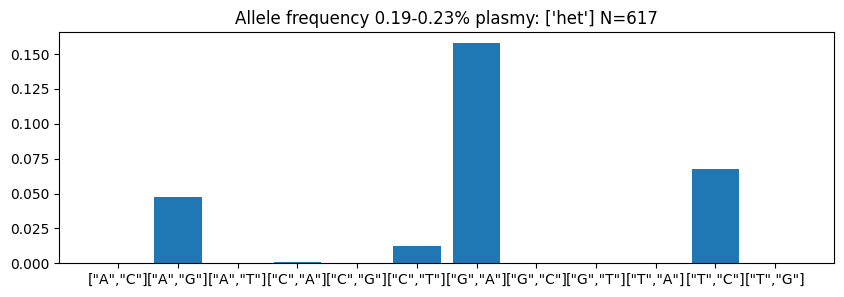

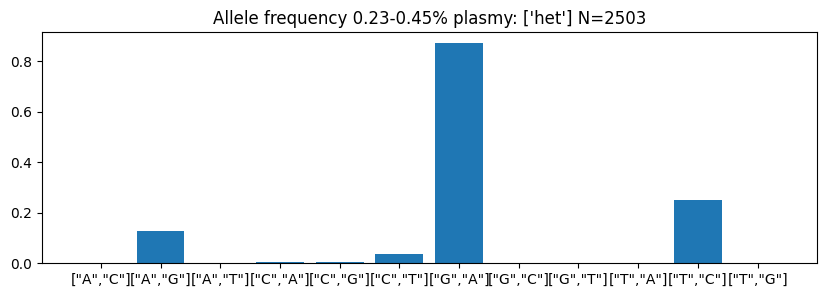

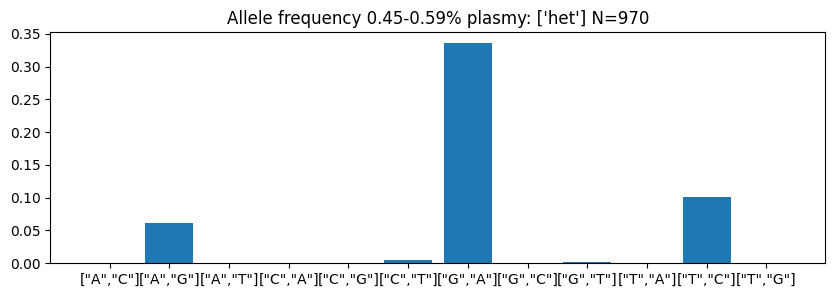

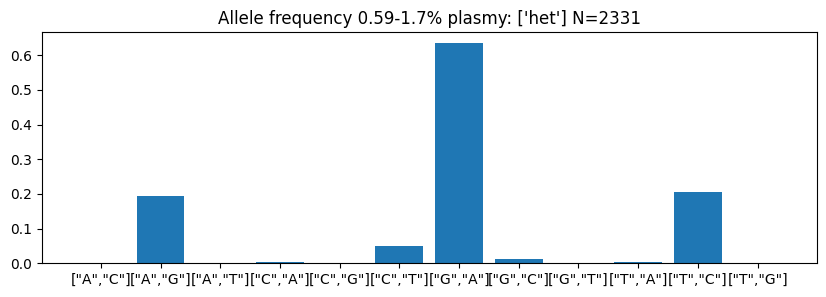

In [134]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search(only_syn_helix_df_no_less_10, plasmy=['AC_het'])

# gnomAD

In [ ]:
gnomad_samples_number = 56434
gnomad_df = pd.read_csv(r'..\\raw\gnomad.genomes.v3.1.sites.chrM.reduced_annotations.tsv', sep='\t').copy()
gnomad_df

chromosome  position ref     alt filters  AC_hom  AC_het    AF_hom  \
0           chrM         3   T       C    PASS      19       1  0.000337   
1           chrM         6   C  CCTCAA     npg       0       0  0.000000   
2           chrM         7   A       G     npg       0       0  0.000000   
3           chrM         8   G       T    PASS       5       0  0.000089   
4           chrM         9   G       A    PASS      15       0  0.000266   
...          ...       ...  ..     ...     ...     ...     ...       ...   
18159       chrM     16548   C       A     npg       0       0  0.000000   
18160       chrM     16558   G       A    PASS       1       0  0.000018   
18161       chrM     16559   A       G    PASS       3       0  0.000053   
18162       chrM     16560   C       T    PASS       1       0  0.000018   
18163       chrM     16566   G       A    PASS       7       0  0.000124   

         AF_het     AN  max_observed_heteroplasmy  
0      0.000018  56434                      0.997  
1      0.000000  56433                      0.000  
2      0.000000  56433                      0.000  
3      0.000000  56434                      0.999  
4      0.000000  56434                      0.993  
...         ...    ...                        ...  
18159  0.000000  56433                      0.000  
18160  0.000000  56434                      0.994  
18161  0.000000  56433                      0.997  
18162  0.000000  56434                      0.976  
18163  0.000000  56434                      0.990  

[18164 rows x 11 columns]

In [29]:
# moving to light chain
# gnomad_df = gnomad_hchain_df.copy()
# ref_lchain = [str(Seq(ref).complement()) for ref in gnomad_hchain_df.ref]
# alt_lchain = [str(Seq(ref).complement()) for ref in gnomad_hchain_df.alt]
# gnomad_df.ref = ref_lchain
# gnomad_df.alt = alt_lchain
# gnomad_df

In [12]:
only_subs_gnomad_df = gnomad_df[((gnomad_df.ref.apply(len)) == 1) & ((gnomad_df.alt.apply(len) == 1))]
only_subs_gnomad_df

chromosome  position ref alt filters  AC_hom  AC_het    AF_hom  \
0           chrM         3   T   C    PASS      19       1  0.000337   
2           chrM         7   A   G     npg       0       0  0.000000   
3           chrM         8   G   T    PASS       5       0  0.000089   
4           chrM         9   G   A    PASS      15       0  0.000266   
5           chrM        10   T   C    PASS      11       0  0.000195   
...          ...       ...  ..  ..     ...     ...     ...       ...   
18159       chrM     16548   C   A     npg       0       0  0.000000   
18160       chrM     16558   G   A    PASS       1       0  0.000018   
18161       chrM     16559   A   G    PASS       3       0  0.000053   
18162       chrM     16560   C   T    PASS       1       0  0.000018   
18163       chrM     16566   G   A    PASS       7       0  0.000124   

         AF_het     AN  max_observed_heteroplasmy  
0      0.000018  56434                      0.997  
2      0.000000  56433                      0.000  
3      0.000000  56434                      0.999  
4      0.000000  56434                      0.993  
5      0.000000  56434                      0.993  
...         ...    ...                        ...  
18159  0.000000  56433                      0.000  
18160  0.000000  56434                      0.994  
18161  0.000000  56433                      0.997  
18162  0.000000  56434                      0.976  
18163  0.000000  56434                      0.990  

[15770 rows x 11 columns]

## RefSeq

In [ ]:
refseq_gnomad = SeqIO.read(r"..\\raw\J01415.2.gb", "genbank")
# refseq_gnomad.seq = Seq(refseq_gnomad.seq).complement()  # It seems that this refseq is also on heavy chain as gnomad db


In [9]:
gnomad_cds = []
for refseq_gnomad_feature in refseq_gnomad.features:
    if refseq_gnomad_feature.type == 'CDS': #  ['source', 'D-loop', 'gene', 'misc_feature']
        gnomad_cds.append(refseq_gnomad_feature)
gnomad_cds

[SeqFeature(SimpleLocation(ExactPosition(3306), ExactPosition(4262), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(4469), ExactPosition(5511), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(5903), ExactPosition(7445), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(7585), ExactPosition(8269), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(8365), ExactPosition(8572), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(8526), ExactPosition(9207), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(9206), ExactPosition(9990), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(10058), ExactPosition(10404), strand=1), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(10469), ExactPosition(10766), strand=1), type='CDS', qualifiers=...),
 SeqFeature(Sim

In [23]:
# checking of substitutioning and reference bases match
for position in only_subs_gnomad_df.position:
    initial_base = only_subs_gnomad_df.loc[only_subs_gnomad_df.position==position, 'ref'].iloc[0]
    reference_base = refseq_gnomad.seq[position-1]
    if initial_base != reference_base:
        print(position, initial_base, reference_base)

In [10]:
# extraction of only synonymous variants
only_syn_gnomad_df = syn_subs_extracter(only_subs_gnomad_df, gnomad_cds, refseq_gnomad)
only_syn_gnomad_df

c:\Soft\Python\Lib\site-packages\Bio\Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


chromosome  position ref alt filters  AC_hom  AC_het    AF_hom  \
4306        chrM      3308   T   C    PASS    1609       5  0.028524   
4311        chrM      3311   C   T    PASS      13       0  0.000230   
4313        chrM      3314   T   C     npg       0       0  0.000000   
4318        chrM      3317   C   T    PASS       2       0  0.000035   
4323        chrM      3320   A   G    PASS      89       3  0.001577   
...          ...       ...  ..  ..     ...     ...     ...       ...   
17135       chrM     15884   G   C    PASS     825       0  0.014621   
17136       chrM     15885   C   G    PASS       1       0  0.000018   
17137       chrM     15885   C   T    PASS      26       2  0.000461   
17138       chrM     15886   C   A    PASS       1       0  0.000018   
17139       chrM     15886   C   T    PASS      26       1  0.000461   

         AF_het     AN  max_observed_heteroplasmy  
4306   0.000089  56409                      1.000  
4311   0.000000  56433                      0.999  
4313   0.000000  56433                      0.000  
4318   0.000000  56433                      1.000  
4323   0.000053  56430                      1.000  
...         ...    ...                        ...  
17135  0.000000  56427                      1.000  
17136  0.000000  56434                      0.982  
17137  0.000035  56431                      1.000  
17138  0.000000  56434                      0.987  
17139  0.000018  56431                      1.000  

[10384 rows x 11 columns]

In [11]:
# synonymous base usage
gnomad_base_freq = {base:0 for base in ['A', 'T', 'G', 'C']}
for cds in gnomad_cds:
    start = cds.location.start
    end = cds.location.end
    # gene_df = only_subs_gnomad_df.loc[(only_subs_gnomad_df.position > start) & (only_subs_gnomad_df.position < end)]
    sequence = refseq_gnomad.seq[start-1:end-1]
    for base in ['A', 'T', 'G', 'C']:
        gnomad_base_freq[base] += sequence.count(base)
gnomad_base_freq

{'A': 3392, 'T': 2879, 'G': 1338, 'C': 3786}

## Synonymous subs

In [129]:
only_syn_gnomad_df.groupby(['ref', 'alt']).sum(numeric_only=True)

position  AC_hom  AC_het    AF_hom    AF_het         AN  \
ref alt                                                            
A   C     3597604    1209      39  0.021424  0.000691   20763008   
    G    22621763  373295    1737  6.632146  0.030798  129666980   
    T     3478765    3688      42  0.065355  0.000744   20033878   
C   A     5500417   15889      71  0.281597  0.001258   31320479   
    G     1312887     376      13  0.006663  0.000230    6884852   
    T    24147943  205425     985  3.750883  0.017464  136328181   
G   A    10874026  191293    2202  3.397639  0.039048   63687884   
    C     2419600    3672      51  0.065080  0.000904   14672344   
    T      749108     458      15  0.008116  0.000266    4458179   
T   A     2233797    5076      24  0.089960  0.000425   13148555   
    C    22910605  172410    2302  3.058718  0.040802  132205252   
    G     2265008     676      24  0.012035  0.000425   12751623   

         max_observed_heteroplasmy  
ref alt                             
A   C                      152.622  
    G                     1718.797  
    T                      219.148  
C   A                      369.131  
    G                       75.977  
    T                     1956.689  
G   A                      484.130  
    C                       90.152  
    T                       33.922  
T   A                      109.290  
    C                     1091.717  
    G                       95.881

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_15200\1465825931.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.36792452830188677' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subs_number[sub_idx] /= gnomad_base_freq[sub_idx[0]]


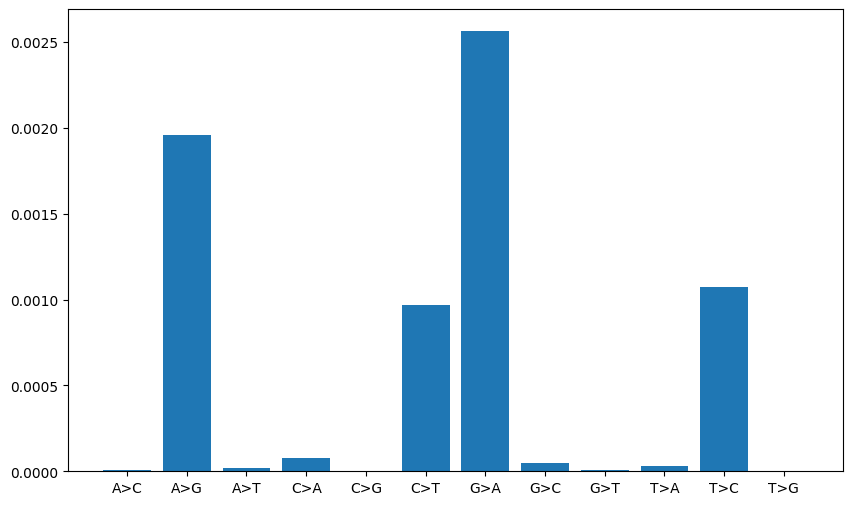

In [206]:
subs_number = only_syn_gnomad_df.groupby(['ref', 'alt']).sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
for sub_idx in subs_number.index:
    subs_number[sub_idx] /= gnomad_base_freq[sub_idx[0]]
    subs_number[sub_idx] /= gnomad_samples_number
plt.figure(figsize=(10,6))
plt.bar(x=substitutions, height=subs_number)
plt.show()

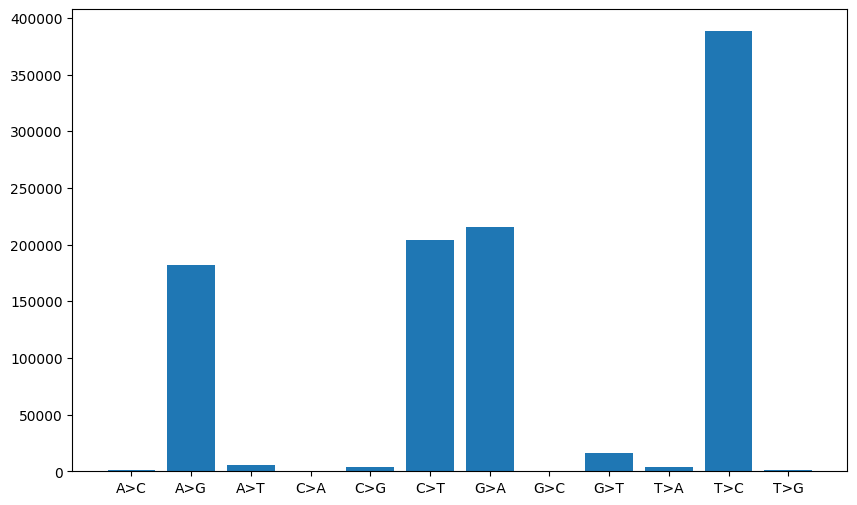

In [67]:
subs_number = only_syn_gnomad_df.groupby(['ref', 'alt']).sum(numeric_only=True).loc[:,['AC_hom', 'AC_het']].sum(axis=1)
plt.figure(figsize=(10,6))
plt.bar(x=[f'{idx[0]}>{idx[1]}' for idx in subs_number.index], height=subs_number)
plt.show()

In [125]:
np.logspace(-5, -3, 5)
# np.linspace(1e-5,)

array([1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
       1.00000000e-03])

In [75]:
def threshold_search_gnomad(gnomad_df, plasmy=['AC_hom', 'AC_het']):
    # freq_array = sorted(gnomad_df.loc[:,['AF_hom', 'AF_het']].sum(axis=1).unique()[::150])
    freq_array = np.logspace(-6, -1, 6)
    
    subs_freq_df = gnomad_df.loc[:,['AF_hom', 'AF_het']].sum(axis=1)
    for idx in range(len(freq_array)-1):
        threshold_lower = freq_array[idx] 
        threshold_upper = freq_array[idx+1]
        threshold_df = gnomad_df[(subs_freq_df >= threshold_lower) & (subs_freq_df < threshold_upper)]
        # if len(threshold_df) < 1:
        #     continue
        subs_number = threshold_df.groupby(['ref', 'alt']).sum(numeric_only=True).loc[:,plasmy].sum(axis=1)
        subs_length_checker(subs_number)
        subs_number_sum = subs_number.sum()
        for sub in subs_number.index:
            subs_number[sub] /= gnomad_base_freq[sub[1]] / 56434 / subs_number_sum
        
        plt.figure(figsize=(10,3))
        plt.bar(x=substitutions, height=subs_number)
        plt.title(f'Allele frequency {threshold_lower*100:.2}-{threshold_upper*100:.2}% plasmy: {[i[-3:] for i in plasmy]} N={subs_number_sum}')
        # plt.ylim(top=top)
        plt.show()

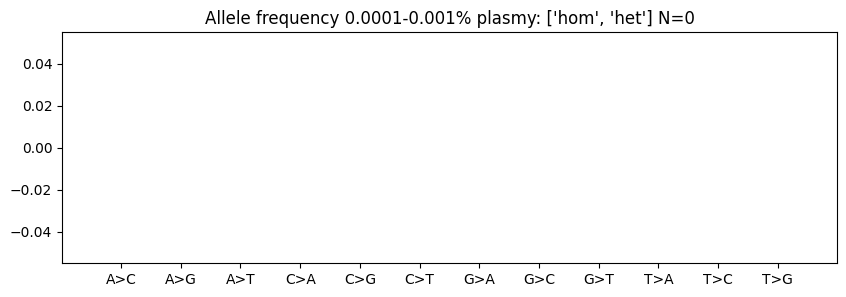

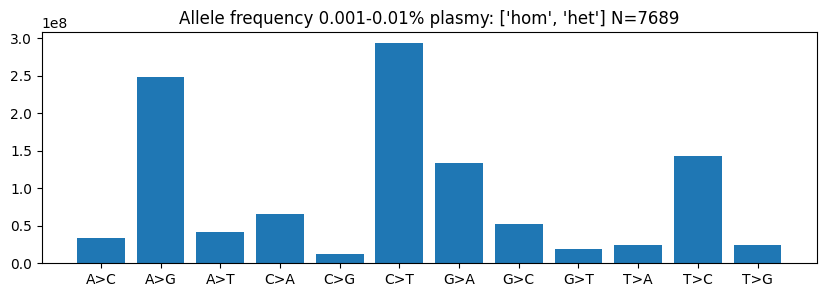

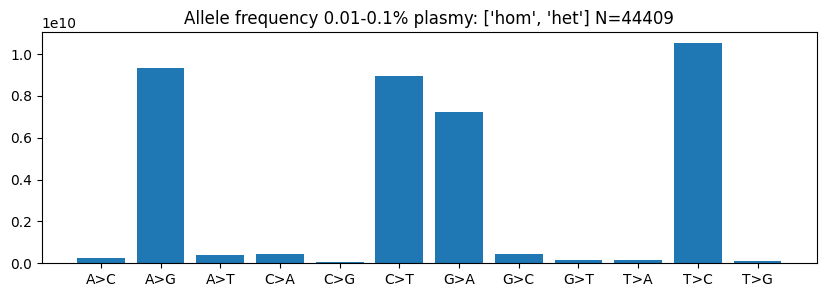

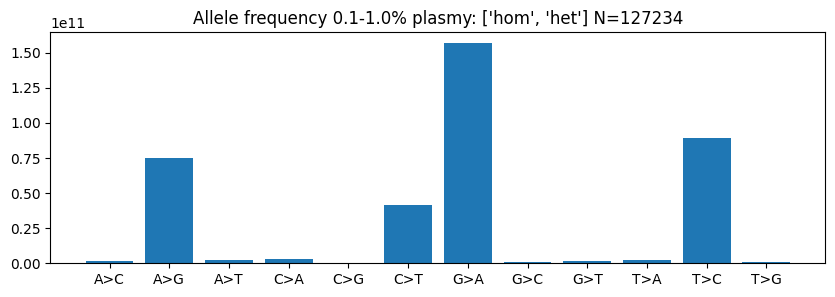

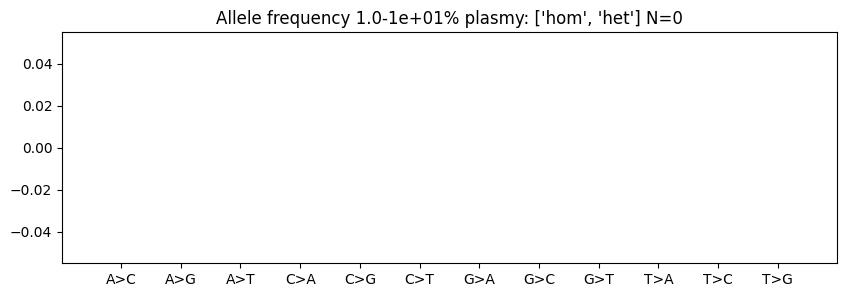

In [76]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search_gnomad(only_syn_gnomad_df)

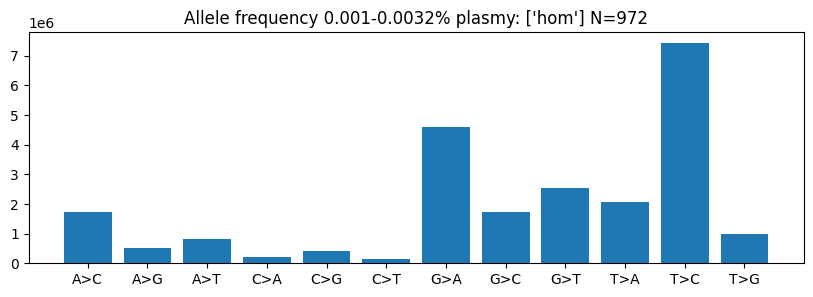

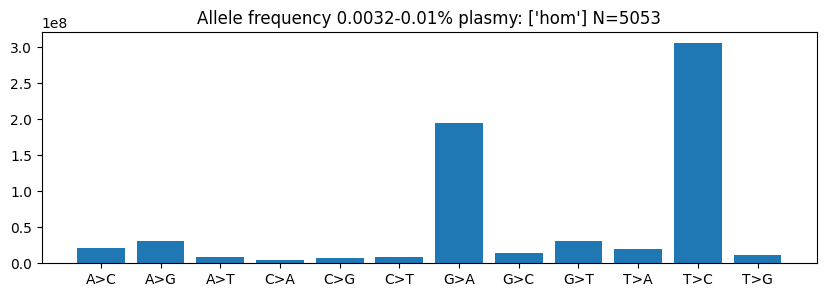

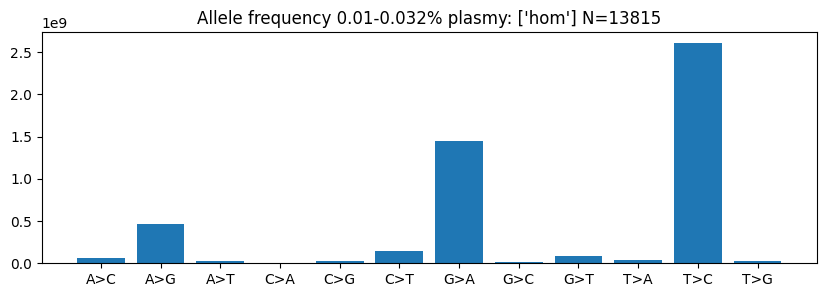

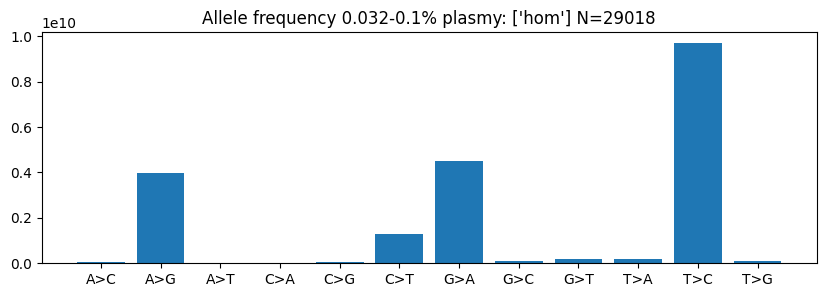

In [128]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search_gnomad(only_syn_gnomad_df, plasmy=['AC_hom'])

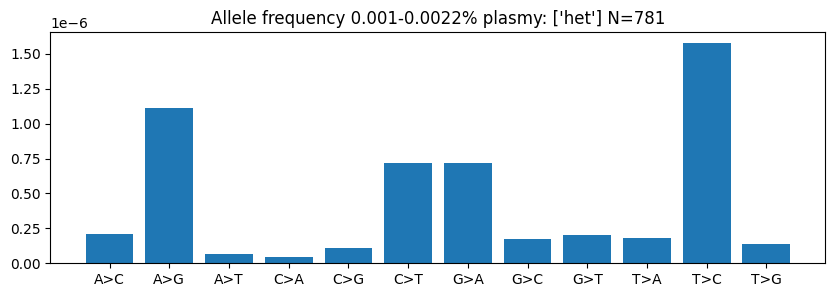

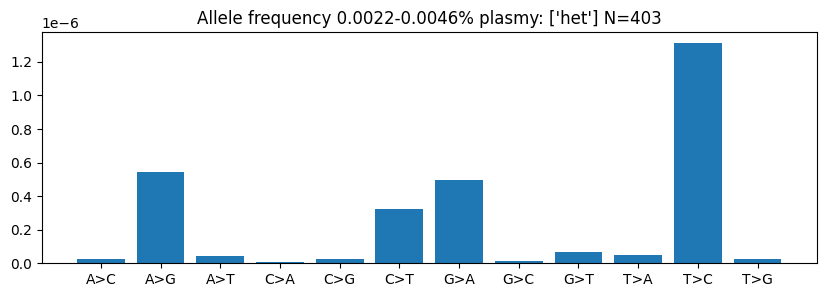

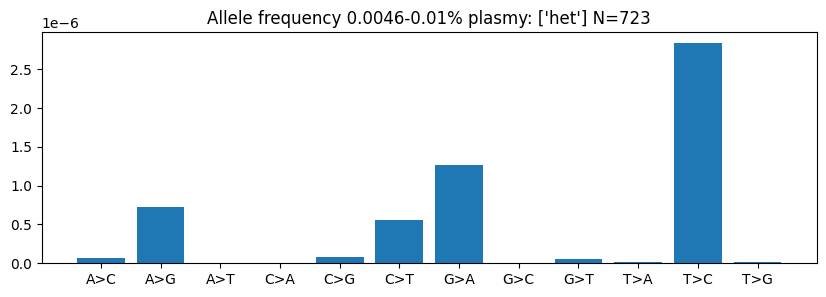

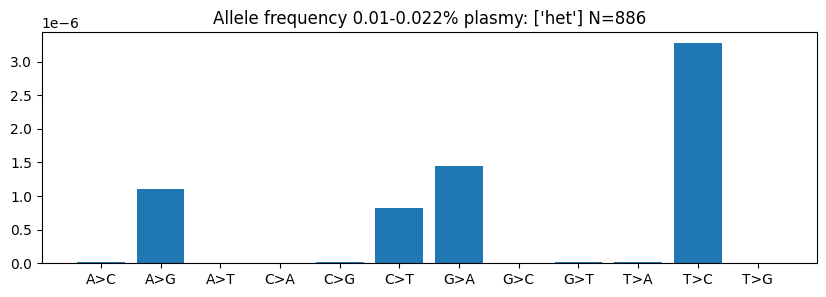

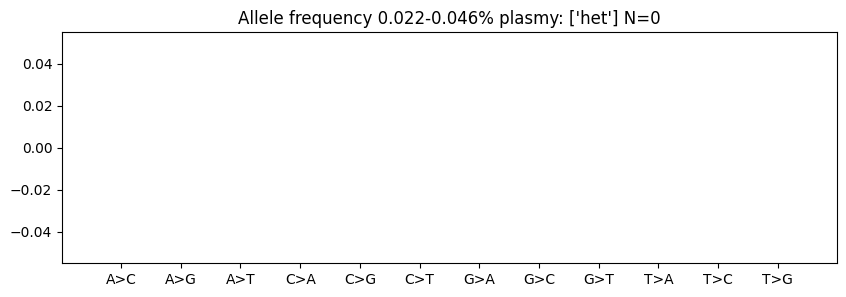

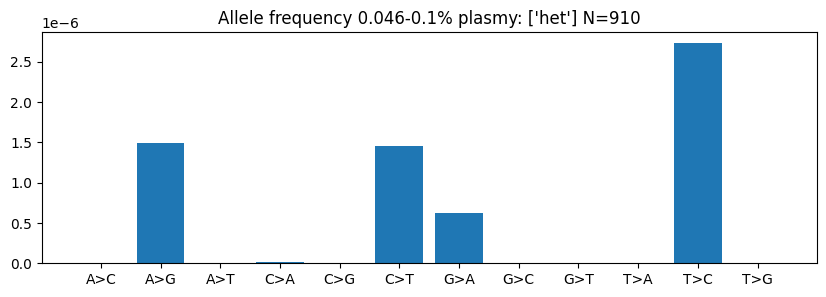

In [111]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search_gnomad(only_syn_gnomad_df, plasmy=['AC_het'])

In [89]:
plasmy=['AC_hom', 'AC_hom']
# subs_number = only_syn_gnomad_df.groupby(['ref', 'alt']).sum(numeric_only=True).loc[:,plasmy].sum(axis=1)
# subs_number
subs_freq_df = only_syn_gnomad_df.loc[:,['AF_hom', 'AF_het']].sum(axis=1)
threshold_df = only_syn_gnomad_df[(subs_freq_df >= 0.01) & (subs_freq_df < 0.1)]
subs_number = threshold_df.groupby(['ref', 'alt']).sum(numeric_only=True).loc[:,plasmy].sum(axis=1)
subs_number['A','C'] = 0
subs_number = threshold_df.groupby(['ref', 'alt']).sum(numeric_only=True).loc[:,plasmy].sum(axis=1)
subs_number

ref  alt
A    G      173628
     T        3896
C    A       13856
     T       79682
G    A      187586
     C        6356
T    A        7884
     C      169520
dtype: int64

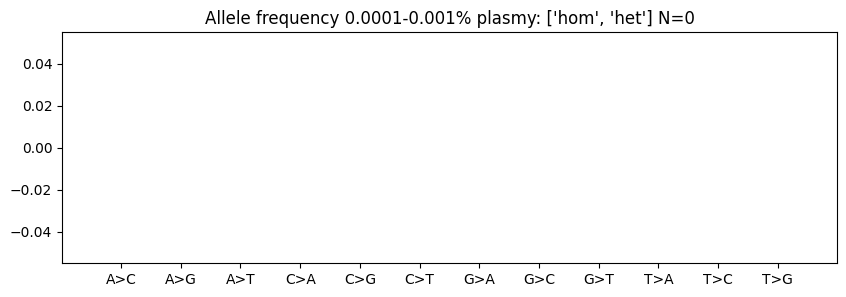

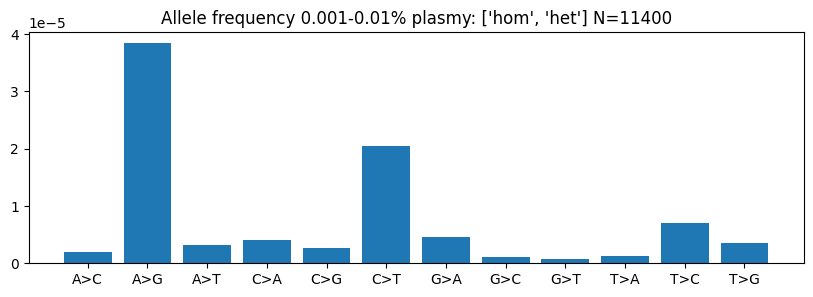

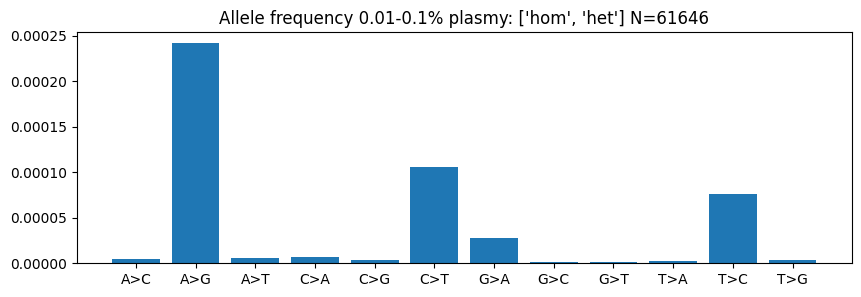

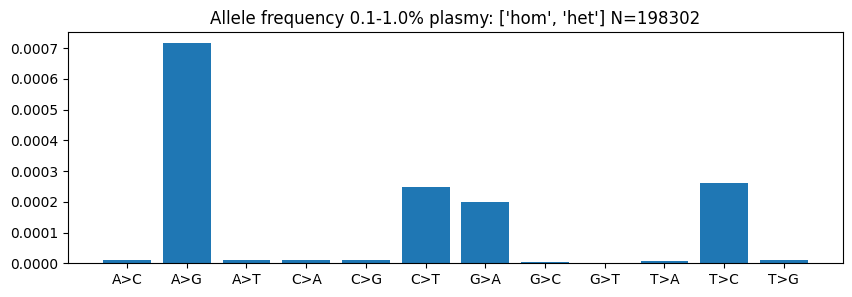

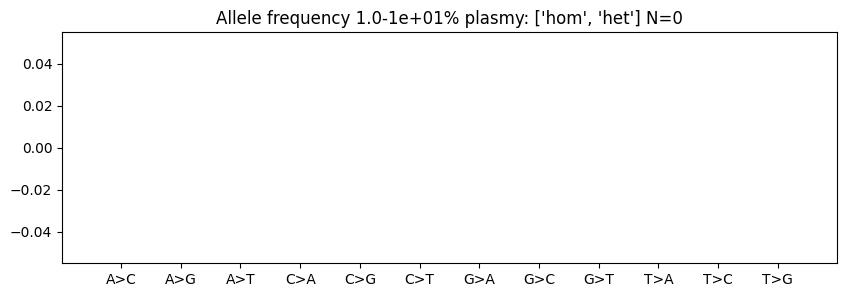

In [154]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search_gnomad(only_subs_gnomad_df)

# Clear comparison

## Purification

In [148]:
only_syn_helix_df_pured = {i:None for i in range(1, 21)}
for exception in only_syn_helix_df_pured:
    only_syn_helix_df_pured[exception] = only_syn_helix_df[only_syn_helix_df.loc[:,['AC_hom', 'AC_het']].sum(axis=1) > exception]
# from singletons are 0.00032-0.001%
# from 2-number to 6-number subs are 0.001-0.0032%
# from 6-number to 19-number subs are in 0.0032-0.01%

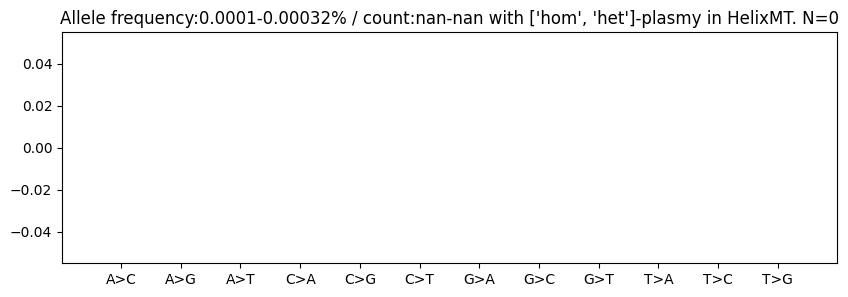

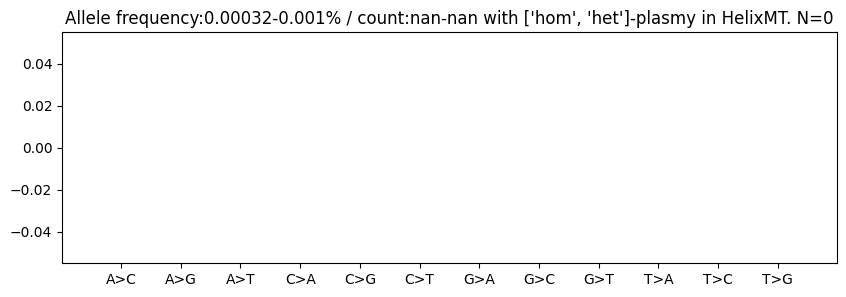

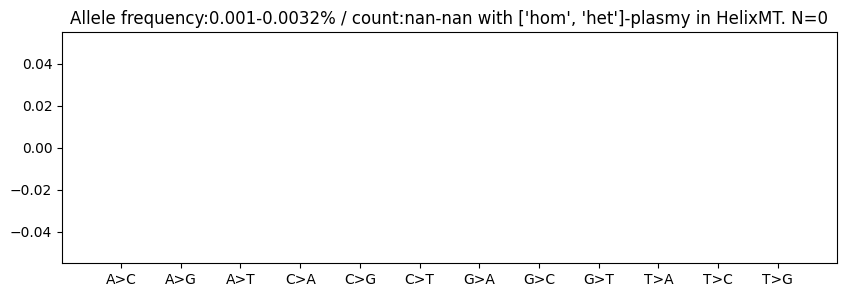

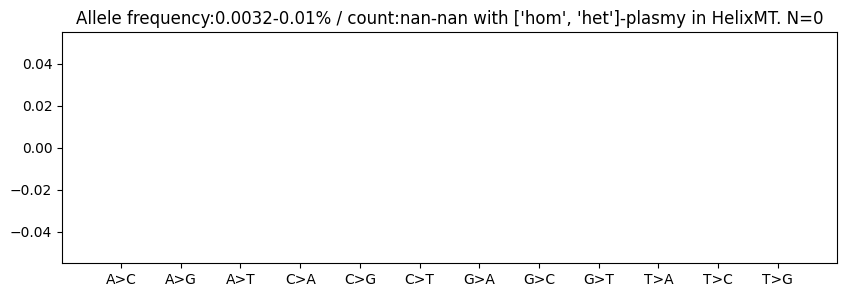

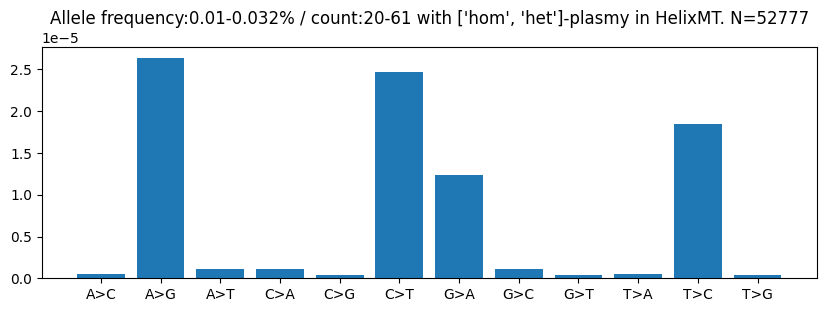

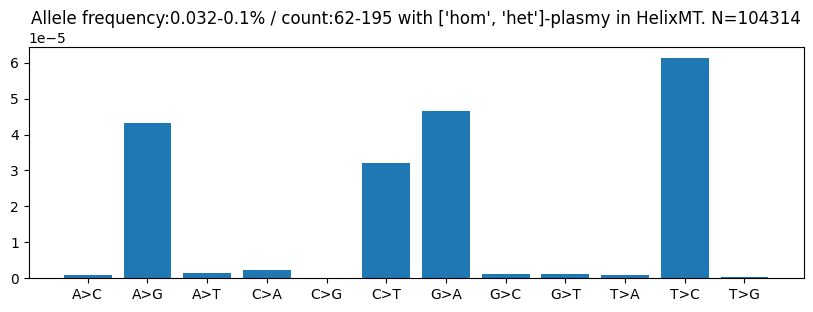

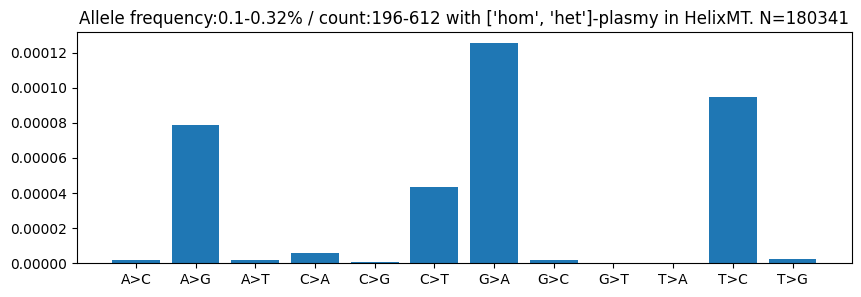

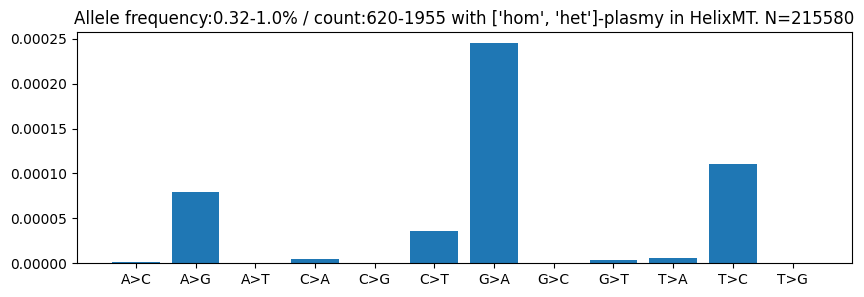

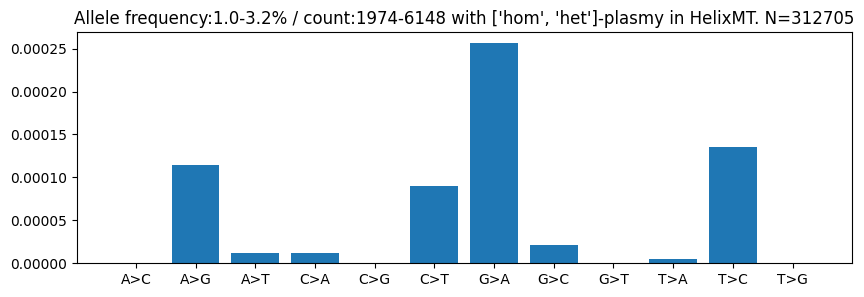

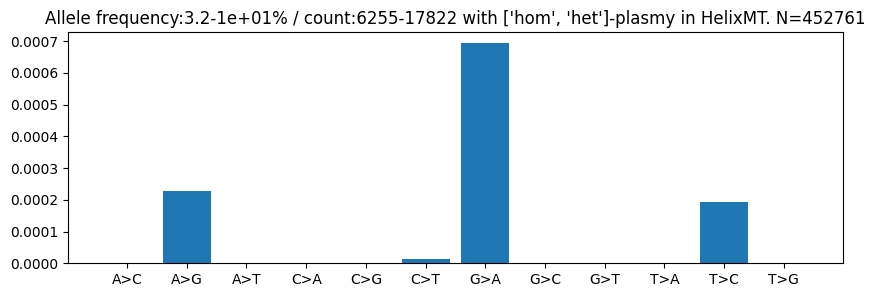

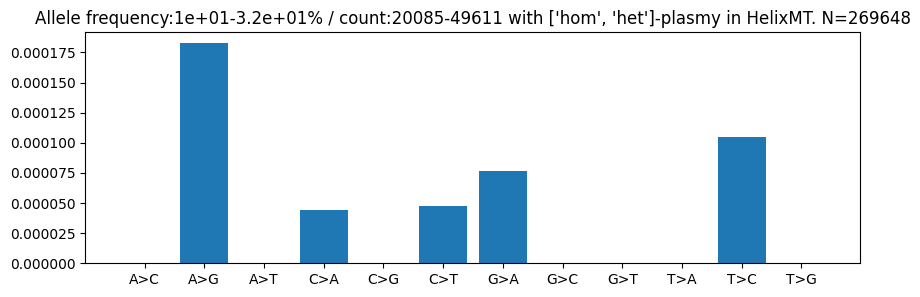

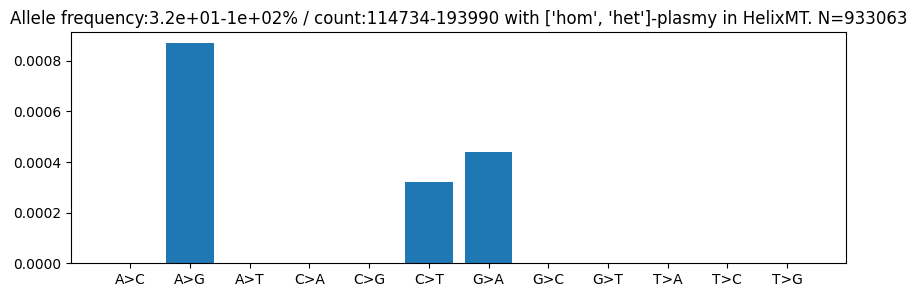

In [192]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search(only_syn_helix_df_pured[19], helix_base_freq, 
                     db_samples_number=helix_samples_number, 
                     db_name='HelixMT')

In [131]:
only_syn_gnomad_df_pured = {i:None for i in range(1, 11)}
for exception in only_syn_gnomad_df_pured:
    only_syn_gnomad_df_pured[exception] = only_syn_helix_df[only_syn_helix_df.loc[:,['AC_hom', 'AC_het']].sum(axis=1) >= exception]
# singletons are 0.001-0.0032%
# 2-5 

## gnomAD

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_23892\2012070042.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.519554316580196e-06' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  allele_freqs[sub_idx] = subs_number[sub_idx] / db_base_freq[sub_idx[0]] / db_samples_number


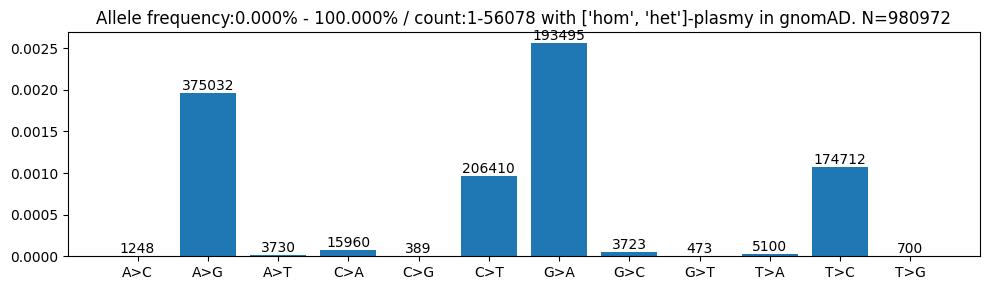

In [30]:
# Total
threshold_search_pb(only_syn_gnomad_df, gnomad_base_freq, 
                 db_samples_number=gnomad_samples_number, 
                 db_name='gnomAD', 
                 threshold_array=np.logspace(-6, 0, 2))

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_23892\2012070042.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.315818244187065e-06' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  allele_freqs[sub_idx] = subs_number[sub_idx] / db_base_freq[sub_idx[0]] / db_samples_number


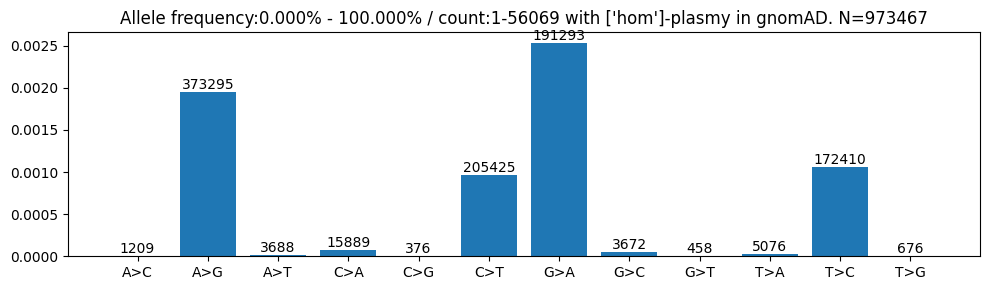

In [31]:
# Total hom
threshold_search_pb(only_syn_gnomad_df, gnomad_base_freq, 
                 db_samples_number=gnomad_samples_number, 
                 plasmy=['AC_hom'], db_name='gnomAD', 
                 threshold_array=np.logspace(-6, 0, 2))

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_23892\2012070042.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.0373607239313111e-07' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  allele_freqs[sub_idx] = subs_number[sub_idx] / db_base_freq[sub_idx[0]] / db_samples_number


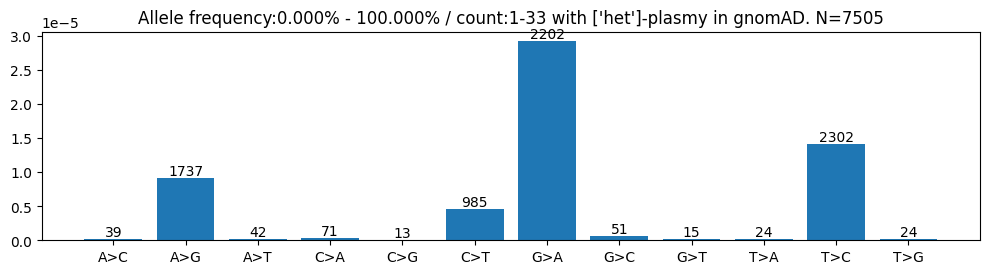

In [32]:
# Total het
threshold_search_pb(only_syn_gnomad_df, gnomad_base_freq, 
                 db_samples_number=gnomad_samples_number, 
                 plasmy=['AC_het'], db_name='gnomAD', 
                 threshold_array=np.logspace(-6, 0, 2))

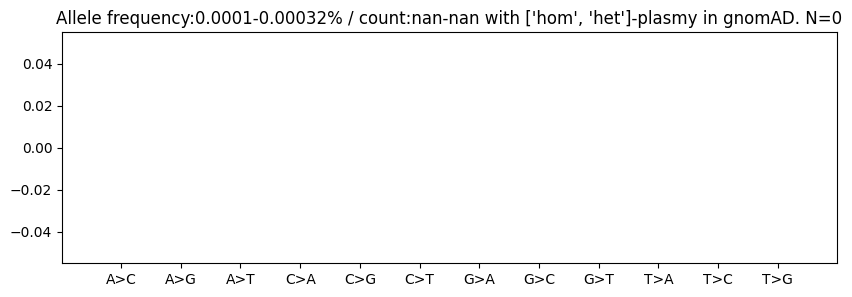

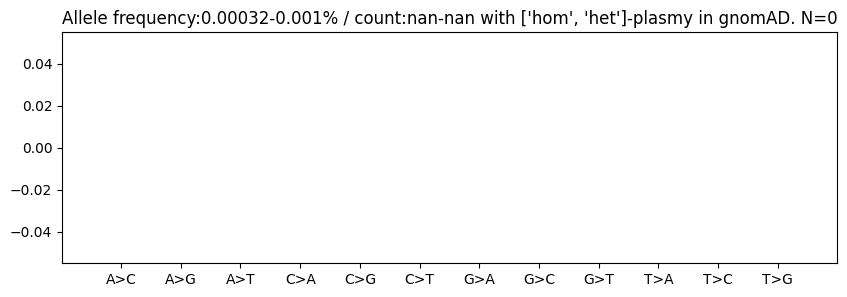

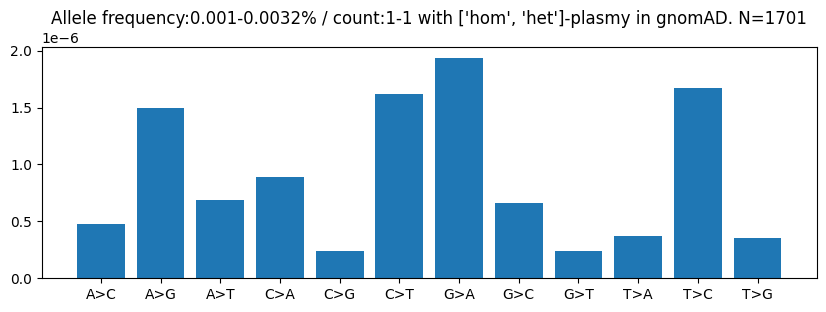

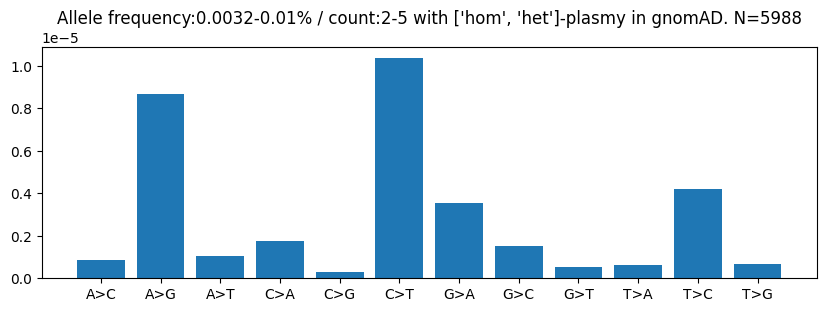

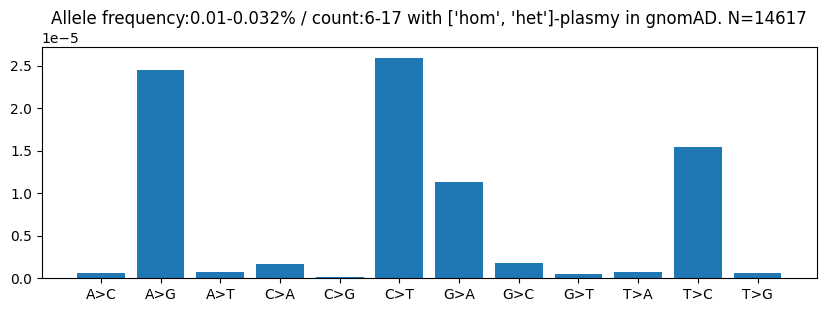

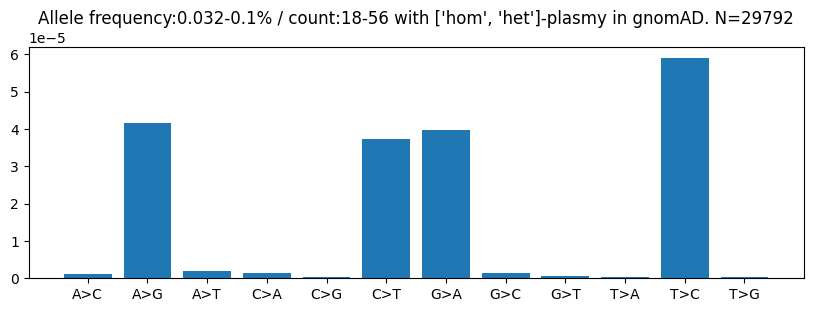

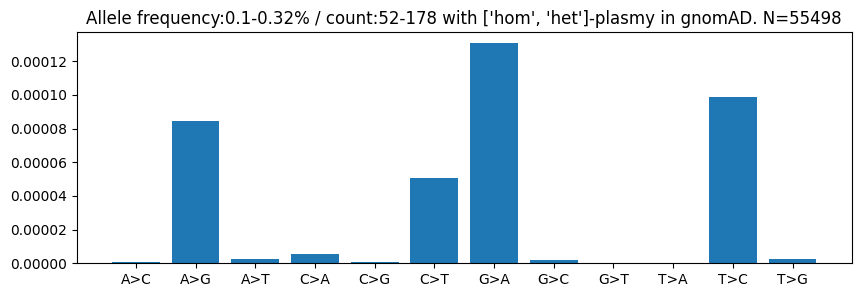

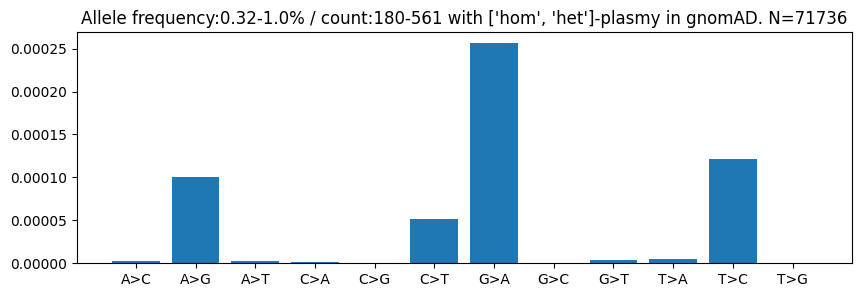

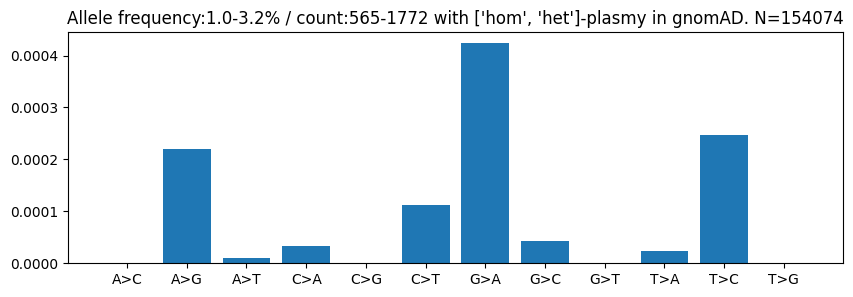

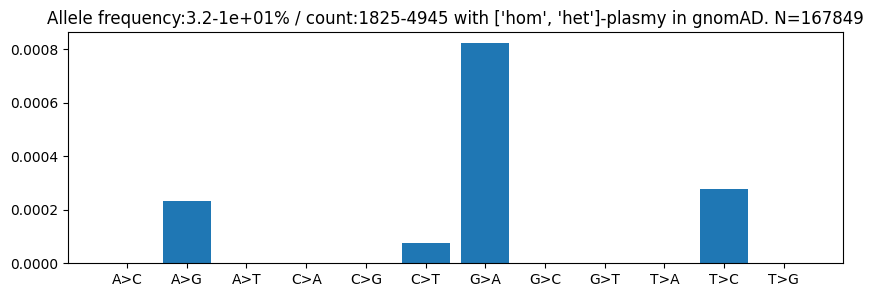

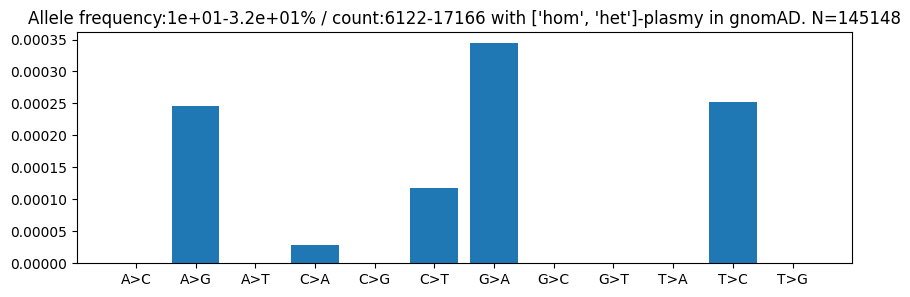

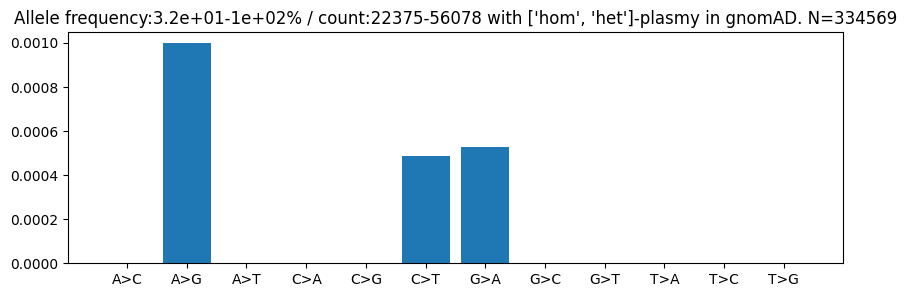

In [203]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search(only_syn_gnomad_df, gnomad_base_freq, 
                     db_samples_number=gnomad_samples_number, 
                     db_name='gnomAD')

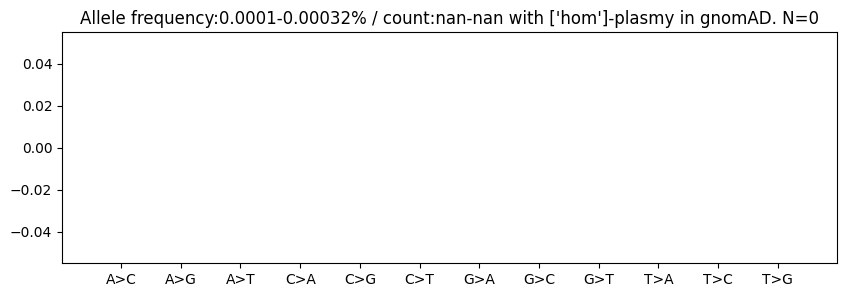

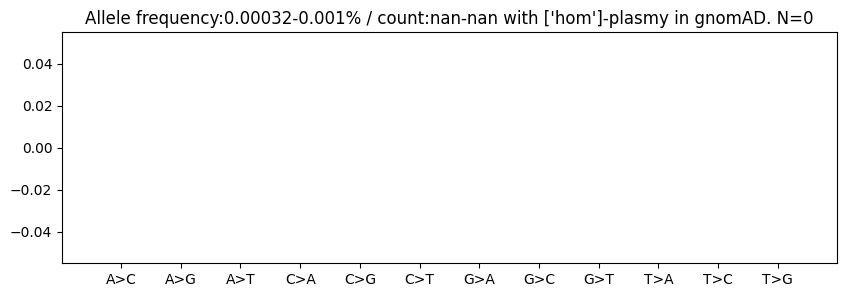

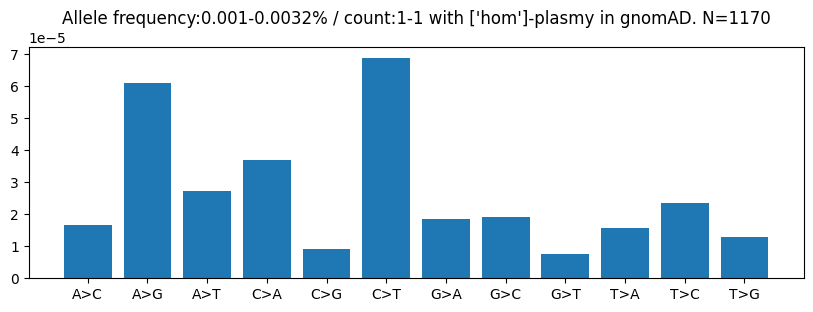

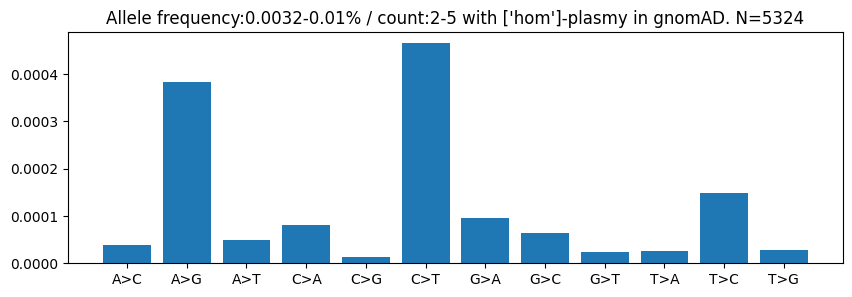

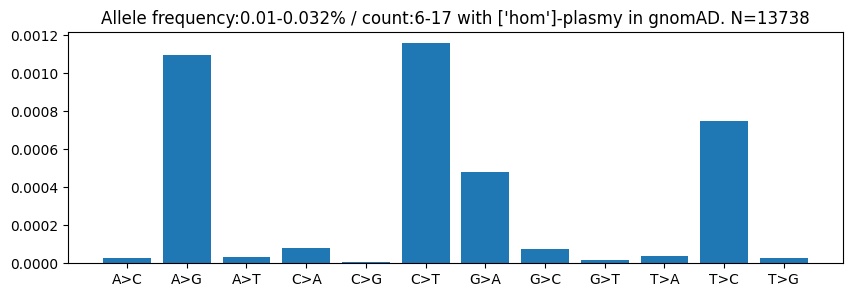

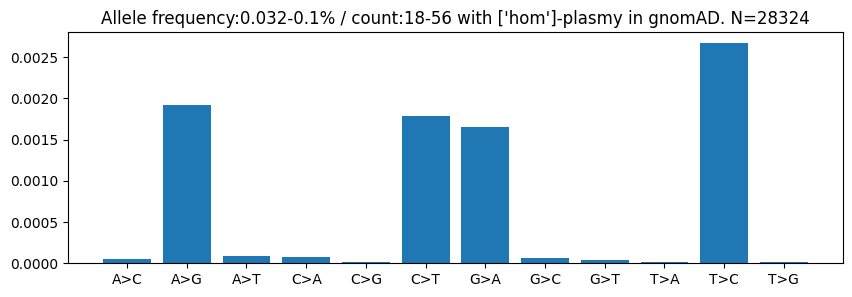

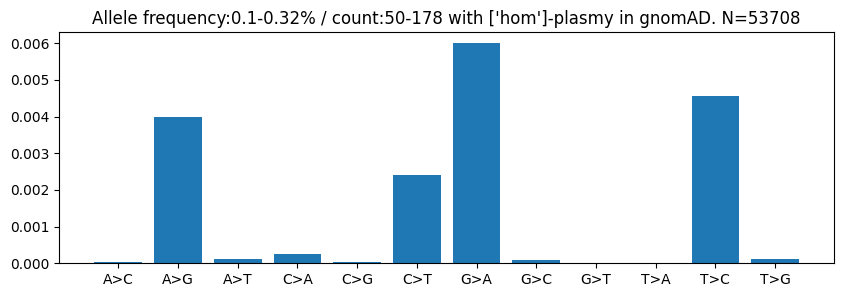

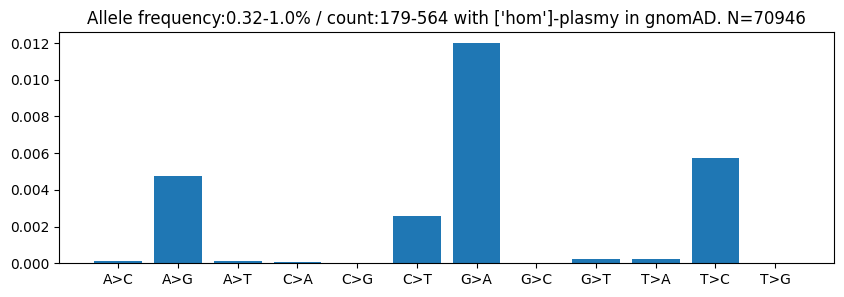

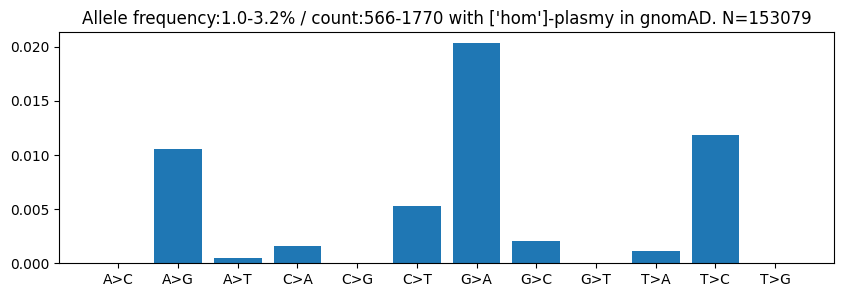

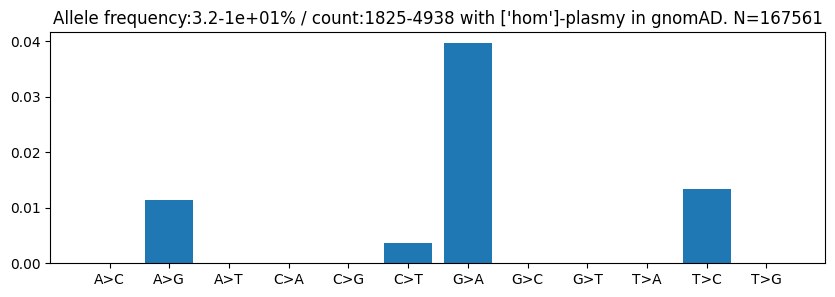

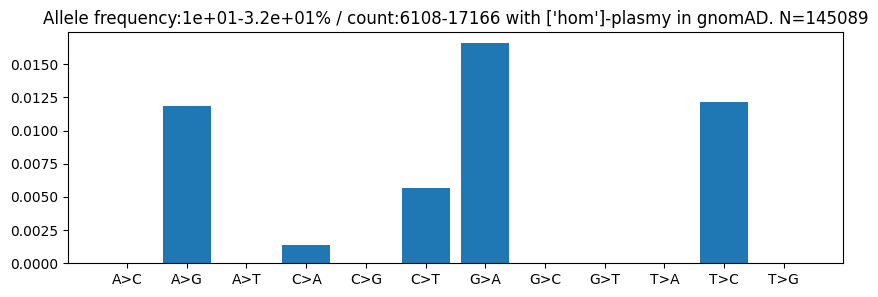

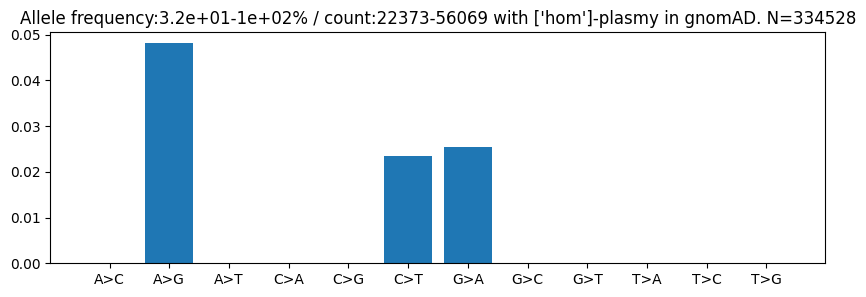

In [195]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search(only_syn_gnomad_df, gnomad_base_freq, 
                     db_samples_number=0, 
                     plasmy=['AC_hom'], db_name='gnomAD')

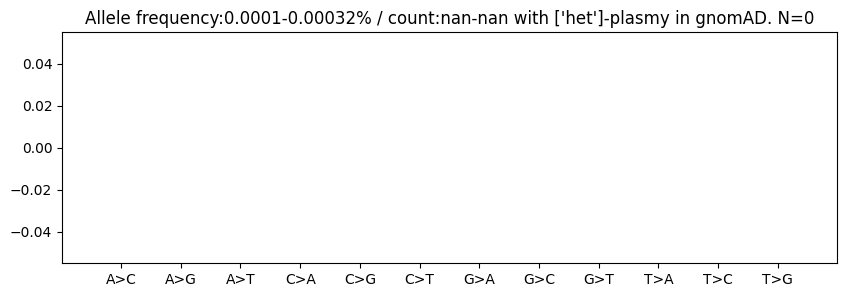

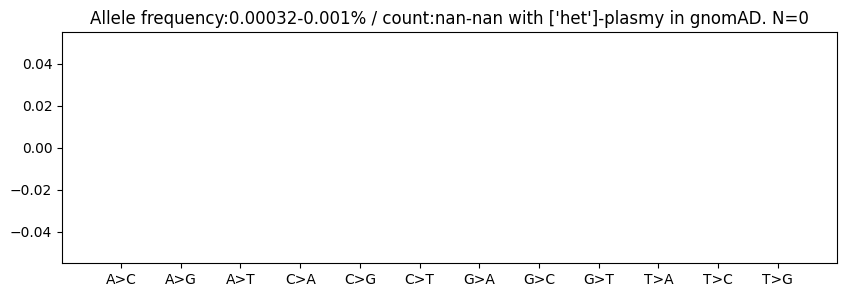

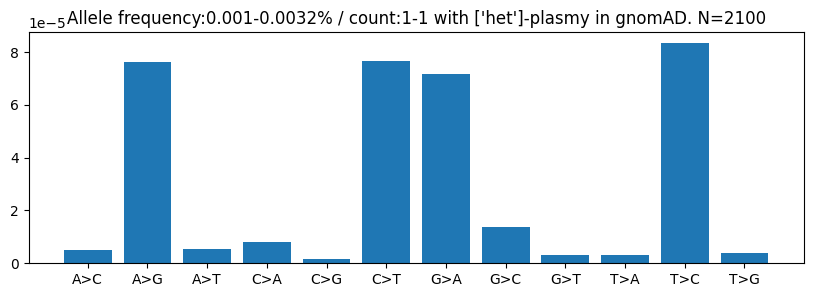

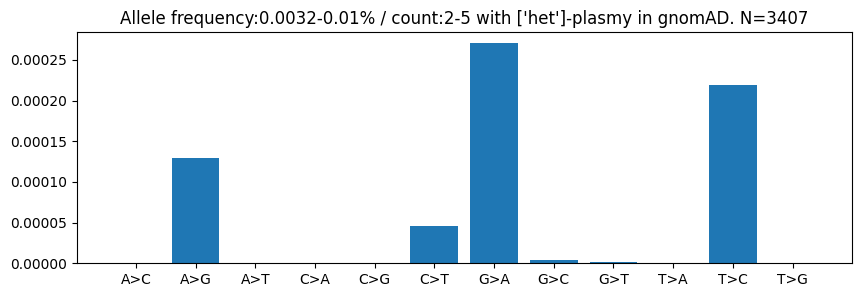

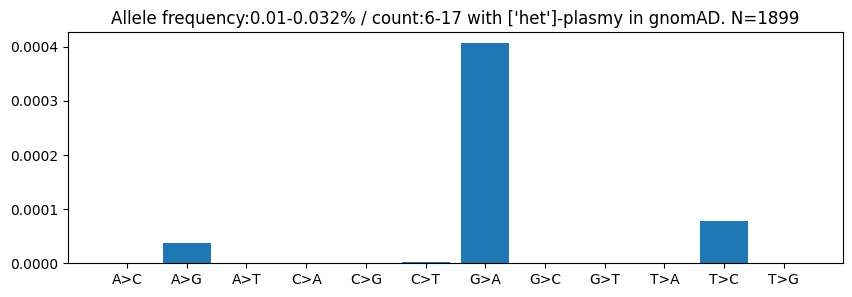

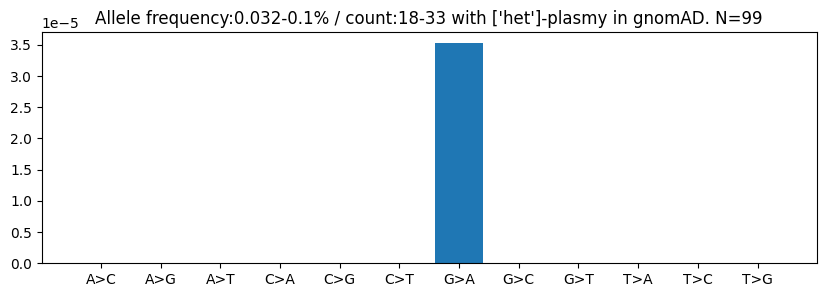

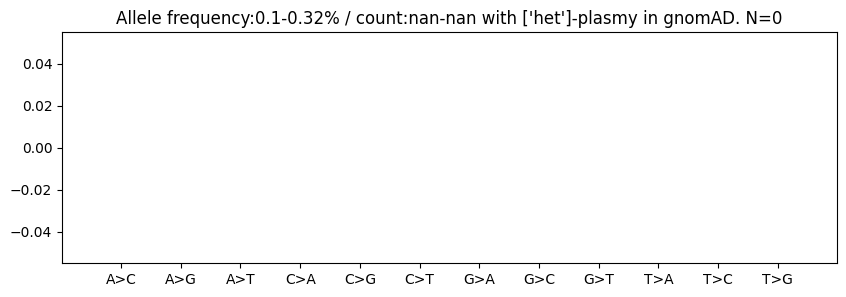

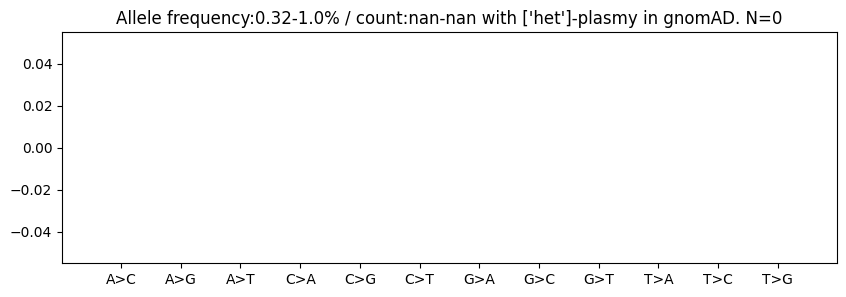

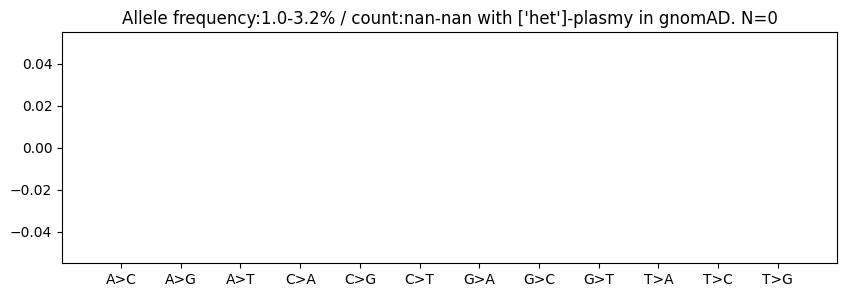

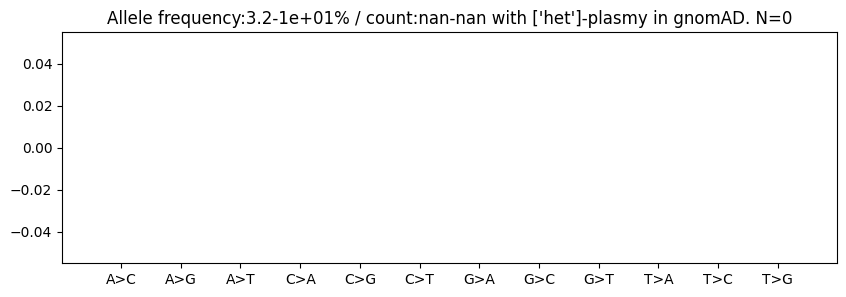

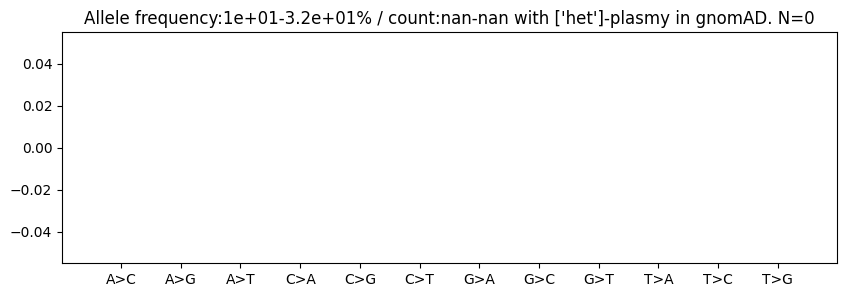

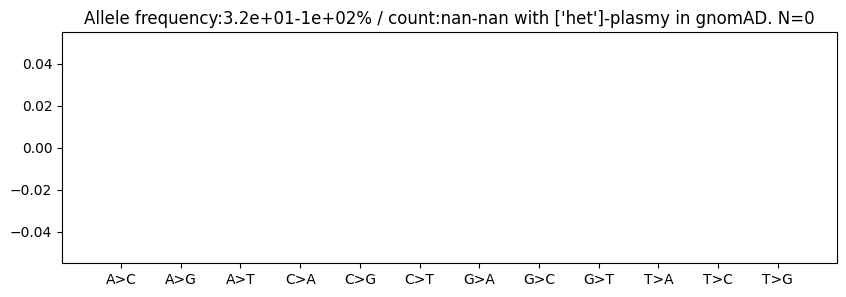

In [196]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search(only_syn_gnomad_df, gnomad_base_freq, 
                     db_samples_number=0, 
                     plasmy=['AC_het'], db_name='gnomAD')

In [20]:
genes12_location = []
for i in range(len(gnomad_cds)):
    if i != len(gnomad_cds)-2:  # ND6
        genes12_location.append([gnomad_cds[i].location.start, gnomad_cds[i].location.end])

In [25]:
loc_df = pd.DataFrame(columns=only_syn_gnomad_df.columns)
for loc_idx in range(len(genes12_location)):
    loc_df = pd.concat([loc_df, only_syn_gnomad_df.loc[(only_syn_gnomad_df.position >= genes12_location[loc_idx][0]) & (only_syn_gnomad_df.position < genes12_location[loc_idx][1])]])
print(len(only_syn_gnomad_df))
len(loc_df)


10384


C:\Users\Эльдар\AppData\Local\Temp\ipykernel_15940\1181677175.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  loc_df = pd.concat([loc_df, only_syn_gnomad_df.loc[(only_syn_gnomad_df.position >= genes12_location[loc_idx][0]) & (only_syn_gnomad_df.position < genes12_location[loc_idx][1])]])


10048

In [24]:
i = 0
df0 = only_syn_gnomad_df.loc[(only_syn_gnomad_df.position >= genes12_location[i][0]) & (only_syn_gnomad_df.position < genes12_location[i][1])]
i = 1
df1 = only_syn_gnomad_df.loc[(only_syn_gnomad_df.position >= genes12_location[i][0]) & (only_syn_gnomad_df.position < genes12_location[i][1])]
pd.concat([df0, df1])

chromosome  position ref alt filters  AC_hom  AC_het    AF_hom    AF_het  \
4306       chrM      3308   T   C    PASS    1609       5  0.028524  0.000089   
4311       chrM      3311   C   T    PASS      13       0  0.000230  0.000000   
4313       chrM      3314   T   C     npg       0       0  0.000000  0.000000   
4318       chrM      3317   C   T    PASS       2       0  0.000035  0.000000   
4323       chrM      3320   A   G    PASS      89       3  0.001577  0.000053   
...         ...       ...  ..  ..     ...     ...     ...       ...       ...   
6364       chrM      5507   C   A    PASS       2       0  0.000035  0.000000   
6365       chrM      5508   T   A    PASS       1       0  0.000018  0.000000   
6366       chrM      5508   T   C    PASS      11       1  0.000195  0.000018   
6367       chrM      5509   T   C    PASS       2       1  0.000035  0.000018   
6368       chrM      5510   A   G    PASS      10       1  0.000177  0.000018   

         AN  max_observed_heteroplasmy  
4306  56409                      1.000  
4311  56433                      0.999  
4313  56433                      0.000  
4318  56433                      1.000  
4323  56430                      1.000  
...     ...                        ...  
6364  56434                      0.999  
6365  56434                      1.000  
6366  56430                      1.000  
6367  56429                      1.000  
6368  56432                      0.999  

[1772 rows x 11 columns]

### ND6

In [19]:
nd6_location = [gnomad_cds[-2].location.start, gnomad_cds[-2].location.end]
len(nd6_location)

2

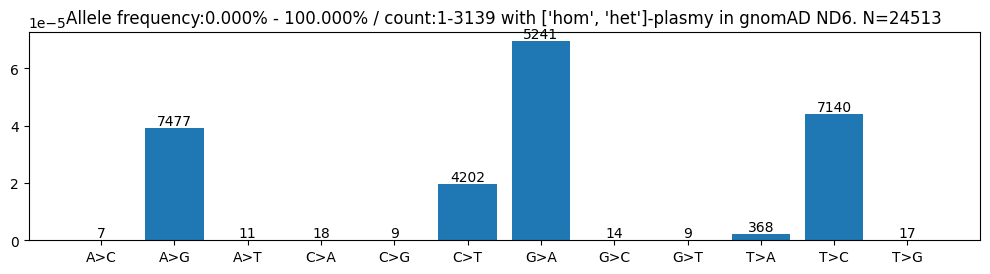

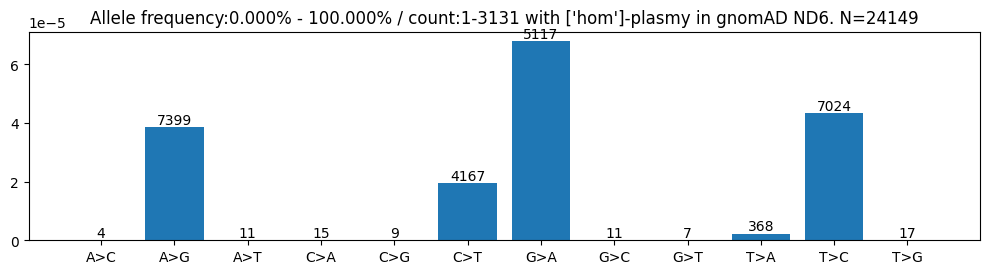

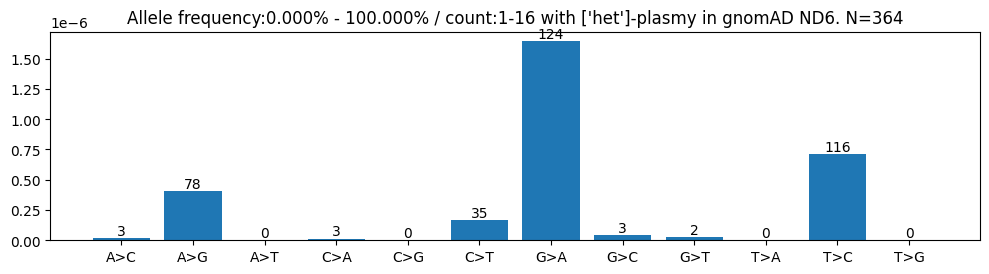

In [56]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for plasmy in [['AC_hom', 'AC_het'], ['AC_hom'], ['AC_het']]:
        threshold_search_pb(only_syn_gnomad_df, gnomad_base_freq, 
                 db_samples_number=gnomad_samples_number, 
                 plasmy=plasmy, db_name='gnomAD ND6', 
                 threshold_array=np.logspace(-6, 0, 2), location=nd6_location)

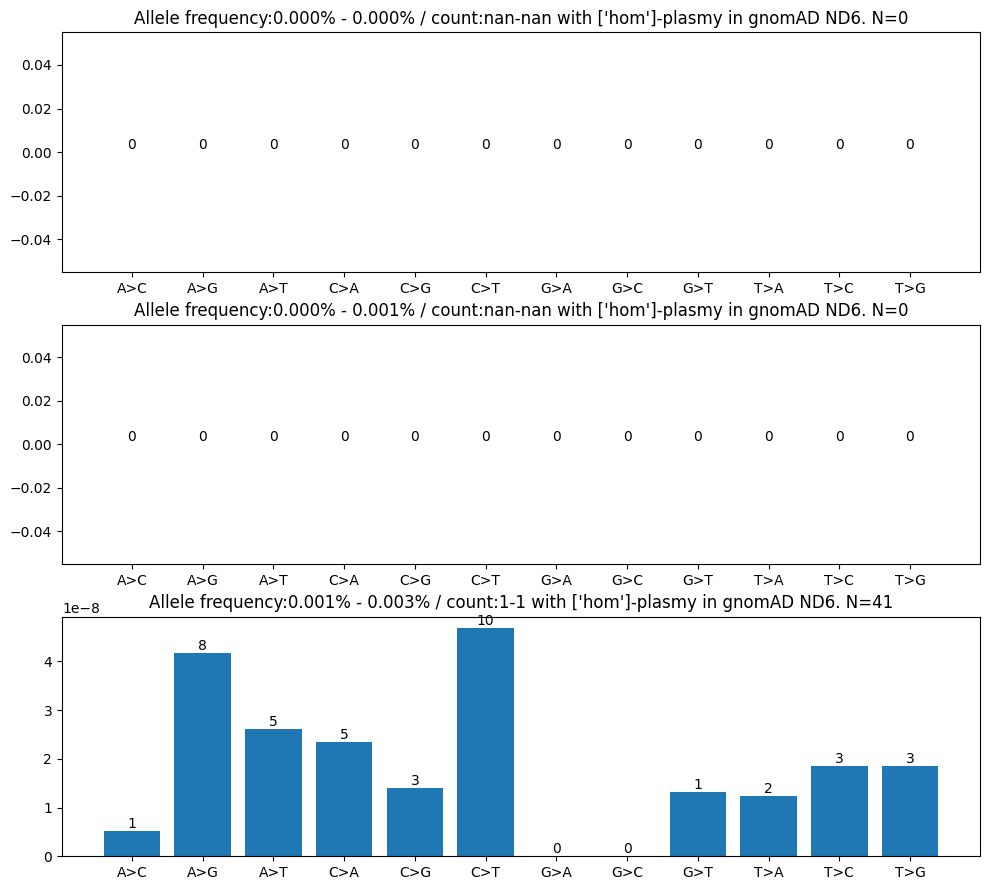

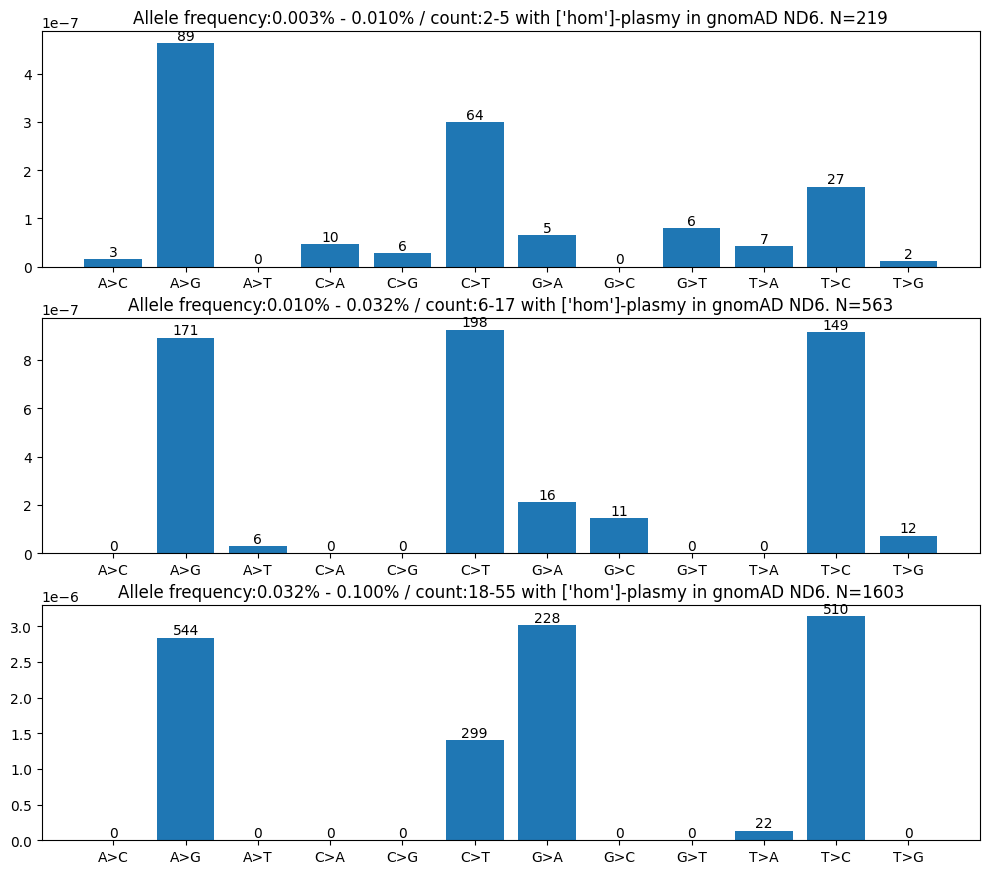

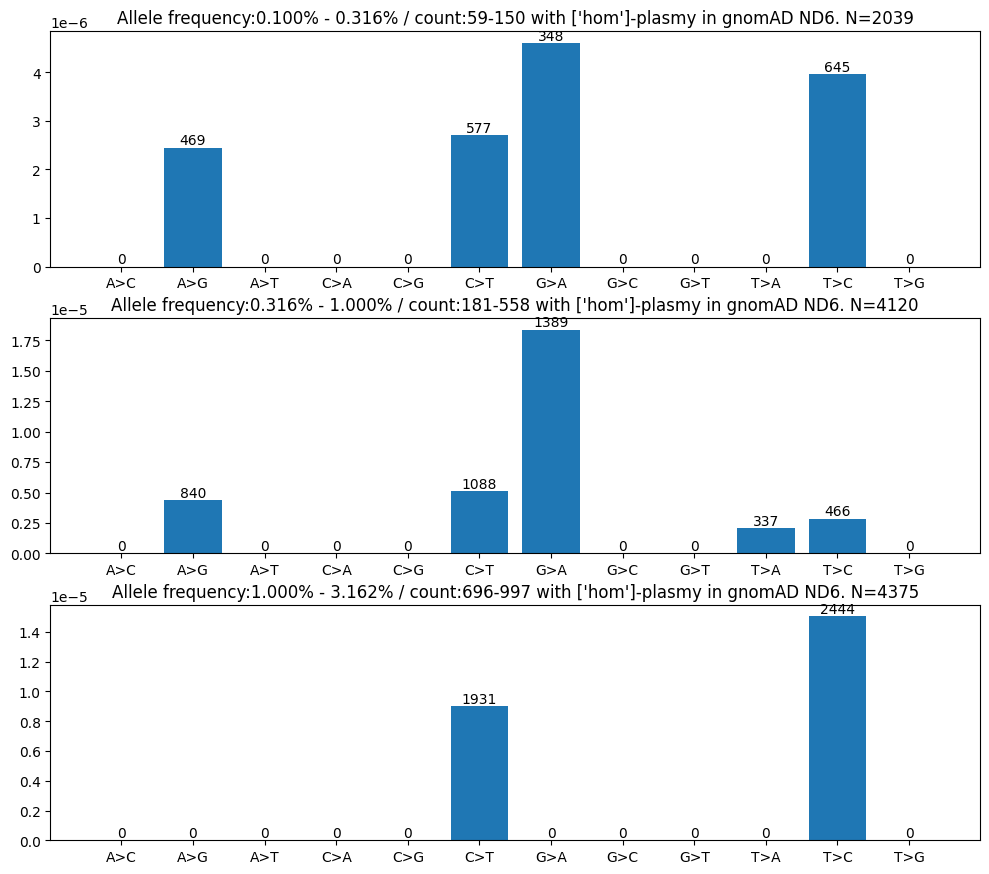

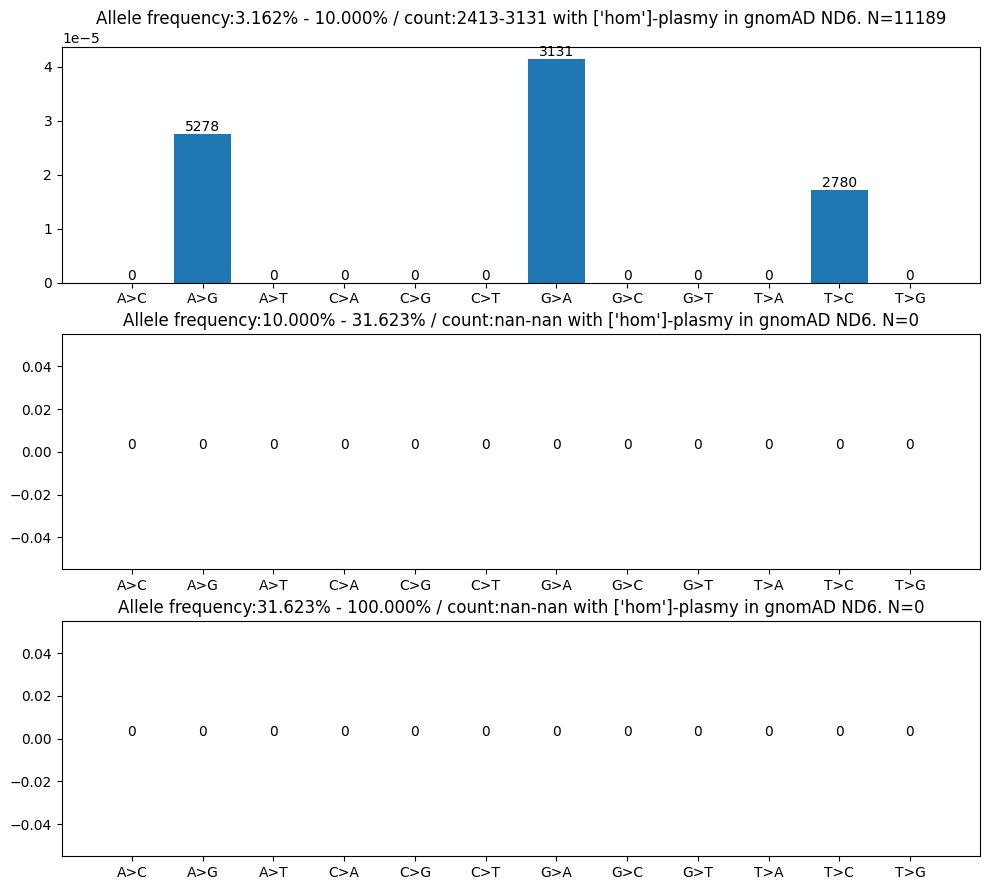

In [53]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(4):
        threshold_array = np.logspace(-6, 0, 13)[i*3:i*3+4]
        threshold_search_pb(only_syn_gnomad_df, gnomad_base_freq,
                    plasmy=['AC_hom'], db_samples_number=gnomad_samples_number,
                    threshold_array=threshold_array, db_name='gnomAD ND6',
                    location=nd6_location) # ,plasmy=['AC_hom']

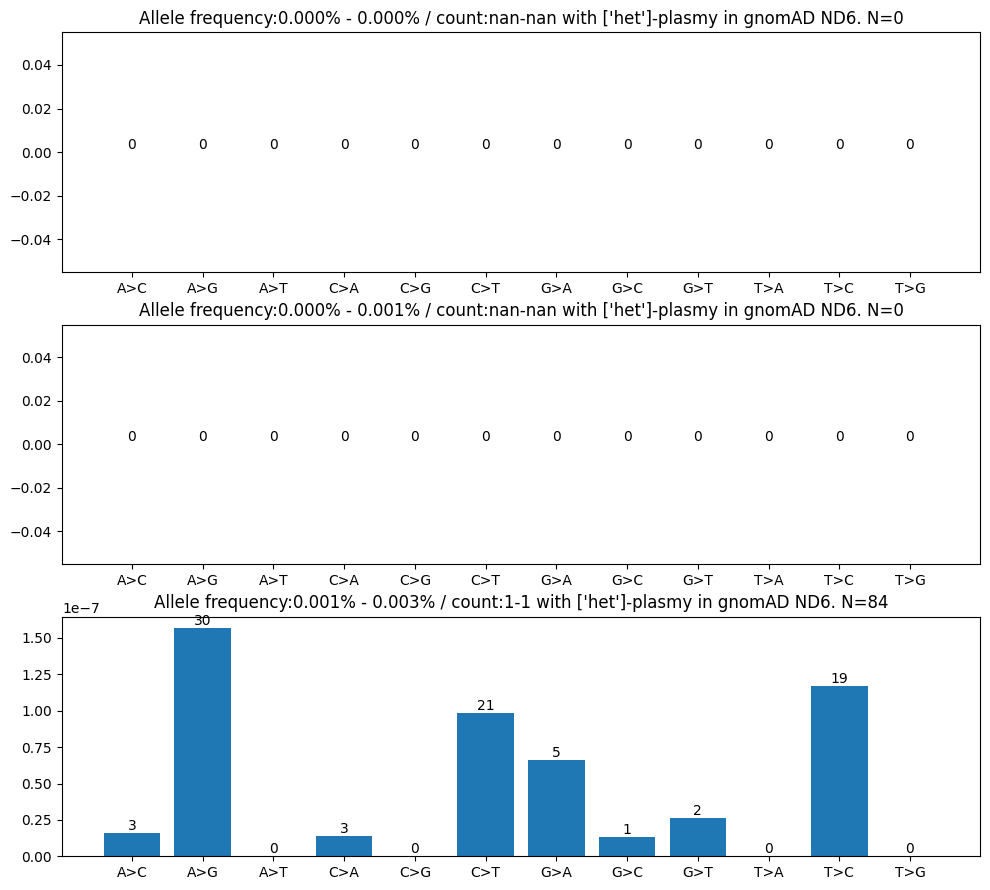

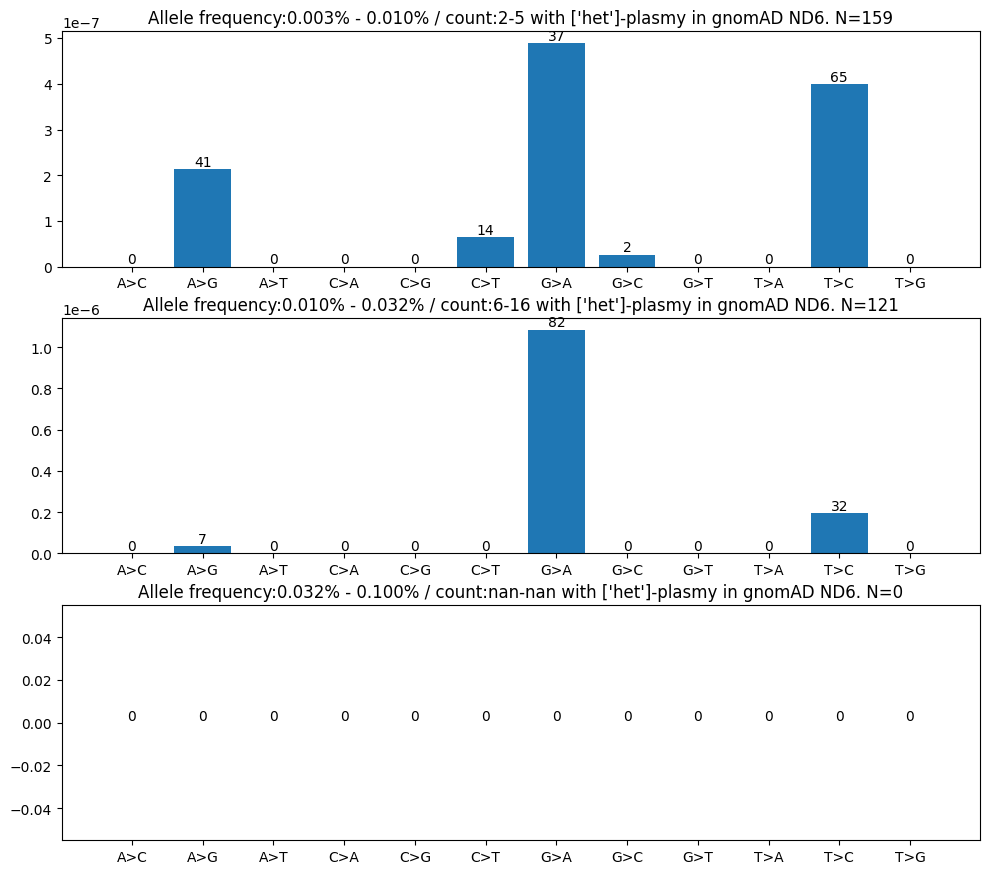

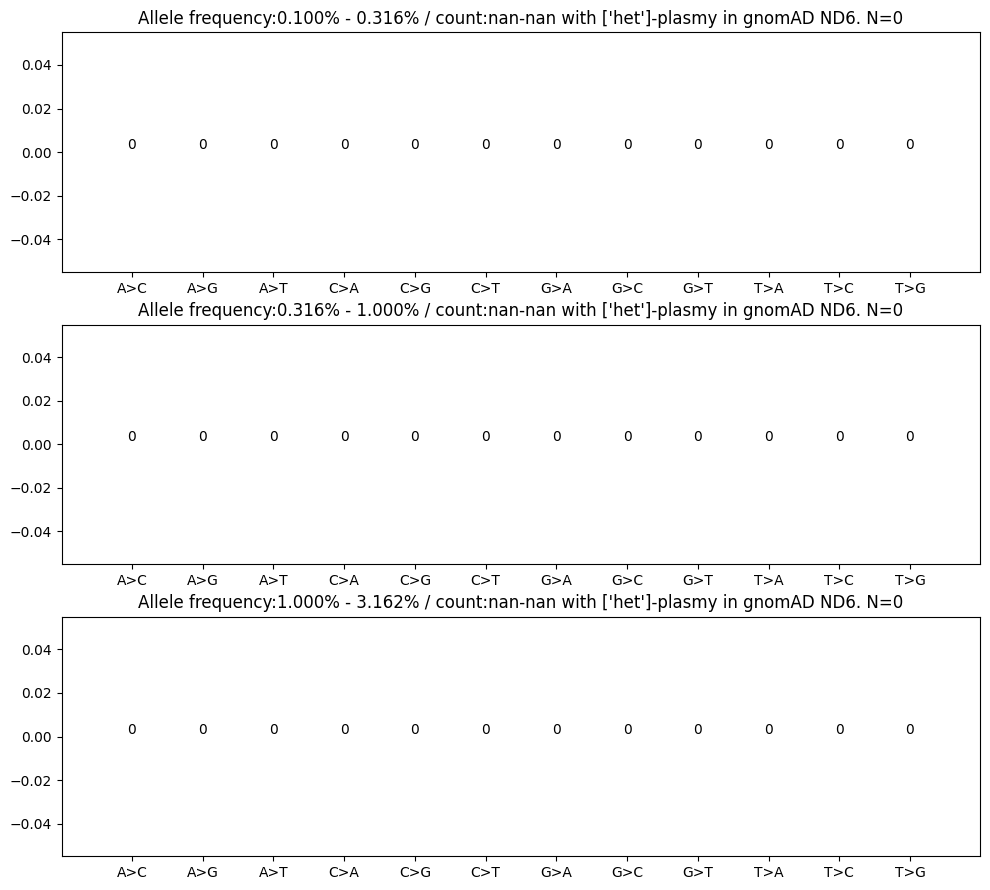

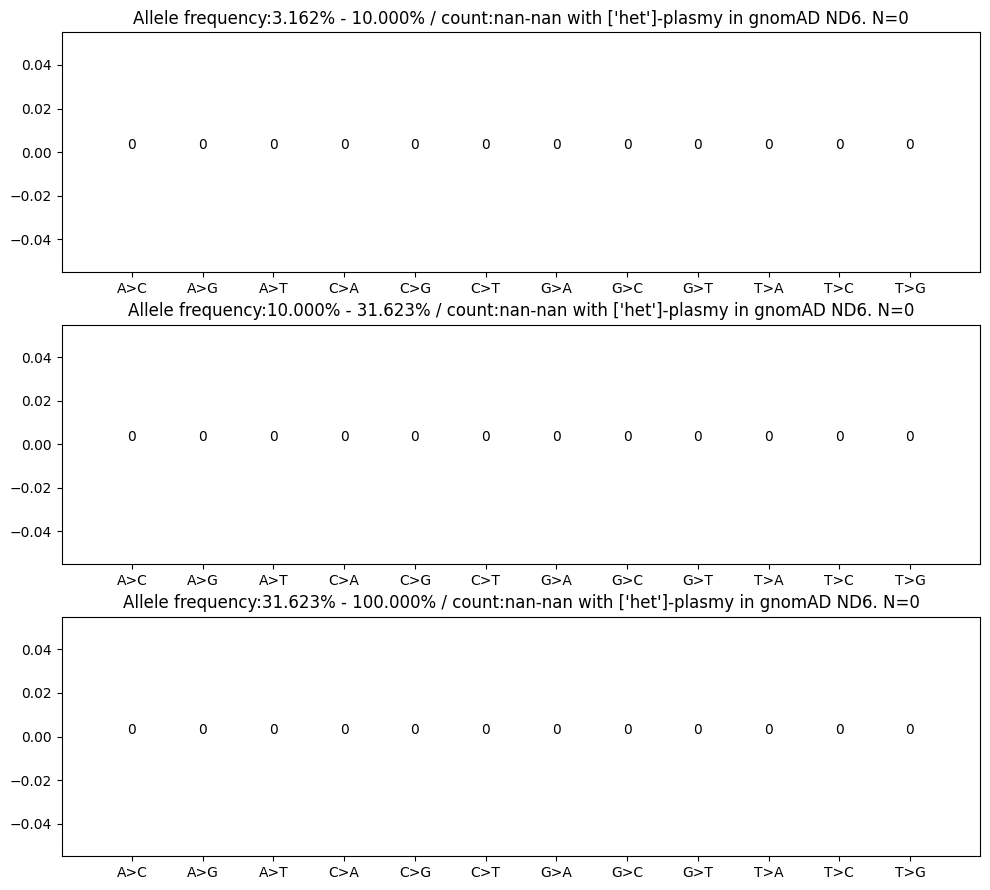

In [54]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(4):
        threshold_array = np.logspace(-6, 0, 13)[i*3:i*3+4]
        threshold_search_pb(only_syn_gnomad_df, gnomad_base_freq,
                    plasmy=['AC_het'], db_samples_number=gnomad_samples_number,
                    threshold_array=threshold_array, db_name='gnomAD ND6',
                    location=nd6_location) # ,plasmy=['AC_hom']

## HelixMT

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_23892\2012070042.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5.435637160348272e-06' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  allele_freqs[sub_idx] = subs_number[sub_idx] / db_base_freq[sub_idx[0]] / db_samples_number


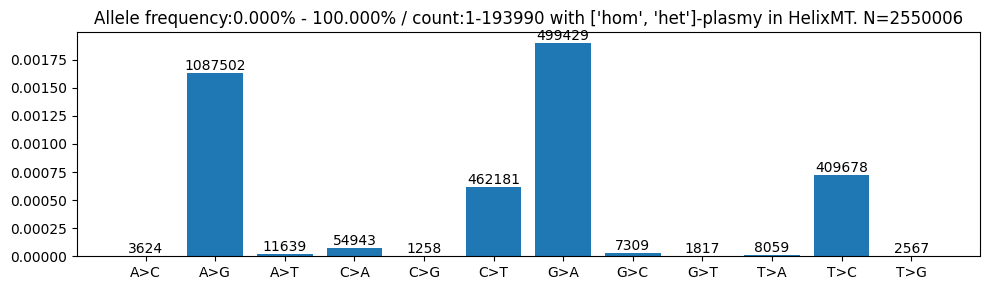

In [33]:
# Total
threshold_search_pb(only_syn_helix_df, helix_base_freq, 
                 db_samples_number=helix_samples_number, 
                 db_name='HelixMT', 
                 threshold_array=np.logspace(-6, 0, 2))

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_23892\2012070042.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5.182154080850794e-06' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  allele_freqs[sub_idx] = subs_number[sub_idx] / db_base_freq[sub_idx[0]] / db_samples_number


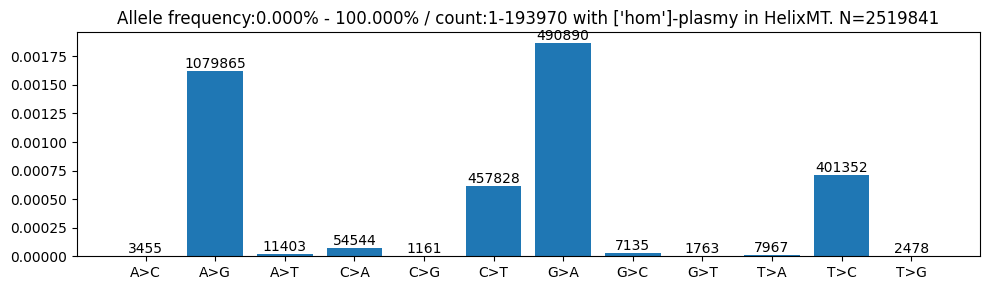

In [34]:
# Total hom
threshold_search_pb(only_syn_helix_df, helix_base_freq, 
                 db_samples_number=helix_samples_number, 
                 plasmy=['AC_hom'], db_name='HelixMT', 
                 threshold_array=np.logspace(-6, 0, 2))

C:\Users\Эльдар\AppData\Local\Temp\ipykernel_23892\2012070042.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.534830794974774e-07' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  allele_freqs[sub_idx] = subs_number[sub_idx] / db_base_freq[sub_idx[0]] / db_samples_number


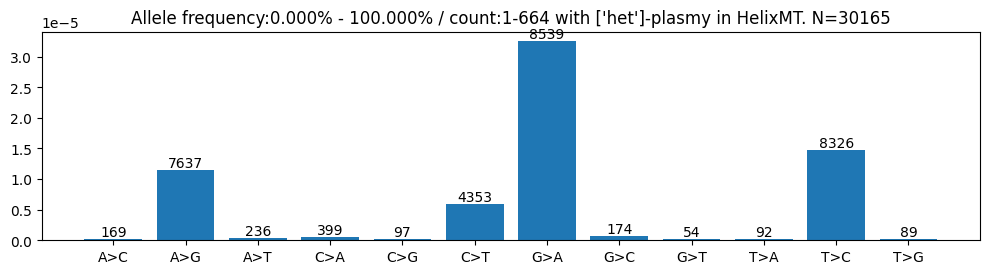

In [35]:
# Total het
threshold_search_pb(only_syn_helix_df, helix_base_freq, 
                 db_samples_number=helix_samples_number, 
                 plasmy=['AC_het'], db_name='HelixMT', 
                 threshold_array=np.logspace(-6, 0, 2))

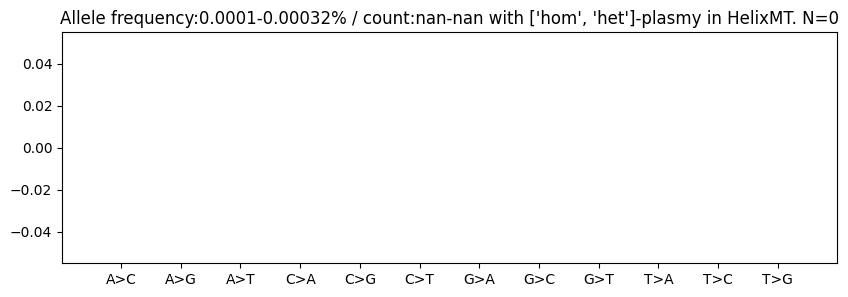

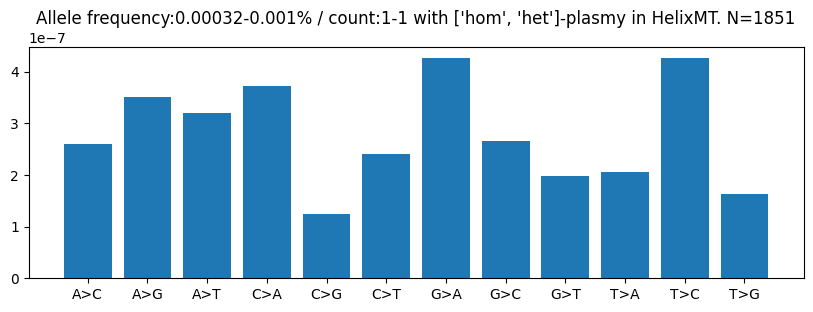

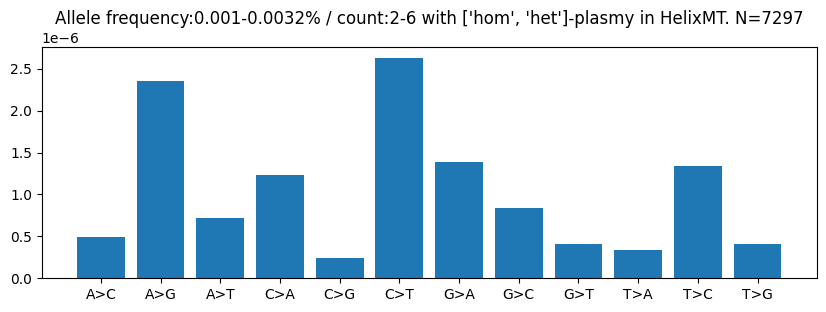

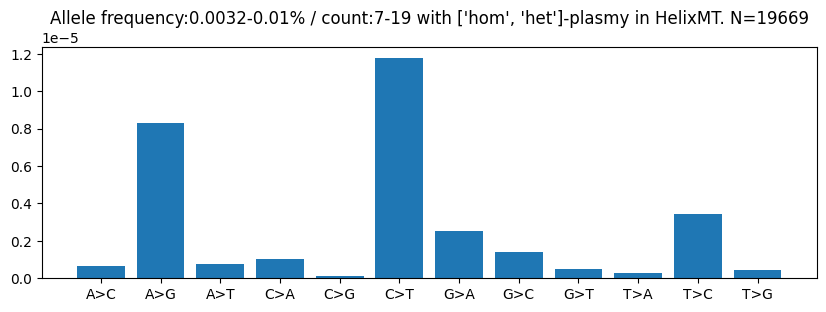

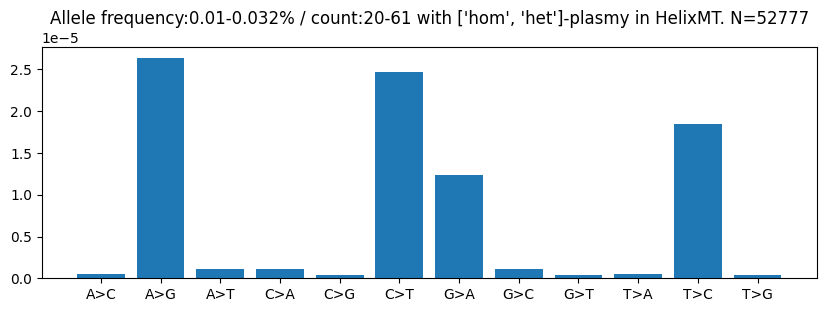

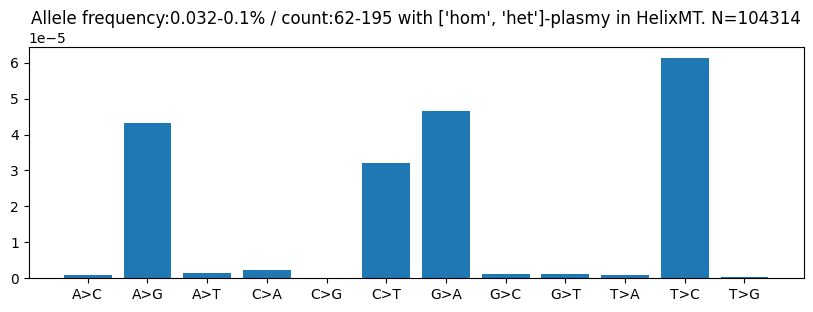

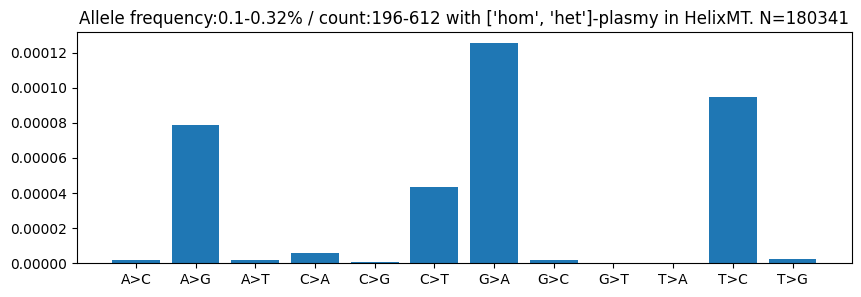

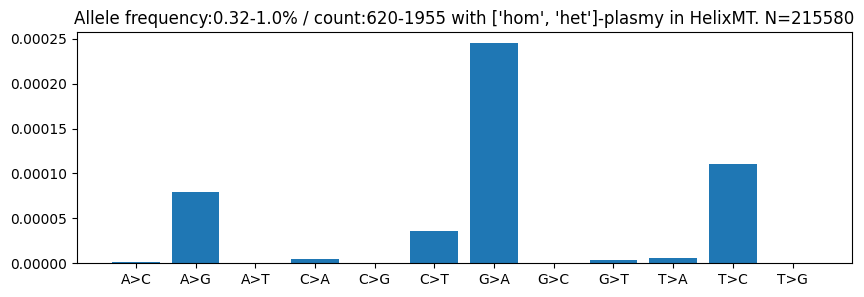

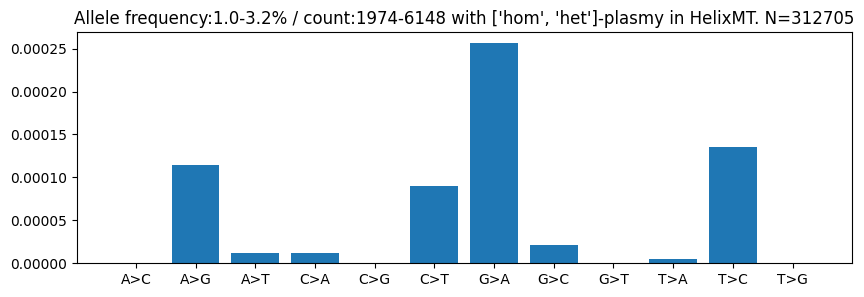

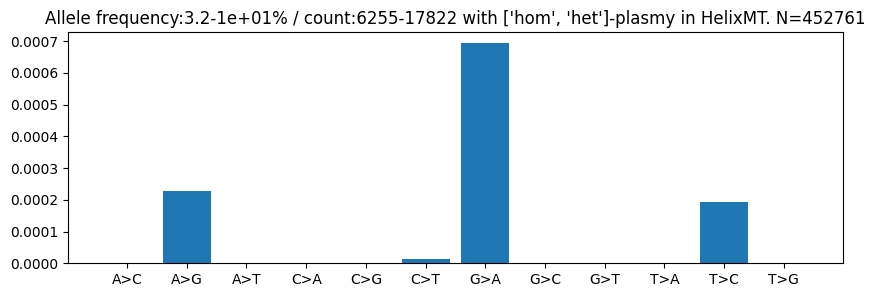

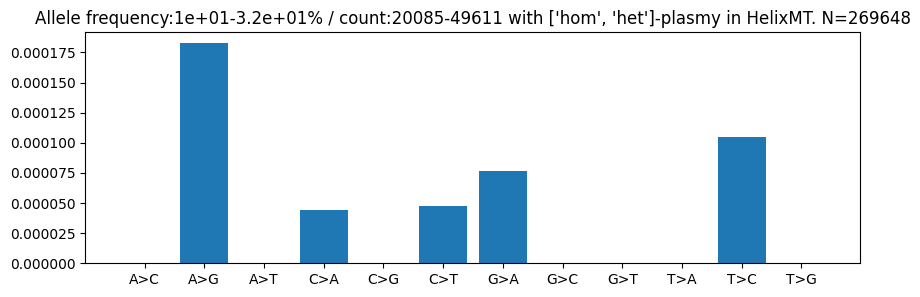

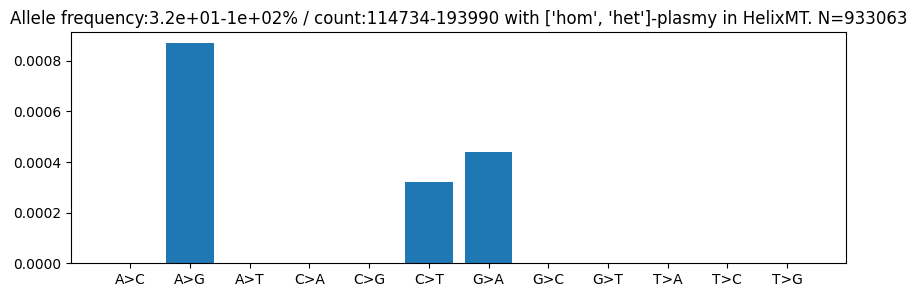

In [202]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search(only_syn_helix_df, helix_base_freq, 
                     db_samples_number=helix_samples_number, 
                     db_name='HelixMT')

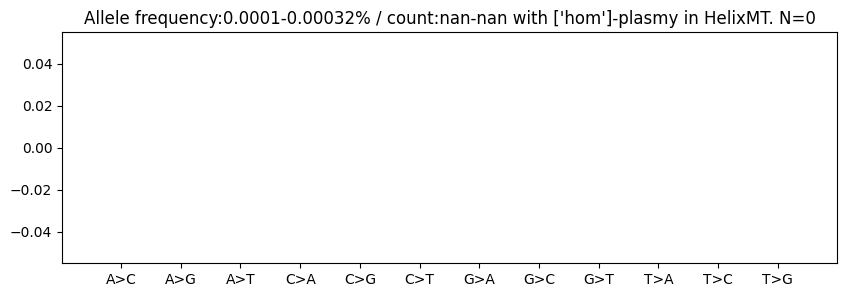

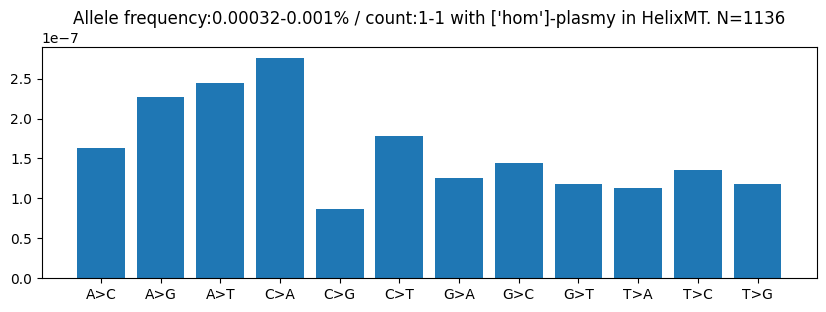

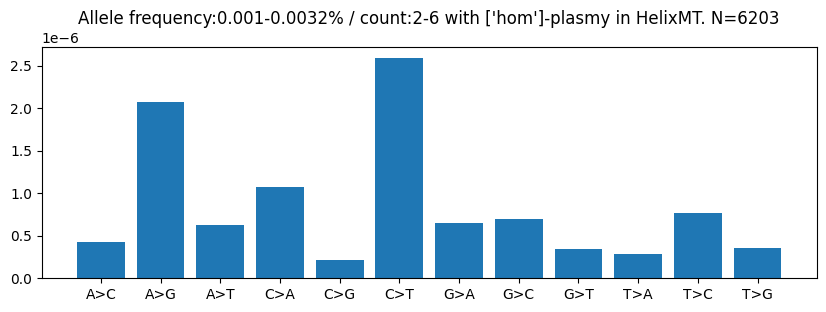

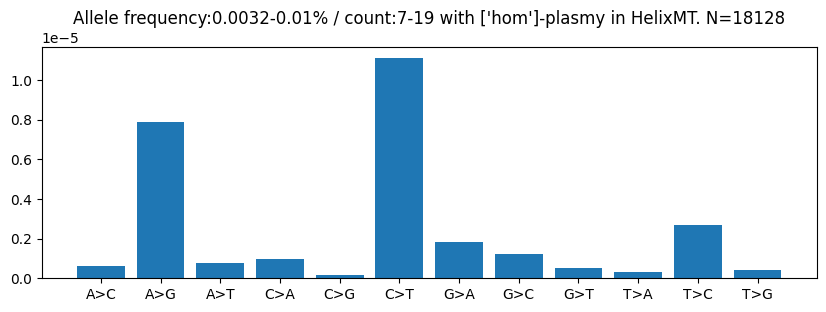

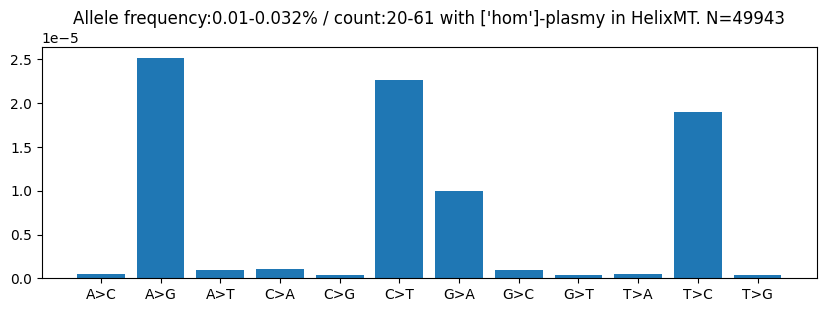

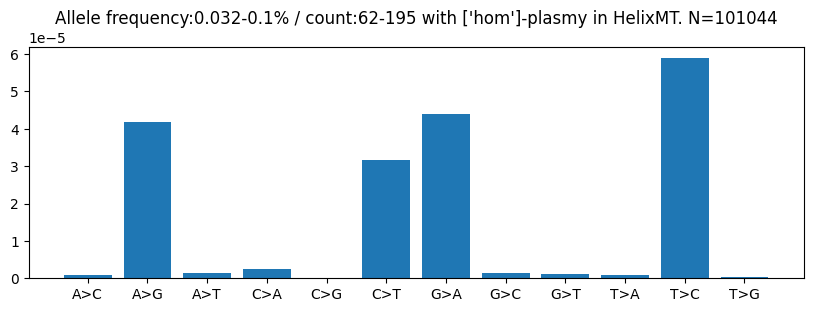

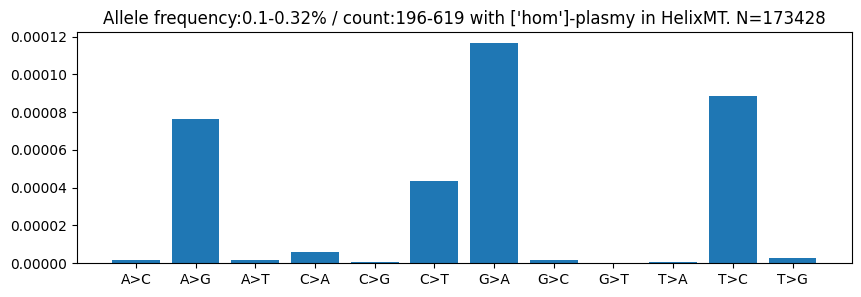

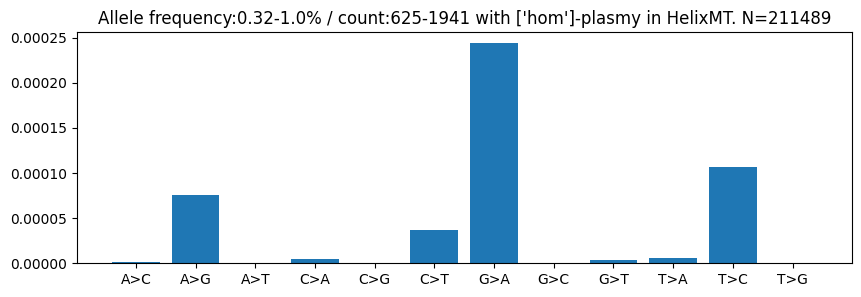

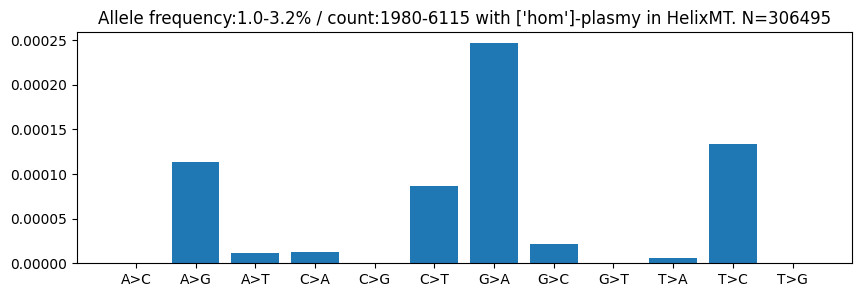

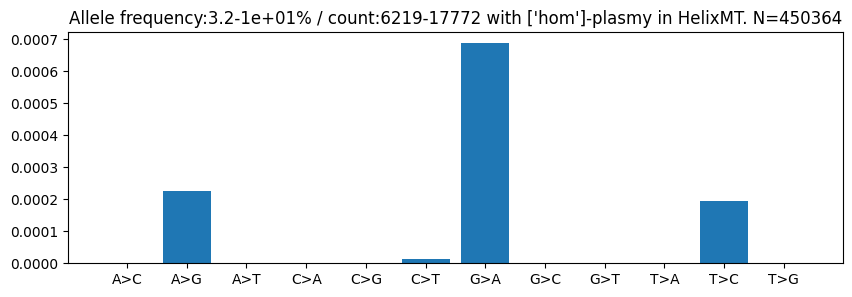

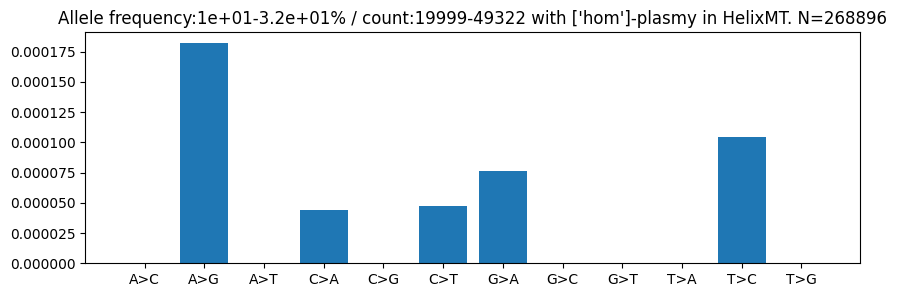

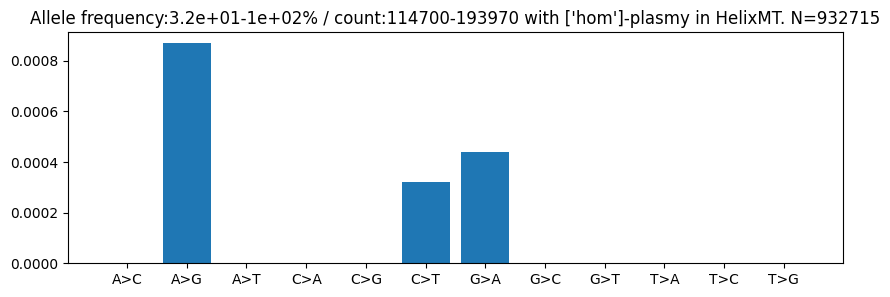

In [198]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search(only_syn_helix_df, helix_base_freq, 
                     db_samples_number=helix_samples_number, 
                     plasmy=['AC_hom'], db_name='HelixMT')

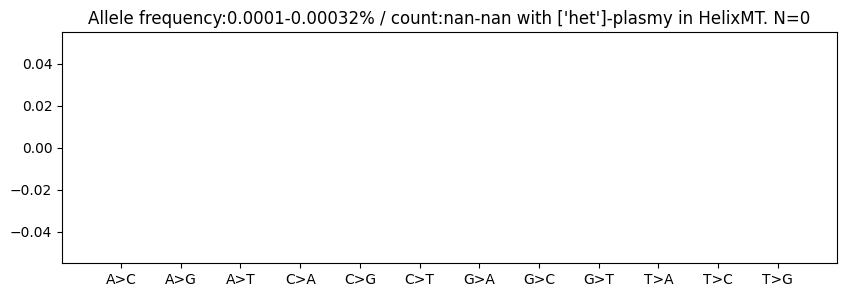

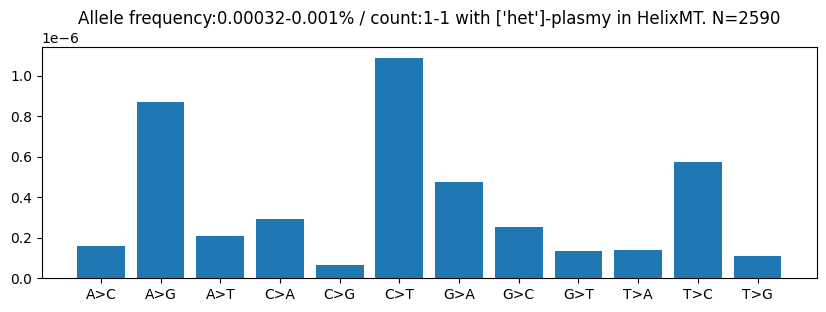

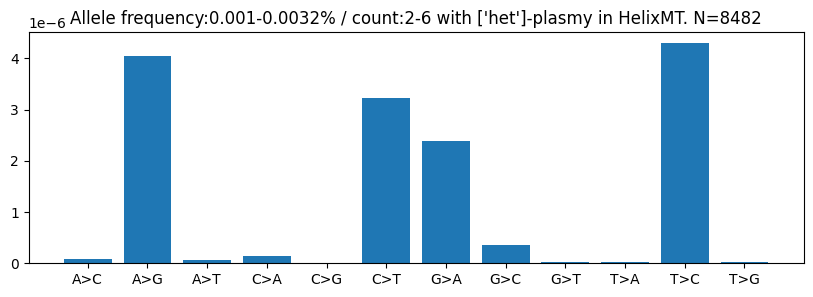

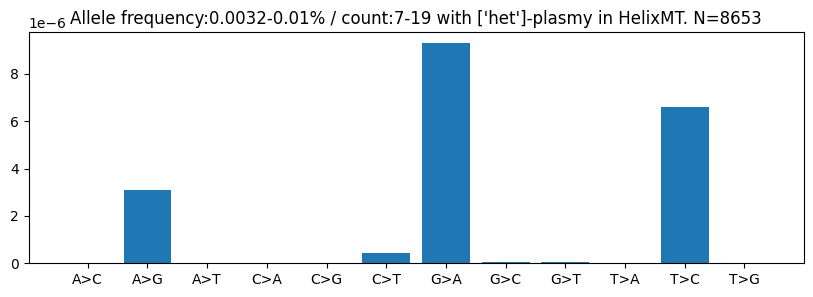

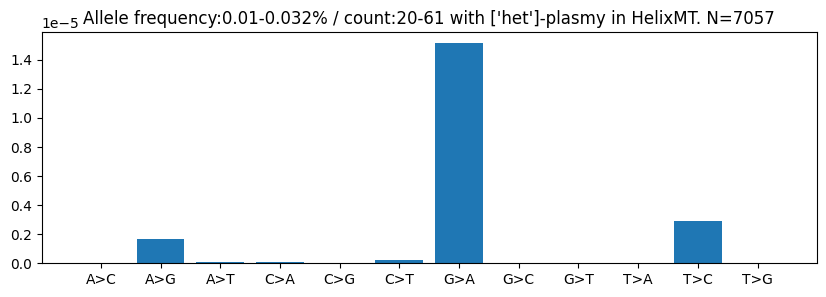

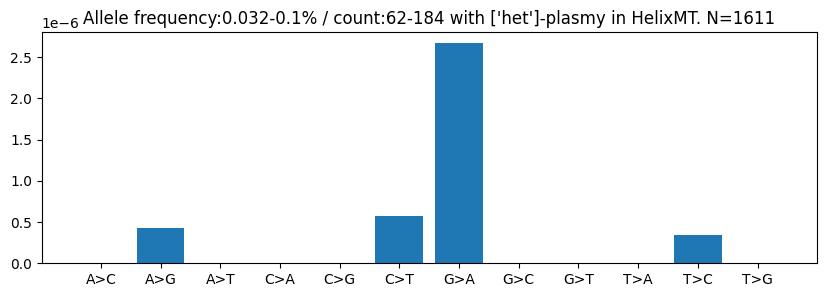

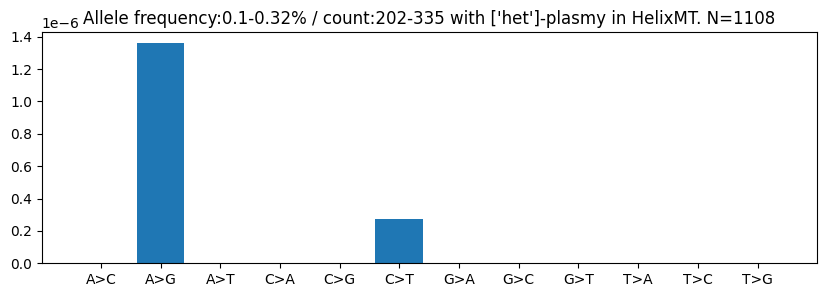

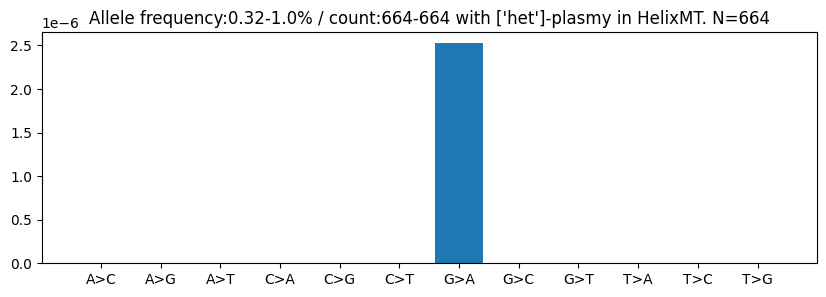

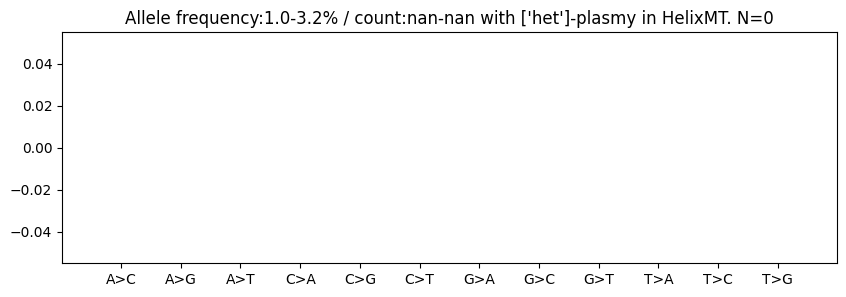

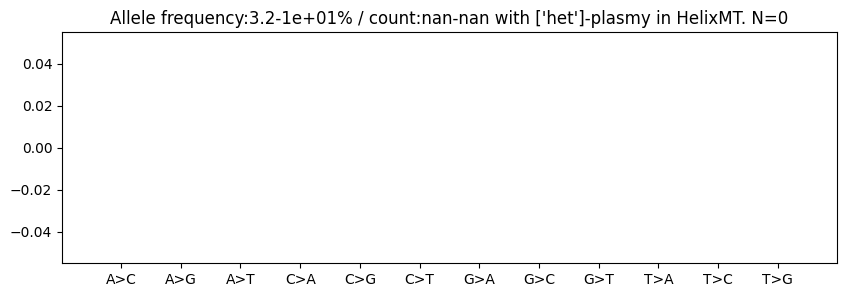

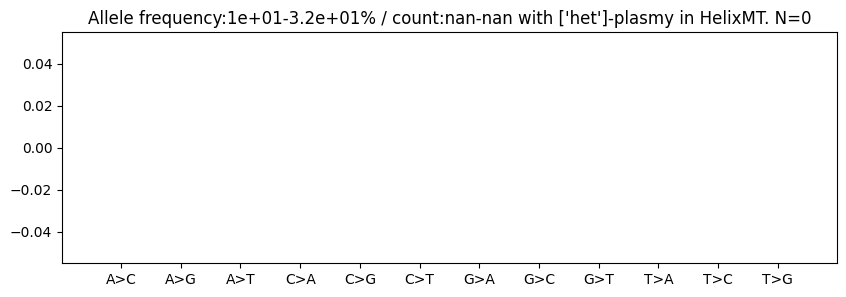

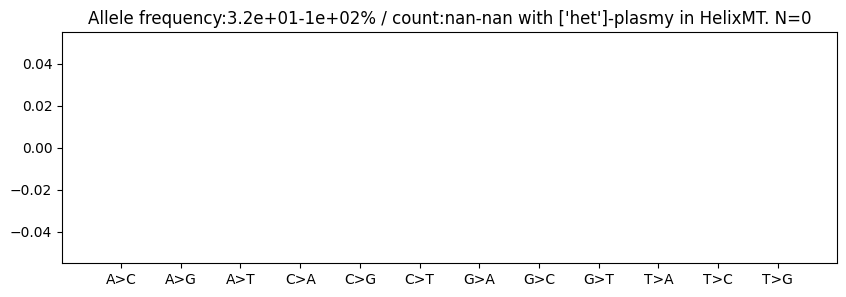

In [199]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    threshold_search(only_syn_helix_df, helix_base_freq, 
                     db_samples_number=helix_samples_number, 
                     plasmy=['AC_het'], db_name='HelixMT')

### ND6

In [58]:
nd6_location = [helix_cds[-2].location.start, helix_cds[-2].location.end]

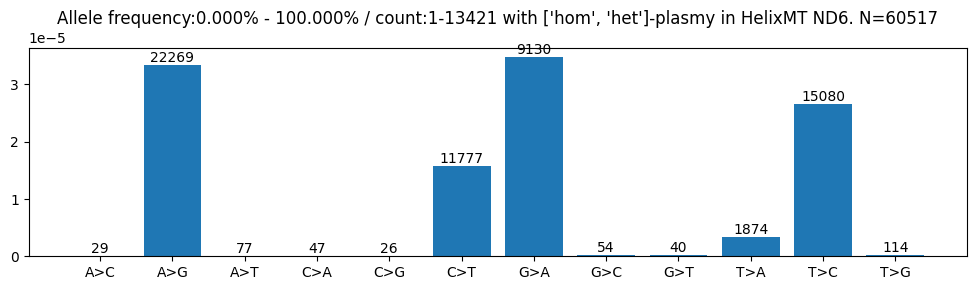

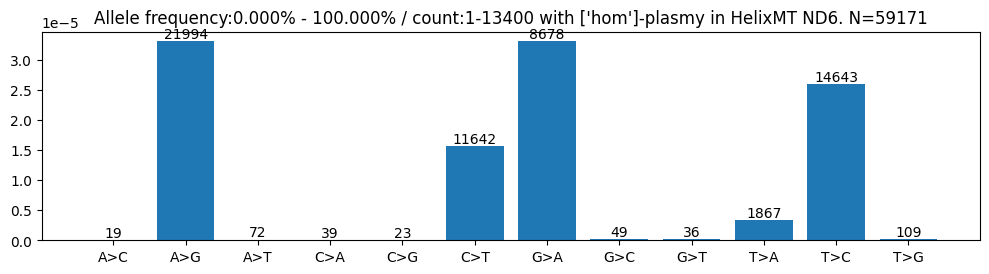

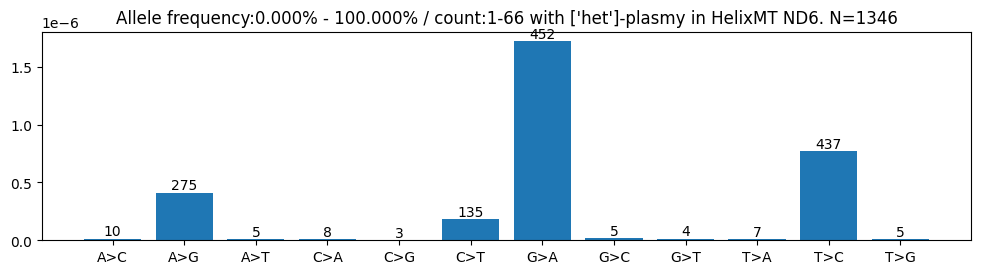

In [62]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for plasmy in [['AC_hom', 'AC_het'], ['AC_hom'], ['AC_het']]:
        threshold_search_pb(only_syn_helix_df, helix_base_freq, 
                 db_samples_number=helix_samples_number, 
                 plasmy=plasmy, db_name='HelixMT ND6', 
                 threshold_array=np.logspace(-6, 0, 2), location=nd6_location)

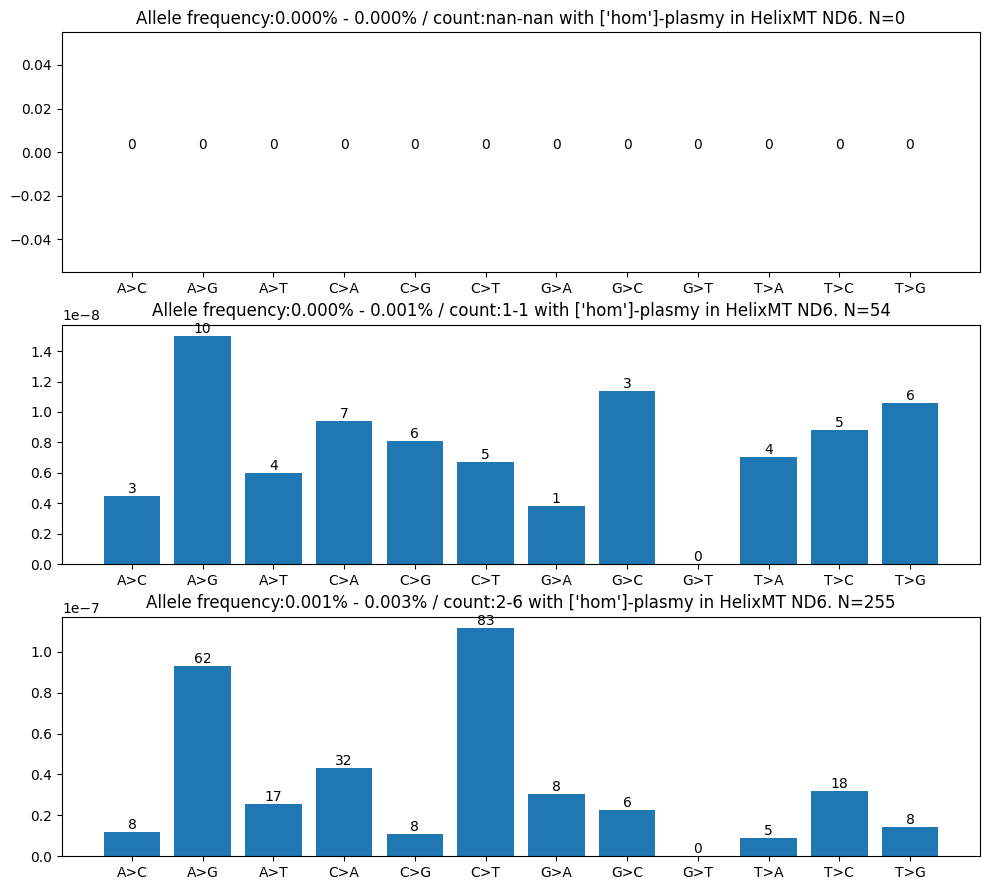

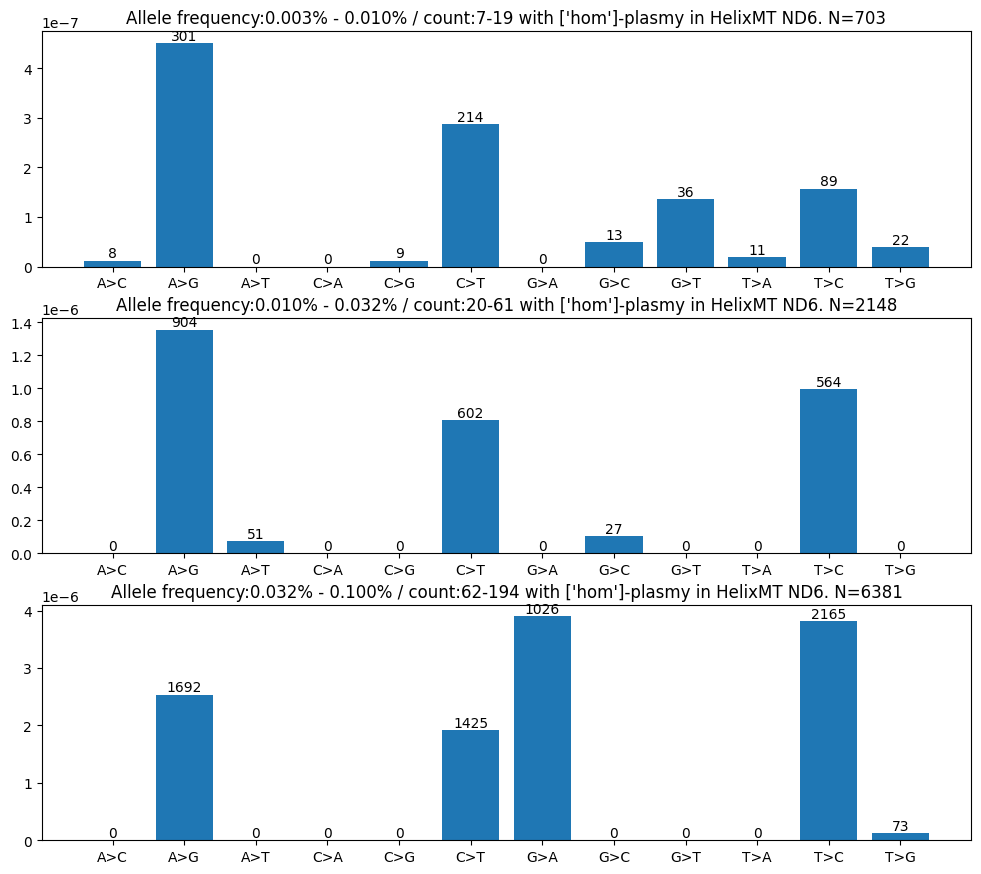

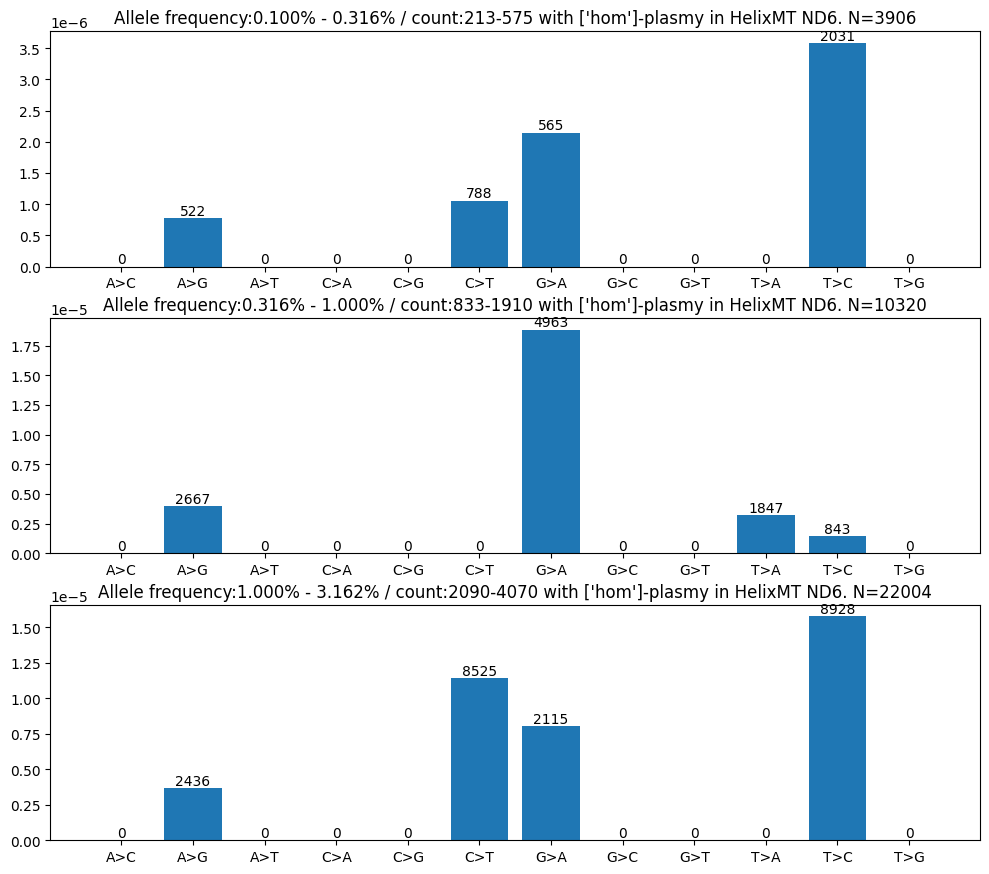

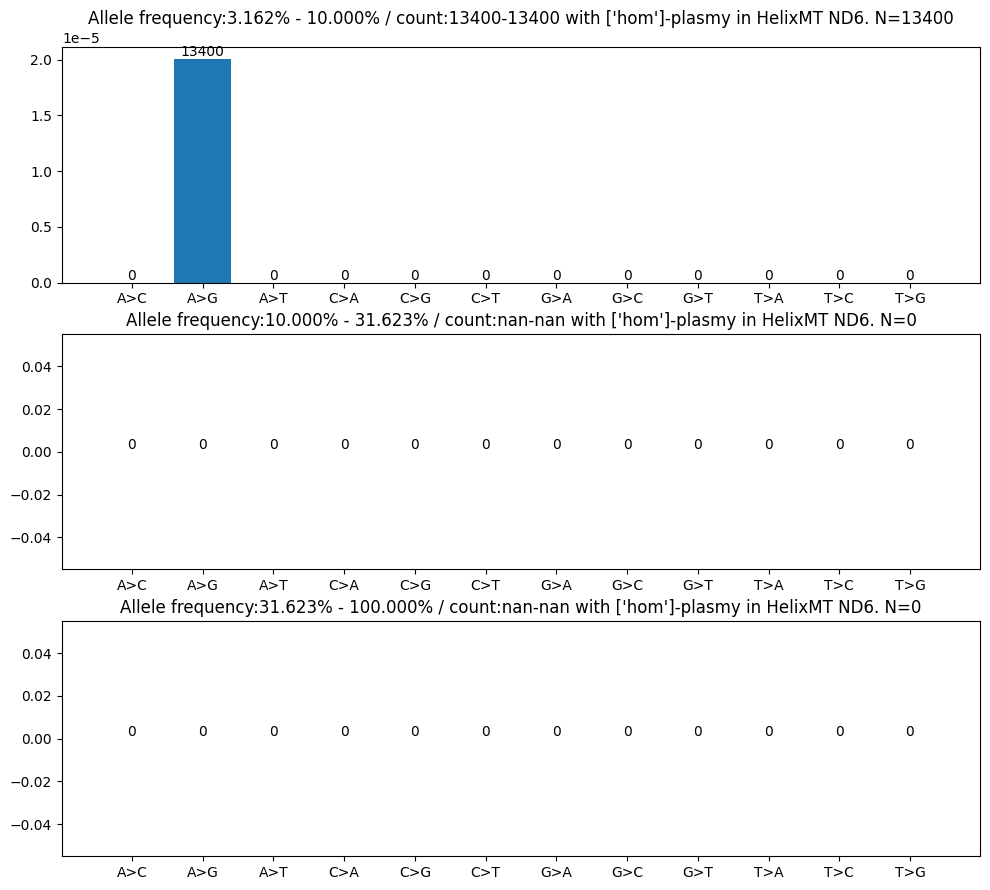

In [63]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(4):
        threshold_array = np.logspace(-6, 0, 13)[i*3:i*3+4]
        threshold_search_pb(only_syn_helix_df, helix_base_freq,
                    plasmy=['AC_hom'], db_samples_number=helix_samples_number,
                    threshold_array=threshold_array, db_name='HelixMT ND6',
                    location=nd6_location) # ,plasmy=['AC_hom']

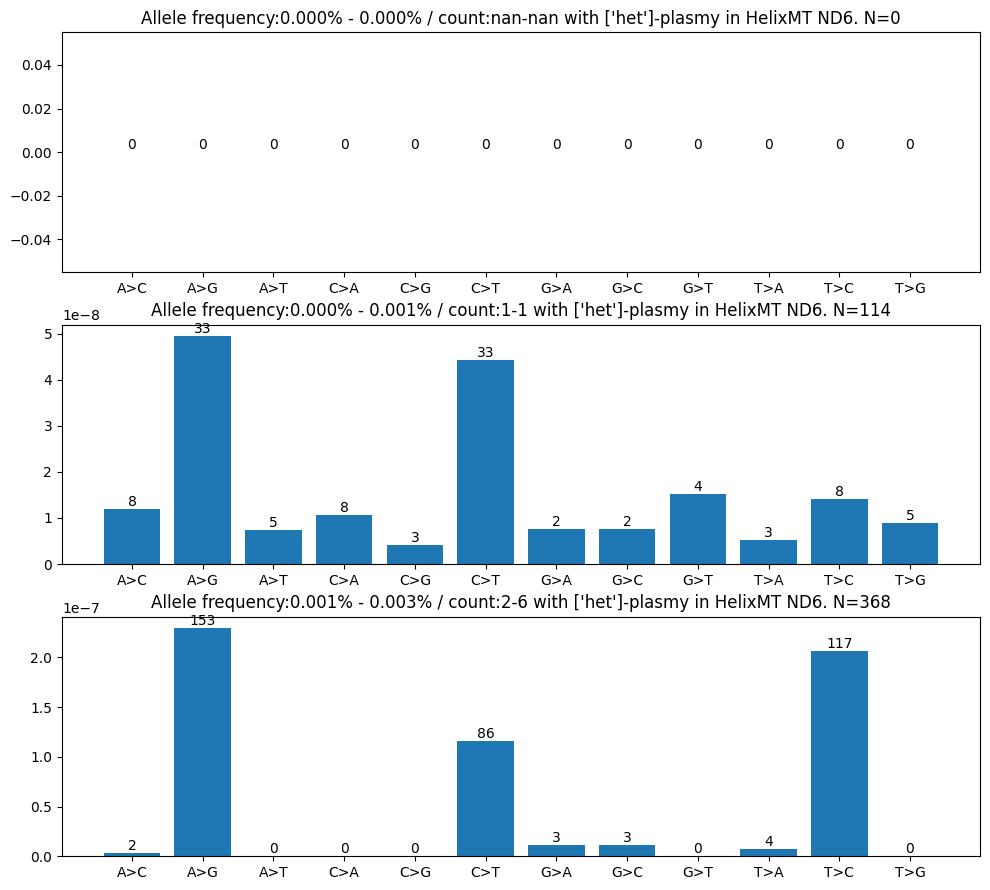

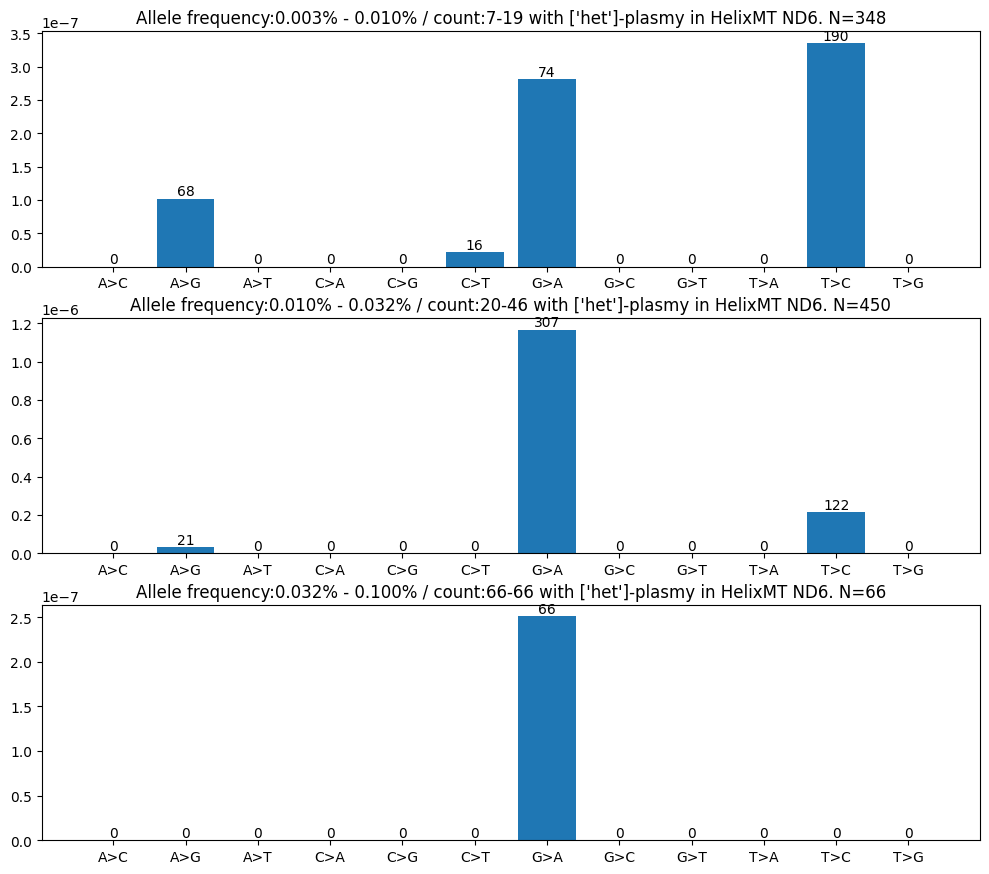

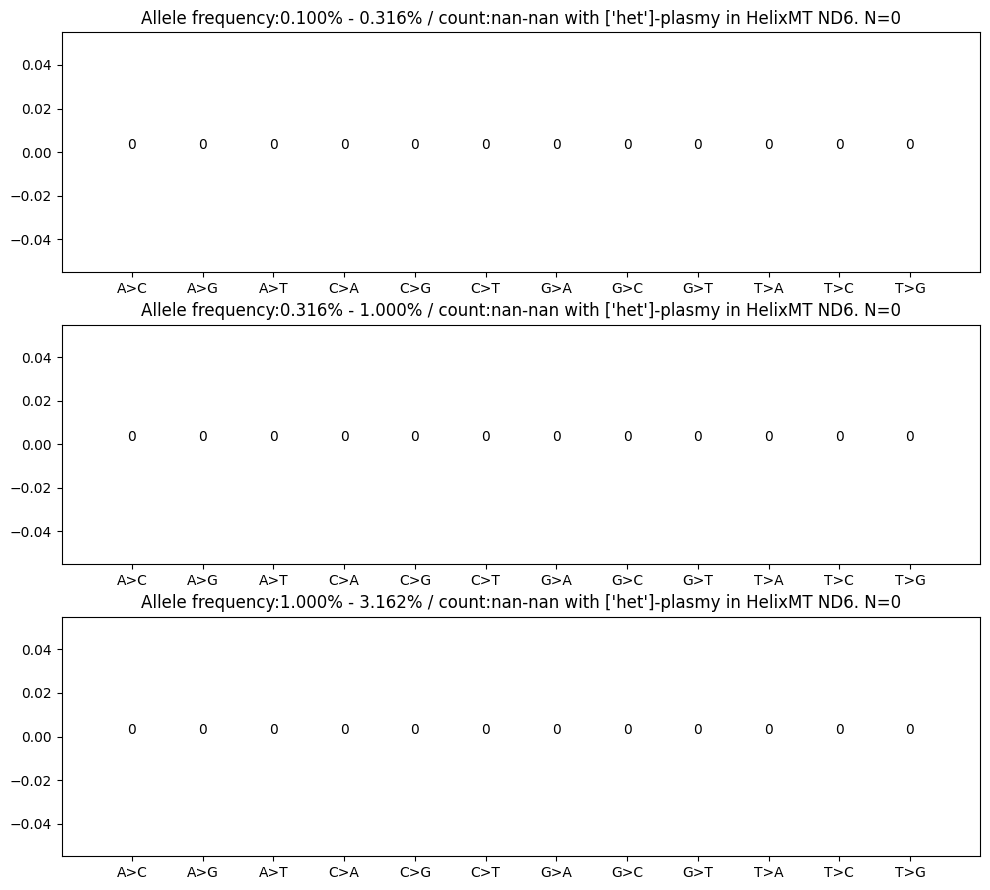

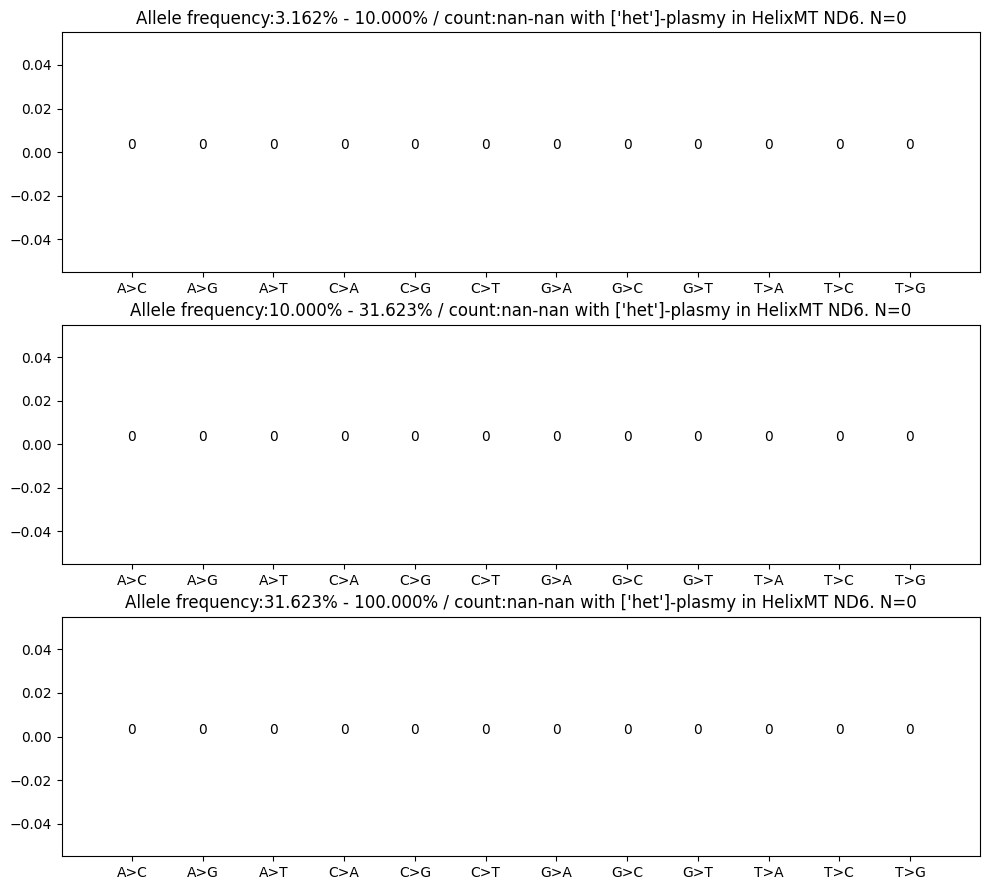

In [64]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(4):
        threshold_array = np.logspace(-6, 0, 13)[i*3:i*3+4]
        threshold_search_pb(only_syn_helix_df, helix_base_freq,
                    plasmy=['AC_het'], db_samples_number=helix_samples_number,
                    threshold_array=threshold_array, db_name='HelixMT ND6',
                    location=nd6_location) # ,plasmy=['AC_hom']

# Plot builder

In [24]:
def threshold_search_pb(only_syn_df, db_base_freq, db_samples_number, 
                     db_name, plasmy=['AC_hom', 'AC_het'], 
                     threshold_array = np.logspace(-6, 0, 13), dict=False,
                     jackknife=False, location=None):
    '''Parameters:
    db_samples_number:  if == 0 it is subs_number_sum; if == 1, there is no dividing'''
    allele_freqs_dict = {}

    af_plasmy = [i.replace('C','F') for i in plasmy]  # adapting summarizing of subs_count for different plasmy
    subs_freq_df = only_syn_df.loc[:,af_plasmy].sum(axis=1)
    plots_number = len(threshold_array) - 1
    
    if dict != True:
        
        fig, ax = plt.subplots(nrows=plots_number, figsize=(10, 3*plots_number))
        ax = ax.ravel() if plots_number > 1 else [ax]

    for plot_idx, threshold_idx in zip(range(plots_number), range(len(threshold_array)-1)):
        threshold_lower = threshold_array[threshold_idx] 
        threshold_upper = threshold_array[threshold_idx+1]
        threshold_df = only_syn_df[(subs_freq_df >= threshold_lower) & (subs_freq_df < threshold_upper)]

        if location != None:
            if len(location) == 2:
                threshold_df = threshold_df.loc[(threshold_df.position >= location[0]) & (threshold_df.position < location[1])]
            else:
                loc_df = pd.DataFrame(columns=threshold_df.columns)
                for loc_idx in range(len(location)):
                    loc_df = pd.concat([loc_df, threshold_df.loc[(threshold_df.position >= location[loc_idx][0]) & (threshold_df.position < location[loc_idx][1])]])
                threshold_df = loc_df
        if jackknife != False:
            threshold_df = threshold_df.sample(frac=jackknife)
            
        rarity = f'{threshold_df.loc[:,plasmy].sum(axis=1).min()}-{threshold_df.loc[:,plasmy].sum(axis=1).max()}'
        subs_number = threshold_df.groupby(['ref', 'alt']).sum(numeric_only=True).loc[:,plasmy].sum(axis=1)
        subs_number_sum = subs_number.sum()
        if db_samples_number == 0:
            db_samples_number = subs_number_sum
        subs_length_checker(subs_number)
        allele_freqs = subs_number.copy()
        for sub_idx in subs_number.index:
            allele_freqs[sub_idx] = subs_number[sub_idx] / db_base_freq[sub_idx[0]] / db_samples_number
        allele_freqs_dict[f'{threshold_array[threshold_idx]:.3%}'] = allele_freqs

        if dict == True:
            continue

        ax[plot_idx].bar_label(ax[plot_idx].bar(x=substitutions, height=allele_freqs), labels=subs_number)
        ax[plot_idx].set_title(f'Allele frequency:{threshold_lower:.3%} - {threshold_upper:.3%} / count:{rarity} with {[i[-3:] for i in plasmy]}-plasmy in {db_name}. N={subs_number_sum}')
        # plt.ylim(top=top)

    if dict == True:
        return allele_freqs_dict
    else:
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.22)
        plt.show()

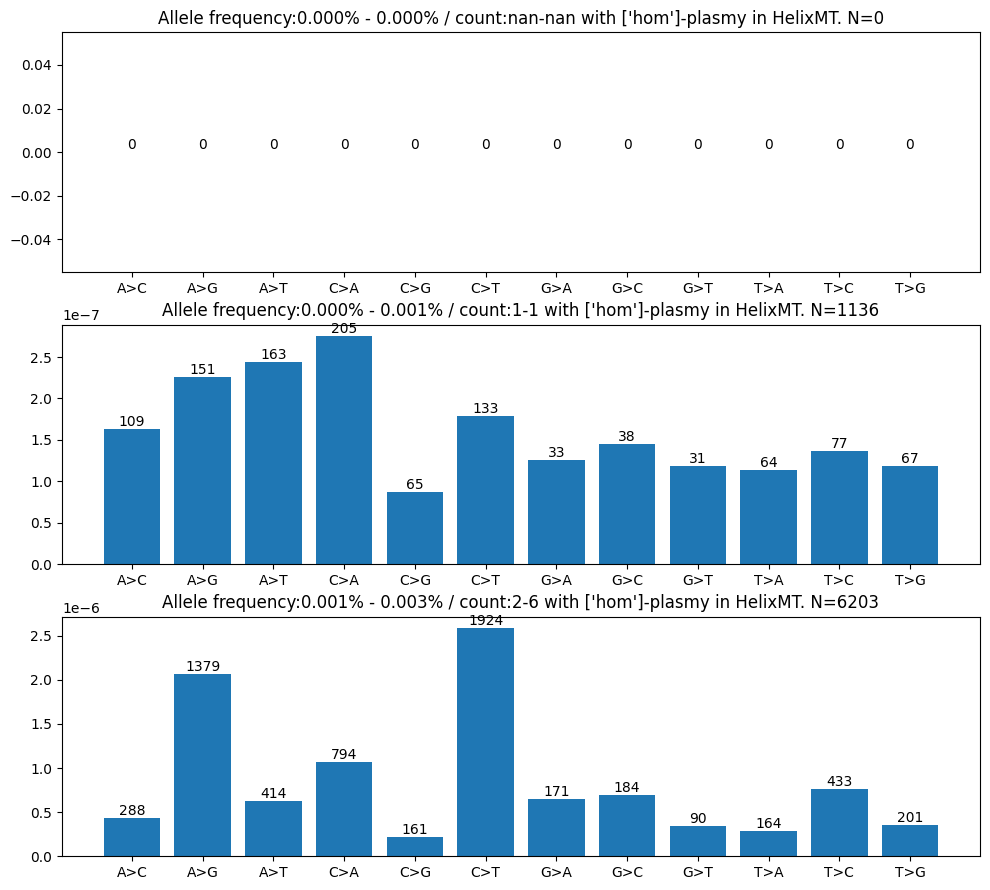

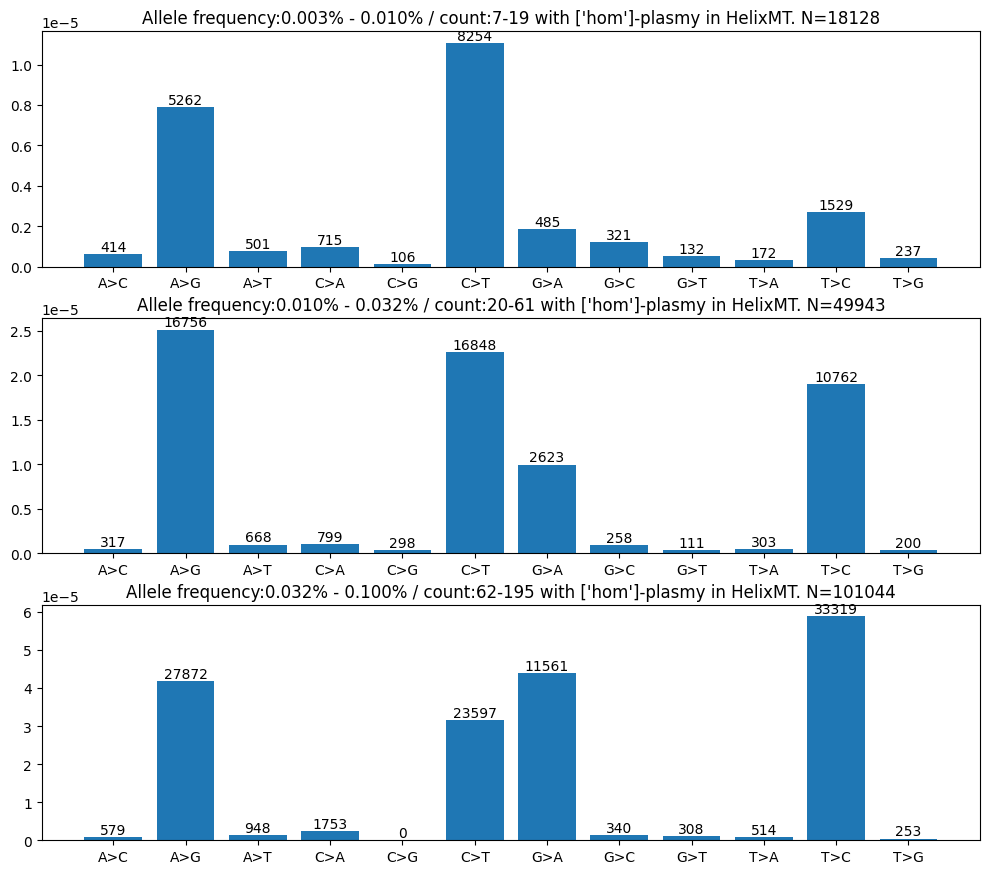

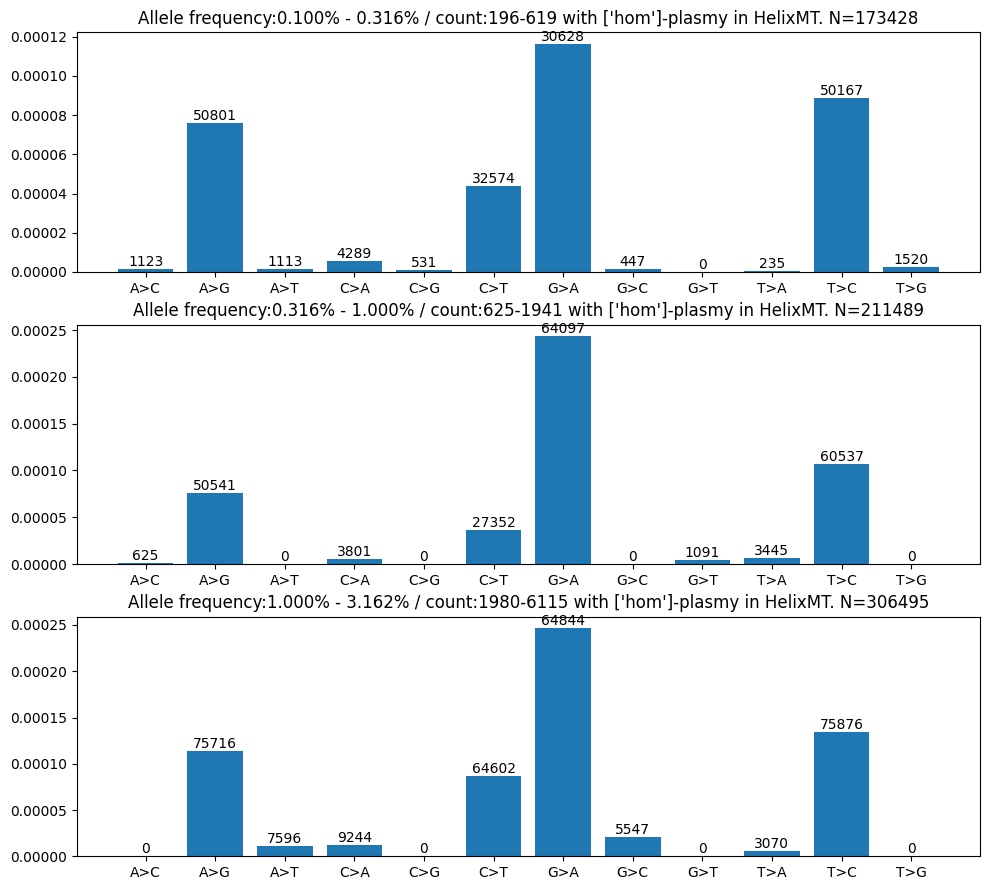

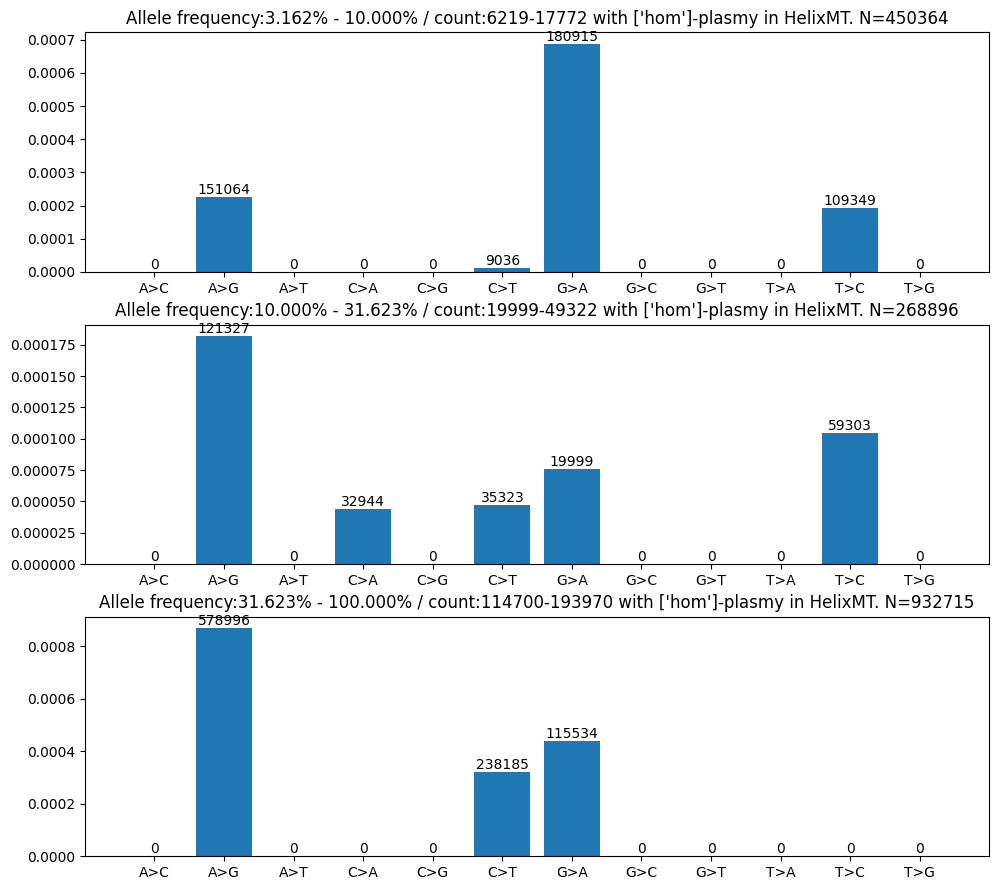

In [39]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in range(4):
        threshold_array = np.logspace(-6, 0, 13)[i*3:i*3+4]
        threshold_search_pb(only_syn_helix_df, helix_base_freq,
                    plasmy=['AC_hom'], db_samples_number=helix_samples_number,
                    threshold_array=threshold_array, db_name='HelixMT') # ,plasmy=['AC_hom']

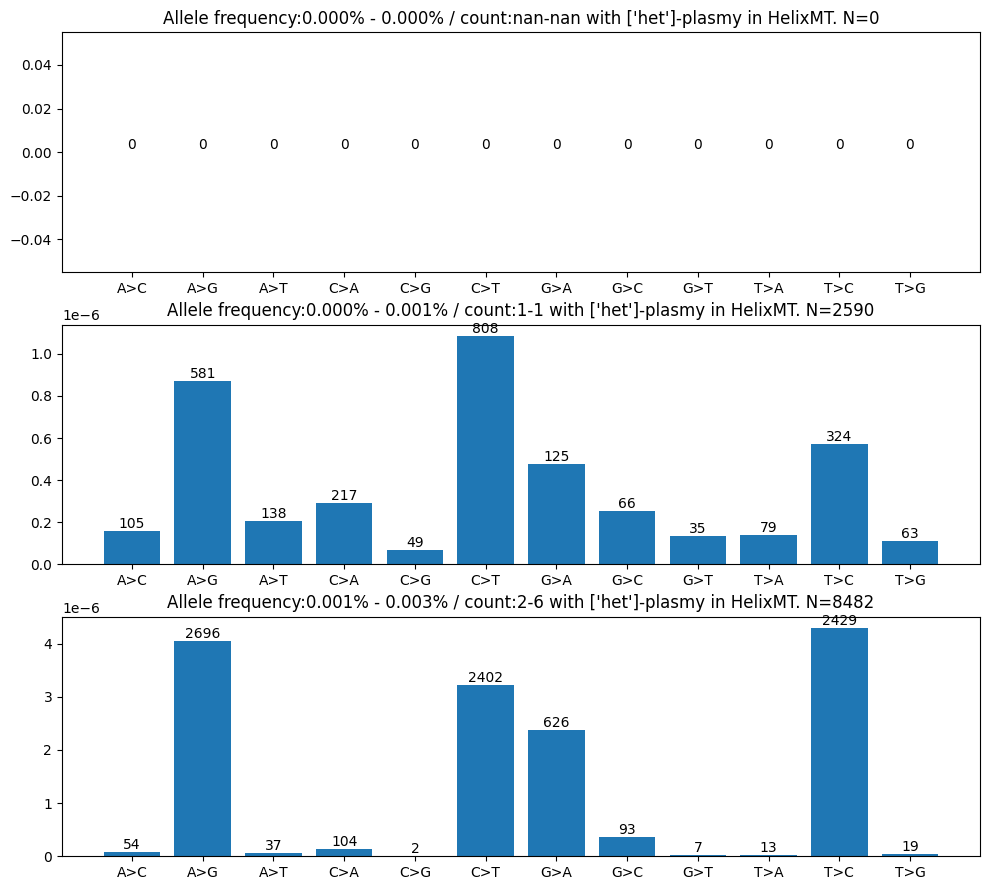

In [84]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    i = 0
    threshold_array = np.logspace(-6, 0, 13)[i*3:i*3+4]
    threshold_search_pb(only_syn_helix_df, helix_base_freq, 
                    db_samples_number=helix_samples_number, 
                    plasmy=['AC_het'], db_name='HelixMT',
                    threshold_array=threshold_array)

# Cos similarity

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    gnomad_subs_number_dict = threshold_search_pb(only_syn_gnomad_df, gnomad_base_freq, 
                    db_samples_number=gnomad_samples_number, 
                    db_name='gnomAD', dict=True)
    gnomad_subs_number_dict_het = threshold_search_pb(only_syn_gnomad_df, gnomad_base_freq, 
                    db_samples_number=gnomad_samples_number, 
                    plasmy=['AC_het'], db_name='gnomAD', dict=True)
    gnomad_subs_number_dict_hom = threshold_search_pb(only_syn_gnomad_df, gnomad_base_freq, 
                    db_samples_number=gnomad_samples_number, 
                    plasmy=['AC_hom'], db_name='gnomAD', dict=True)

In [28]:
for hom_ms, het_ms in zip(gnomad_subs_number_dict_hom, gnomad_subs_number_dict_het):
    print(hom_ms, cosine(gnomad_subs_number_dict_hom[hom_ms], gnomad_subs_number_dict_het[het_ms]))

0.000% 0
0.001% 0.19007812281237912
0.003% 0.4599243419731879
0.010% 0.6086474185021581
0.032% 0.596436931778057
0.100% 0
0.316% 0
1.000% 0
3.162% 0
10.000% 0
31.623% 0


In [29]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    helix_subs_number_dict = threshold_search_pb(only_syn_helix_df, helix_base_freq, 
                    db_samples_number=helix_samples_number, 
                    db_name='helix', dict=True)
    helix_subs_number_dict_het = threshold_search_pb(only_syn_helix_df, helix_base_freq, 
                    db_samples_number=helix_samples_number, 
                    plasmy=['AC_het'], db_name='helix', dict=True)
    helix_subs_number_dict_hom = threshold_search_pb(only_syn_helix_df, helix_base_freq, 
                    db_samples_number=helix_samples_number, 
                    plasmy=['AC_hom'], db_name='helix', dict=True)

In [32]:
for hom_ms, het_ms in zip(helix_subs_number_dict_hom, helix_subs_number_dict_het):
    print(hom_ms, cosine(helix_subs_number_dict_hom[hom_ms], helix_subs_number_dict_het[het_ms]))

0.000% 0.21342193350958716
0.001% 0.19108049742787547
0.003% 0.6149058523523177
0.010% 0.592302150985991
0.032% 0.30928164966742056
0.100% 0.5125056172646569
0.316% 0.12746545730104208
1.000% 0
3.162% 0
10.000% 0
31.623% 0


c:\Soft\Python\Lib\site-packages\scipy\spatial\distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [355]:
def cossim_plot(subs_number_plot_1, subs_number_plot_2):
    threshold_array = np.logspace(-6, 0, 13)[:-1]
    cossim_list_gnomad = []
    for threshold_idx in threshold_array:
        cossim = cosine(subs_number_plot_1[threshold_idx], subs_number_plot_2[threshold_idx])
        cossim_list_gnomad.append(cossim)
    plt.plot(cossim_list_gnomad)
    plt.xticks(ticks=[0,11], labels=threshold_array[::11])

c:\Soft\Python\Lib\site-packages\scipy\spatial\distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


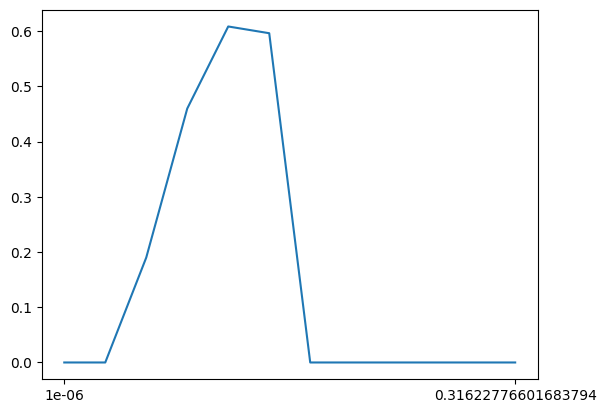

In [356]:
cossim_plot(gnomad_subs_number_dict_hom, gnomad_subs_number_dict_het)

# Jackknife

## gnomAD

In [55]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    jackknife_coef = 0.5
    # gnomad_subs_number_dict_jk = {}
    gnomad_subs_number_dict_het_jk = {}
    gnomad_subs_number_dict_hom_jk = {}
    for i in tqdm(range(100)):
        # gnomad_subs_number_dict_jk[i] = threshold_search_pb(only_syn_gnomad_df, gnomad_base_freq, 
        #         db_samples_number=gnomad_samples_number, 
        #         db_name='gnomAD', dict=True, jackknife=jackknife_coef)
        gnomad_subs_number_dict_het_jk[i] = threshold_search_pb(only_syn_gnomad_df, gnomad_base_freq, 
                        db_samples_number=gnomad_samples_number, 
                        plasmy=['AC_het'], db_name='gnomAD', dict=True, jackknife=jackknife_coef)
        gnomad_subs_number_dict_hom_jk[i] = threshold_search_pb(only_syn_gnomad_df, gnomad_base_freq, 
                        db_samples_number=gnomad_samples_number, 
                        plasmy=['AC_hom'], db_name='gnomAD', dict=True, jackknife=jackknife_coef)

  0%|          | 0/100 [00:00<?, ?it/s]

In [58]:
gnomad_subs_number_dict_hom_jk[i].keys()

dict_keys(['0.000%', '0.001%', '0.003%', '0.010%', '0.032%', '0.100%', '0.316%', '1.000%', '3.162%', '10.000%', '31.623%'])

In [74]:
thresholds = list(gnomad_subs_number_dict_hom_jk[i].keys())
cos_distributions_gnomad = {}
for threshold_lower in thresholds[1:4]:
    cos_distributions_gnomad[threshold_lower] = []
    for i in range(100):
        cos_distance = cosine(gnomad_subs_number_dict_hom_jk[i][threshold_lower], gnomad_subs_number_dict_het_jk[i][threshold_lower])
        cos_distributions_gnomad[threshold_lower].append(cos_distance)
print(cos_distributions_gnomad['0.001%'])

[0.20604662047873556, 0.18207803981139858, 0.21241978755124447, 0.20097750132936076, 0.19153294665892207, 0.19688849831737965, 0.1701583836376821, 0.1505538643882426, 0.15578621002611404, 0.13704005045106726, 0.17985171608303496, 0.16175648600323134, 0.18952269285038548, 0.185501256125435, 0.19697304408724758, 0.178525180558483, 0.19541337541524684, 0.19570125369079927, 0.194892378551194, 0.18894887811163852, 0.20535639413101936, 0.21256812263732816, 0.22458756033221372, 0.20635457767495946, 0.19802744664247518, 0.1732099348056525, 0.18878453833043507, 0.19786670038052356, 0.18839592602980426, 0.1745270910895247, 0.17930820138836434, 0.2073877487547151, 0.15903898597506283, 0.18608167522866592, 0.1643150084420516, 0.19162024549641665, 0.20332637471475423, 0.187345418744419, 0.21214454992278664, 0.2068277303804935, 0.16811033099747152, 0.16527232065532282, 0.177698600526765, 0.17420076083564862, 0.1797348762686849, 0.2122466747340388, 0.2111023906447087, 0.19476827549582454, 0.167587591

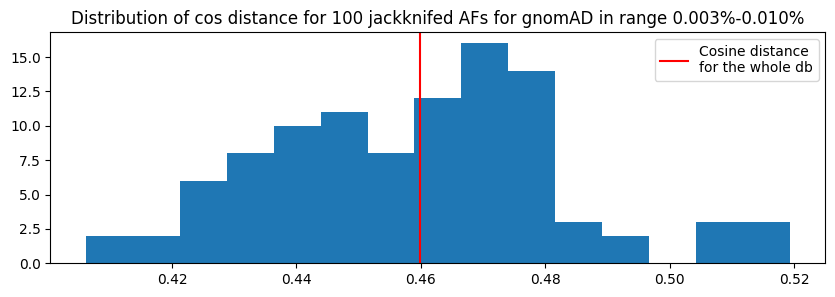

In [77]:
threshold_lower = thresholds[2]
threshold_upper = thresholds[3]
plt.figure(figsize=(10,3))
plt.hist(cos_distributions_gnomad[threshold_lower], bins=15)
cos_distance_gnomad = cosine(gnomad_subs_number_dict_hom[threshold_lower], gnomad_subs_number_dict_het[threshold_lower])
plt.axvline(cos_distance_gnomad, c='r', label='Cosine distance\nfor the whole db')
plt.legend()
plt.title(f'Distribution of cos distance for 100 jackknifed AFs for gnomAD in range {threshold_lower}-{threshold_upper}')
plt.show()

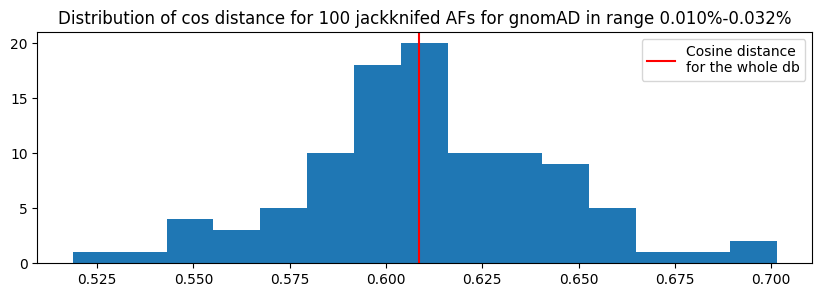

In [78]:
threshold_lower = thresholds[3]
threshold_upper = thresholds[4]
plt.figure(figsize=(10,3))
plt.hist(cos_distributions_gnomad[threshold_lower], bins=15)
cos_distance_gnomad = cosine(gnomad_subs_number_dict_hom[threshold_lower], gnomad_subs_number_dict_het[threshold_lower])
plt.axvline(cos_distance_gnomad, c='r', label='Cosine distance\nfor the whole db')
plt.legend()
plt.title(f'Distribution of cos distance for 100 jackknifed AFs for gnomAD in range {threshold_lower}-{threshold_upper}')
plt.show()

## HelixMT

In [85]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    helix_subs_number_dict = threshold_search_pb(only_syn_helix_df, helix_base_freq, 
                    db_samples_number=helix_samples_number, 
                    db_name='helix', dict=True)
    helix_subs_number_dict_het = threshold_search_pb(only_syn_helix_df, helix_base_freq, 
                    db_samples_number=helix_samples_number, 
                    plasmy=['AC_het'], db_name='helix', dict=True)
    helix_subs_number_dict_hom = threshold_search_pb(only_syn_helix_df, helix_base_freq, 
                    db_samples_number=helix_samples_number, 
                    plasmy=['AC_hom'], db_name='helix', dict=True)

In [79]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    jackknife_coef = 0.5
    # helix_subs_number_dict_jk = {}
    helix_subs_number_dict_het_jk = {}
    helix_subs_number_dict_hom_jk = {}
    for i in tqdm(range(100)):
        # helix_subs_number_dict_jk[i] = threshold_search_pb(only_syn_helix_df, helix_base_freq, 
        #         db_samples_number=helix_samples_number, 
        #         db_name='helix', dict=True, jackknife=jackknife_coef)
        helix_subs_number_dict_het_jk[i] = threshold_search_pb(only_syn_helix_df, helix_base_freq, 
                        db_samples_number=helix_samples_number, 
                        plasmy=['AC_het'], db_name='helix', dict=True, jackknife=jackknife_coef)
        helix_subs_number_dict_hom_jk[i] = threshold_search_pb(only_syn_helix_df, helix_base_freq, 
                        db_samples_number=helix_samples_number, 
                        plasmy=['AC_hom'], db_name='helix', dict=True, jackknife=jackknife_coef)

  0%|          | 0/100 [00:00<?, ?it/s]

In [82]:
print(thresholds)

['0.000%', '0.001%', '0.003%', '0.010%', '0.032%', '0.100%', '0.316%', '1.000%', '3.162%', '10.000%', '31.623%']


In [94]:
thresholds = list(helix_subs_number_dict_hom_jk[i].keys())
cos_distributions_helix = {}
for threshold_lower in thresholds:
    cos_distributions_helix[threshold_lower] = []
    for i in range(100):
        cos_distance = cosine(helix_subs_number_dict_hom_jk[i][threshold_lower], helix_subs_number_dict_het_jk[i][threshold_lower])
        cos_distributions_helix[threshold_lower].append(cos_distance)
print(cos_distributions_helix['0.001%'])

[0.20841561013543808, 0.19210623737563848, 0.2059229322685039, 0.18305335846476967, 0.2043634367059458, 0.2004272439160375, 0.18335772062345335, 0.18769866676666058, 0.18529738684667352, 0.20464946416739416, 0.1906437592647543, 0.19602479478909096, 0.19641608759911944, 0.20656199738007464, 0.1912652052332504, 0.2055633139885692, 0.18327152096985888, 0.19647484646652746, 0.21953550254754906, 0.21974889317969803, 0.19650238861023406, 0.20066554617190557, 0.20841952906028471, 0.1941742579649296, 0.21483213758639685, 0.20611338982383431, 0.21532228135634335, 0.19399519513059282, 0.1929580698068022, 0.1956059841729677, 0.18759281399077687, 0.18792700706701693, 0.192746309358661, 0.1967292154441691, 0.19405225350954225, 0.18788814134662246, 0.2332632931386993, 0.19307944172804048, 0.20082284240870774, 0.18775230925179065, 0.1825399460056435, 0.23577541678790503, 0.21268064321330304, 0.19524589152983707, 0.16726698233995074, 0.21064815312962282, 0.18119841947576232, 0.19777550060777283, 0.190

c:\Soft\Python\Lib\site-packages\scipy\spatial\distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


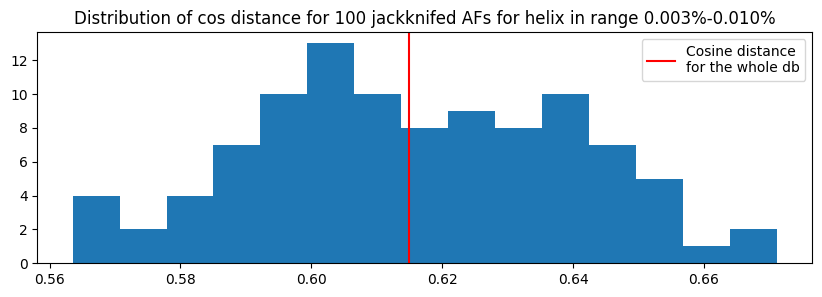

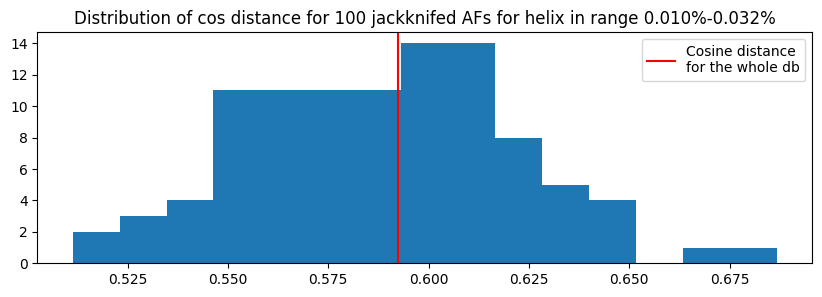

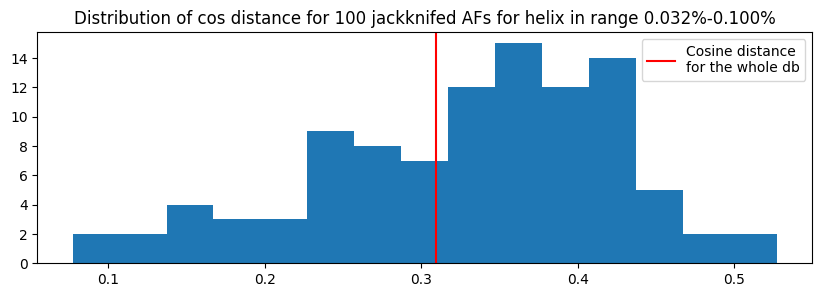

In [97]:
for i in range(2,5):
    threshold_lower = thresholds[i]
    threshold_upper = thresholds[i+1]
    plt.figure(figsize=(10,3))
    plt.hist(cos_distributions_helix[threshold_lower], bins=15)
    cos_distance_helix = cosine(helix_subs_number_dict_hom[threshold_lower], helix_subs_number_dict_het[threshold_lower])
    plt.axvline(cos_distance_helix, c='r', label='Cosine distance\nfor the whole db')
    plt.legend()
    plt.title(f'Distribution of cos distance for 100 jackknifed AFs for helix in range {threshold_lower}-{threshold_upper}')
    plt.show()

# Anticonons mutations

In [10]:
anticodon_positions_list = '''Position	AA	Reverse strand
611G	Phe	0
1633T	Val	0
3265T	LeuUUR	0
4292G	Ile	0
4367A	Gln	1
4432C	Met	0
5544T	Trp	0
5625A	Ala	1
5696C	Asn	1
5798C	Cys	1
5862C	Tyr	1
7484A	SerUCN	1
7548G	Asp	0
8323T	Lys	0
10021T	Gly	0
10435T	Arg	0
12168G	His	0
12226G	SerAGY	0
12298T	LeuCUN	0
14712A	Glu	1
15919T	Thr	0
15992A	Pro	1'''.split('\n')
anticodon_positions_list = [row.split('\t') for row in anticodon_positions_list]
anticodon_positions_list
anticodon_positions_df = pd.DataFrame(data=anticodon_positions_list[1:], columns=anticodon_positions_list[0])
anticodon_positions_df['position'] = anticodon_positions_df.Position.str[:-1]
anticodon_positions_df['ref'] = anticodon_positions_df.Position.str[-1:]
anticodon_positions_df = anticodon_positions_df.drop(columns='Position')
anticodon_positions_df = anticodon_positions_df.convert_dtypes()
anticodon_positions_df[['Reverse strand', 'position']] = anticodon_positions_df[['Reverse strand', 'position']].astype(int)
anticodon_positions_df

AA  Reverse strand  position ref
0      Phe               0       611   G
1      Val               0      1633   T
2   LeuUUR               0      3265   T
3      Ile               0      4292   G
4      Gln               1      4367   A
5      Met               0      4432   C
6      Trp               0      5544   T
7      Ala               1      5625   A
8      Asn               1      5696   C
9      Cys               1      5798   C
10     Tyr               1      5862   C
11  SerUCN               1      7484   A
12     Asp               0      7548   G
13     Lys               0      8323   T
14     Gly               0     10021   T
15     Arg               0     10435   T
16     His               0     12168   G
17  SerAGY               0     12226   G
18  LeuCUN               0     12298   T
19     Glu               1     14712   A
20     Thr               0     15919   T
21     Pro               1     15992   A

In [54]:
anticodon_snp_helix = []
cols = ['AA', 'position', 'ref', 'alt', 'AC_hom', 'AF_hom', 'AC_het', 'AF_het']
for idx in anticodon_positions_df.index:
    pos = anticodon_positions_df.loc[idx, 'position']
    ref = anticodon_positions_df.loc[idx, 'ref']
    aa = anticodon_positions_df.loc[idx, 'AA']
    db_position = only_subs_helix_df.loc[only_subs_helix_df.position == pos]
    if len(db_position) != 0:
        # print(ref)
        # display(db_position)
        anticodon_snp_helix.append([aa, pos, ref, db_position.alt.iloc[0], db_position.AC_hom.iloc[0], db_position.AF_hom.iloc[0], db_position.AC_het.iloc[0], db_position.AF_het.iloc[0]])
anticodon_snp_helix_df = pd.DataFrame(data=anticodon_snp_helix, columns=cols)
anticodon_snp_helix_df

AA  position ref alt  AC_hom    AF_hom  AC_het    AF_het
0     Val      1633   T   C       8  0.000041       5  0.000026
1     Ala      5625   A   G       1  0.000005       1  0.000005
2     Arg     10435   T   C       0  0.000000       4  0.000020
3  LeuCUN     12298   T   C       0  0.000000       2  0.000010
4     Thr     15919   T   C       0  0.000000       3  0.000015
5     Pro     15992   A   G       7  0.000036       2  0.000010

In [61]:
anticodon_snp_gnomad = []
cols = ['AA', 'position', 'ref', 'alt', 'AC_hom', 'AF_hom', 'AC_het', 'AF_het']
for idx in anticodon_positions_df.index:
    pos = anticodon_positions_df.loc[idx, 'position']
    ref = anticodon_positions_df.loc[idx, 'ref']
    aa = anticodon_positions_df.loc[idx, 'AA']
    db_position = only_subs_gnomad_df.loc[(only_subs_gnomad_df.position == pos) & (only_subs_gnomad_df.filters == 'PASS')]
    if len(db_position) != 0:
        # print(ref)
        # display(db_position)
        anticodon_snp_gnomad.append([aa, pos, ref, db_position.alt.iloc[0], db_position.AC_hom.iloc[0], db_position.AF_hom.iloc[0], db_position.AC_het.iloc[0], db_position.AF_het.iloc[0]])
anticodon_snp_gnomad_df = pd.DataFrame(data=anticodon_snp_gnomad, columns=cols)
anticodon_snp_gnomad_df

AA  position ref alt  AC_hom    AF_hom  AC_het    AF_het
0     Val      1633   T   C       2  0.000035       1  0.000018
1     Ile      4292   G   A       0  0.000000       1  0.000018
2  LeuCUN     12298   T   C       1  0.000018       0  0.000000
3     Pro     15992   A   G       4  0.000071       1  0.000018

In [71]:
stem_snp_helix = []
cols = ['AA', 'position', 'ref', 'alt', 'AC_hom', 'AF_hom', 'AC_het', 'AF_het']
for idx in anticodon_snp_helix_df.index:
    pos = anticodon_snp_helix_df.loc[idx, 'position']
    reverse = anticodon_positions_df.loc[anticodon_positions_df.position == pos, 'Reverse strand'].values[0]
    stem_pos_1 = range(pos - 7, pos - 3 + 1) if reverse == 0 else range(pos + 3, pos + 7 + 1)
    stem_pos_2 = range(pos + 5, pos + 9 + 1) if reverse == 0 else range(pos - 9, pos - 5 + 1)
    stem_pos = list(stem_pos_1) + list(stem_pos_2)
    ref = anticodon_snp_helix_df.loc[idx, 'ref']
    aa = anticodon_snp_helix_df.loc[idx, 'AA']
    db_position = only_subs_helix_df.loc[(only_subs_helix_df.position.isin(stem_pos))
                                         & (only_subs_helix_df.ref == ref)]
    if len(db_position) != 0:
        # display(db_position)
        for i in range(len(db_position)):
            stem_snp_helix.append([aa, db_position.position.iloc[i], db_position.ref.iloc[i], db_position.alt.iloc[i], db_position.AC_hom.iloc[i], db_position.AF_hom.iloc[i], db_position.AC_het.iloc[i], db_position.AF_het.iloc[i]])
stem_snp_helix_df = pd.DataFrame(data=stem_snp_helix, columns=cols)
stem_snp_helix_df

AA  position ref alt  AC_hom    AF_hom  AC_het    AF_het
0     Val      1638   T   C       0  0.000000       4  0.000020
1     Ala      5616   A   G       4  0.000020       3  0.000015
2     Arg     10440   T   C       0  0.000000       9  0.000046
3  LeuCUN     12291   T   C       1  0.000005       6  0.000031
4  LeuCUN     12295   T   C      12  0.000061       5  0.000026
5     Thr     15916   T   C      75  0.000383      11  0.000056

In [74]:
stem_snp_gnomad = []
cols = ['AA', 'position', 'ref', 'alt', 'AC_hom', 'AF_hom', 'AC_het', 'AF_het']
for idx in anticodon_snp_gnomad_df.index:
    pos = anticodon_snp_gnomad_df.loc[idx, 'position']
    reverse = anticodon_positions_df.loc[anticodon_positions_df.position == pos, 'Reverse strand'].values[0]
    stem_pos_1 = range(pos - 7, pos - 3 + 1) if reverse == 0 else range(pos + 3, pos + 7 + 1)
    stem_pos_2 = range(pos + 5, pos + 9 + 1) if reverse == 0 else range(pos - 9, pos - 5 + 1)
    stem_pos = list(stem_pos_1) + list(stem_pos_2)
    ref = anticodon_snp_gnomad_df.loc[idx, 'ref']
    aa = anticodon_snp_gnomad_df.loc[idx, 'AA']
    db_position = only_subs_gnomad_df.loc[(only_subs_gnomad_df.position.isin(stem_pos))
                                         & (only_subs_gnomad_df.ref == ref)]
    if len(db_position) != 0:
        # display(db_position)
        for i in range(len(db_position)):
            stem_snp_gnomad.append([aa, db_position.position.iloc[i], db_position.ref.iloc[i], db_position.alt.iloc[i], db_position.AC_hom.iloc[i], db_position.AF_hom.iloc[i], db_position.AC_het.iloc[i], db_position.AF_het.iloc[i]])
stem_snp_gnomad_df = pd.DataFrame(data=stem_snp_gnomad, columns=cols)
stem_snp_gnomad_df

AA  position ref alt  AC_hom    AF_hom  AC_het    AF_het
0     Val      1638   T   C       0  0.000000       0  0.000000
1  LeuCUN     12291   T   C       1  0.000018       0  0.000000
2  LeuCUN     12292   T   C       0  0.000000       0  0.000000
3  LeuCUN     12295   T   C       0  0.000000       3  0.000053